Build a model based on the data you have scraped. Don't worry if the model is far from perfect. You can always improve later. The most important thing is your story, you can answer the following questions after you finish modeling.

1. Why this project is important? What problem are you trying to solve?

What we want to do is to make a model that the retailer would like the ability to predict whether customers redeem the coupons received across channels, which will enable the retailer’s marketing team to accurately design coupon construct, and develop more precise and targeted marketing strategies.

2. How do you measure the model performance (metrics)? What is the benchmark?

Our problem is a classification problem, so we are using classification matrix (like accuracy, precision, recall, f1 to measure our model. The benchmark would be the result of logistic regression. 

3. How is your model? Have achieved your goal? How to evaluate the business value of your model?

Right now, we are trying our model. It isn't achieve our goal. The accurarcy is not so high, also precision and recall are not ideal.So, we are going to try more models, like (Tree based models, SVM). Our business value of our model can help our clients saving a lot of money. 

4. Any insights have you gotten from your model? Any actionable suggestions can you provide to your business partner?

Now, we don't have an ideal result. We don't have any suggesitions that can provide to our business partner.

5. What is the most challenging part in the project? How did you solve it? How will you futher improve your model if you get more resources and time.

How to do EDA and how to find the most effiency features from the dataset is the most challenging part in the project. 
We imported our data to SQL Server database and using T-SQL statement to merge data, to make data clearning. We also used dataframe's function(like 'group by', 'join', 'merge') to deal with data.
If we get more resources and time, we would find the methods to deal with missing value. Also, we would try almost all classification models to get more optimal solution.

Make sure that your work includes these parts:
1. **Pre-model Analysis**: process and visualize data; get insights of features and target.
2. **Problem Definition**: translate the business needs into machine learning problems; design metrics to measure model performance.
3. **Feature Engineering**: create features which might improve model performance.
4. **Modeling**: Model selection, feature elimination, validation, hyperparameter tuning.
5. **Post-model Analysis**: Model performance, feature importance, actionable suggestions to business.

# Pre-model Analysis: 

In [3]:
import pandas as pd
import numpy as np
import pymssql
from sqlalchemy import create_engine

In [4]:
def connDatabase():
    conn = pymssql.connect(
        host='linyang5124.database.windows.net',
        user='linyang',
        password='Techlent2022',
        database='lin',
        charset='utf8'
        )
    cursor = conn.cursor(as_dict=True)
    return cursor

In [5]:
cursor = connDatabase()

In [6]:
sql_0 = 'select * from train_01_customer_campaign'
cursor.execute(sql_0)
results = cursor.fetchall()
trains = pd.DataFrame(data = results)

In [7]:
trains.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,campaign_type,start_date,end_date
0,1,13,27,1053,False,46-55,None,0,1,None,5,X,2013-05-19,2013-07-05
1,2,13,116,48,False,36-45,Married,0,2,None,3,X,2013-05-19,2013-07-05
2,6,9,635,205,False,46-55,Married,0,2,None,7,Y,2013-03-11,2013-04-12
3,7,13,644,1050,False,None,None,None,None,None,None,X,2013-05-19,2013-07-05
4,9,8,1017,1489,False,46-55,Married,0,2,None,3,X,2013-02-16,2013-04-05


In [8]:
sql_1 = 'select * from campaign_data'
cursor.execute(sql_1)
results = cursor.fetchall()
campaign = pd.DataFrame(data = results)

In [9]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,1,Y,2012-12-12,2013-01-18
1,2,Y,2012-12-17,2013-01-18
2,3,Y,2012-12-22,2013-02-16
3,4,Y,2013-01-07,2013-02-08
4,5,Y,2013-01-12,2013-02-15


In [10]:
sql_2 = 'select * from customer_transaction_data'
cursor.execute(sql_2)
results = cursor.fetchall()
transaction = pd.DataFrame(data = results)

In [11]:
transaction.head()

,id,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,1,2012-11-09,64,8133,1,26.7100,0.0000,0.0000
1,2,2012-11-09,64,17538,1,71.2400,-17.4500,0.0000
2,3,2012-11-09,64,21124,2,178.1000,-91.9000,0.0000
3,4,2012-11-09,64,30144,1,89.0500,-45.9500,0.0000
4,5,2012-11-09,64,36074,1,70.8800,0.0000,0.0000


In [12]:
sql_3 = 'select distinct coupon_id from coupon_item_mapping order by coupon_id'
cursor.execute(sql_3)
results = cursor.fetchall()
coupon = pd.DataFrame(data = results)

In [13]:
coupon.head()

,coupon_id
0,1
1,2
2,3
3,4
4,5


In [14]:
sql_4 = 'select * from coupon_item_mapping order by coupon_id'
cursor.execute(sql_4)
results = cursor.fetchall()
coupon_item = pd.DataFrame(data = results)

In [15]:
coupon_item.head()

,id,coupon_id,item_id
0,28620,1,60068
1,28621,1,50199
2,28629,1,17091
3,28630,1,44112
4,28694,1,44868


# Problem Definition

The business problem is based on previous transaction & performance data from the last 18 campaigns, predict the probability for the next 10 campaigns in the test set for each coupon and customer combination, whether the customer will redeem the coupon or not.

The machine learning problem is using coupon_id, campaign_id and customer_id to predict the redemption status. 1: use coupon, 0: not use coupon. 
The most challenge is we need find the used features from coupon_id, campaign_id and customer_id. 
What I am doing is found the sume of sales, products and counpon for the coupon_id, campaign_id and cusotmer_id as the features.

# Feature Engineering 

In [17]:
'''
get the sum of sales for each campaign, then merge them to train table by campaign id
'''
def getSumOfCampaign(transaction, campaign, trains):
    date_total = transaction.groupby('date', as_index=False).agg({'quantity':sum,
                                                  'selling_price':sum,
                                                  'other_discount':sum,
                                                  'coupon_discount':sum})
    #print(date_total)
    campaign_total = {}
    colunms = ['campaign_id','campaign_quantity','campaign_selling_price','campaign_other_discount', 'campaign_coupon_discount']
    for i in colunms:
        campaign_total[i] = [0]*len(campaign)
    #print(campaign_total)
    for i in range(len(campaign)):
        camp1 = campaign.iloc[i]
        camp2 = date_total[(date_total['date']>=camp1['start_date'])&(date_total['date']<=camp1['end_date'])]
        campaign_total['campaign_id'][i] = campaign.iloc[i]['campaign_id']
        campaign_total['campaign_quantity'][i] = camp2['quantity'].sum()
        campaign_total['campaign_selling_price'][i] = camp2['selling_price'].sum()
        campaign_total['campaign_other_discount'][i] = camp2['other_discount'].sum()
        campaign_total['campaign_coupon_discount'][i] = camp2['coupon_discount'].sum()
    campaign_total = pd.DataFrame(campaign_total)
    #print(campaign_total)
    trains = pd.merge(left=trains, right=campaign_total, on='campaign_id', how='left')
    #print(trains)
    return trains

In [18]:
trains_myfinal = getSumOfCampaign(transaction, campaign, trains)
trains_myfinal.to_csv('trains_myfinal.csv')

In [19]:
trains_myfinal.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,campaign_type,start_date,end_date,campaign_quantity,campaign_selling_price,campaign_other_discount,campaign_coupon_discount
0,1,13,27,1053,False,46-55,None,0,1,None,5,X,2013-05-19,2013-07-05,18367902,14031107.1900,-2093022.0300,-103060.9100
1,2,13,116,48,False,36-45,Married,0,2,None,3,X,2013-05-19,2013-07-05,18367902,14031107.1900,-2093022.0300,-103060.9100
2,6,9,635,205,False,46-55,Married,0,2,None,7,Y,2013-03-11,2013-04-12,12233051,10576352.4000,-1638535.3600,-70751.7800
3,7,13,644,1050,False,None,None,None,None,None,None,X,2013-05-19,2013-07-05,18367902,14031107.1900,-2093022.0300,-103060.9100
4,9,8,1017,1489,False,46-55,Married,0,2,None,3,X,2013-02-16,2013-04-05,18555906,15882207.8000,-2399649.5700,-106292.5000


In [20]:
'''
get the sum of sales for each customer, then merge them to train table by customer id
'''
def getSumOfCustomer(transaction, trains):
    customer_total = transaction.groupby('customer_id', as_index=False).agg({'quantity':sum,
                                                  'selling_price':sum,
                                                  'other_discount':sum,
                                                  'coupon_discount':sum})    
    customer_total.rename(columns = {'quantity':'customer_quantity',
                                     'selling_price':'customer_selling_price',
                                     'other_discount':'customer_other_discount',
                                     'coupon_discount':'customer_coupon_discount',}, inplace=True)
    #print(customer_total)
    trains = pd.merge(left=trains, right=customer_total, on='customer_id', how='left')
    return trains

In [21]:
trains_myfinal = getSumOfCustomer(transaction, trains_myfinal)
trains_myfinal.to_csv('trains_myfinal.csv')

In [22]:
'''
get the sum of sales for each coupon(includes the sum of sales for each item in this coupon), 
then merge them to train table by coupon id
'''
def getSumOfCouponByItem(transaction, coupon_item, trains):
    #coupon_total = {}
    colunms = ['coupon_id',
               'coupon_quantity',
               'coupon_selling_price',
               'coupon_other_discount', 
               'coupon_coupon_discount']
    item_total = transaction.groupby('item_id', as_index=False).agg({'quantity':sum,
                                                  'selling_price':sum,
                                                  'other_discount':sum,
                                                  'coupon_discount':sum})    
    #print(item_total)
    coupon_total_1 = pd.merge(left=coupon_item, right=item_total, on='item_id', how='left')
    #print(coupon_total_1)
    coupon_total_2 = coupon_total_1.groupby('coupon_id', as_index=False).agg({'quantity':sum,
                                                  'selling_price':sum,
                                                  'other_discount':sum,
                                                  'coupon_discount':sum})  
    coupon_total_2.rename(columns = {'quantity':'coupon_quantity',
                                     'selling_price':'coupon_selling_price',
                                     'other_discount':'coupon_other_discount',
                                     'coupon_discount':'coupon_coupon_discount',}, inplace=True)
    #print(coupon_total_2)
    trains = pd.merge(left=trains, right=coupon_total_2, on='coupon_id', how='left')
    return trains

In [23]:
trains_myfinal = getSumOfCouponByItem(transaction, coupon_item, trains_myfinal)
trains_myfinal.to_csv('trains_myfinal.csv')

In [24]:
trains_myfinal.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,...,campaign_other_discount,campaign_coupon_discount,customer_quantity,customer_selling_price,customer_other_discount,customer_coupon_discount,coupon_quantity,coupon_selling_price,coupon_other_discount,coupon_coupon_discount
0,1,13,27,1053,False,46-55,None,0,1,None,...,-2093022.0300,-103060.9100,105551,57120.7500,-10282.3700,-89.0500,4661.0,318372.9200,-225584.3800,-5349.9300
1,2,13,116,48,False,36-45,Married,0,2,None,...,-2093022.0300,-103060.9100,12143,90185.1000,-10664.1800,-1237.7900,86.0,5418.9600,-684.2700,0.0000
2,6,9,635,205,False,46-55,Married,0,2,None,...,-1638535.3600,-70751.7800,1351,117461.6600,-17261.7900,-2145.7200,202.0,47673.7700,-23566.3500,-605.5400
3,7,13,644,1050,False,None,None,None,None,None,...,-2093022.0300,-103060.9100,306,23291.4200,-3947.3700,-178.1000,47.0,4154.4200,-309.9100,-17.8100
4,9,8,1017,1489,False,46-55,Married,0,2,None,...,-2399649.5700,-106292.5000,139063,67797.4900,-11534.9000,-265.0100,1610.0,272558.5500,-54950.7400,-569.9200


In [25]:
'''
get the sum of sales for each customer on the campaign
then merge them to train table by customer id
'''

def getSumOfCustomerByCampaign(transaction, campaign, trains):
    customer_campaign_total = {}
    colunms = ['id',
               'customer_campaign_quantity',
               'customer_campaign_selling_price',
               'customer_campaign_other_discount', 
               'customer_campaign_coupon_discount']
    for i in colunms:
        customer_campaign_total[i] = [0]*len(trains)
        
    first = 0
    for i in range(len(trains)):
    #for i in range(1000):
        second = i
        train_pre = trains.iloc[first]
        train = trains.iloc[i]
        
        if (train_pre['customer_id'] == train['customer_id']) and (train_pre['campaign_id'] == train['campaign_id']) and i>0:
            #print('{0} continue!'.format(i))
            customer_campaign_total['id'][i] = train['id']
            customer_campaign_total['customer_campaign_quantity'][i] = customer_campaign_total['customer_campaign_quantity'][first]
            customer_campaign_total['customer_campaign_selling_price'][i]=customer_campaign_total['customer_campaign_selling_price'][first]
            customer_campaign_total['customer_campaign_other_discount'][i]=customer_campaign_total['customer_campaign_other_discount'][first]
            customer_campaign_total['customer_campaign_coupon_discount'][i]=customer_campaign_total['customer_campaign_coupon_discount'][first]
            print('i={0}, train_id={1} done!'.format(i, train['id']))
            continue
        
        first = second
        customer_campaign = transaction[(transaction['date']>=train['start_date'])
                                        &(transaction['date']<=train['end_date'])
                                        &(transaction['customer_id']==train['customer_id'])]
        #print(customer_campaign)
        customer_campaign_total['id'][i] = trains.iloc[i]['id']
        customer_campaign_total['customer_campaign_quantity'][i] = customer_campaign['quantity'].sum()
        customer_campaign_total['customer_campaign_selling_price'][i] = customer_campaign['selling_price'].sum()
        customer_campaign_total['customer_campaign_other_discount'][i] = customer_campaign['other_discount'].sum()
        customer_campaign_total['customer_campaign_coupon_discount'][i] = customer_campaign['coupon_discount'].sum()
        #print(customer_campaign_total)
        print('i={0}, train_id={1} done!'.format(i, train['id']))
    customer_campaign_total = pd.DataFrame(customer_campaign_total)
    trains = pd.merge(left=trains, right=customer_campaign_total, on='id', how='left')
    return trains

In [26]:
trains_myfinal = trains_myfinal.sort_values(['customer_id', 'campaign_id'])
trains_myfinal = getSumOfCustomerByCampaign(transaction, campaign, trains_myfinal)

i=0, train_id=5085 done!
i=1, train_id=5380 done!
i=2, train_id=9960 done!
i=3, train_id=11262 done!
i=4, train_id=16408 done!
i=5, train_id=24063 done!
i=6, train_id=32530 done!
i=7, train_id=33151 done!
i=8, train_id=36168 done!
i=9, train_id=37226 done!
i=10, train_id=41644 done!
i=11, train_id=47528 done!
i=12, train_id=48988 done!
i=13, train_id=55285 done!
i=14, train_id=56190 done!
i=15, train_id=62237 done!
i=16, train_id=64555 done!
i=17, train_id=69667 done!
i=18, train_id=78231 done!
i=19, train_id=82987 done!
i=20, train_id=84833 done!
i=21, train_id=93767 done!
i=22, train_id=94621 done!
i=23, train_id=114549 done!
i=24, train_id=115611 done!
i=25, train_id=121542 done!
i=26, train_id=127352 done!
i=27, train_id=127409 done!
i=28, train_id=9849 done!
i=29, train_id=14264 done!
i=30, train_id=24467 done!
i=31, train_id=36239 done!
i=32, train_id=45470 done!
i=33, train_id=48771 done!
i=34, train_id=51859 done!
i=35, train_id=53230 done!
i=36, train_id=53453 done!
i=37, trai

i=300, train_id=11177 done!
i=301, train_id=11478 done!
i=302, train_id=12591 done!
i=303, train_id=35857 done!
i=304, train_id=54404 done!
i=305, train_id=61351 done!
i=306, train_id=68151 done!
i=307, train_id=70582 done!
i=308, train_id=83486 done!
i=309, train_id=86813 done!
i=310, train_id=87610 done!
i=311, train_id=89846 done!
i=312, train_id=111290 done!
i=313, train_id=122869 done!
i=314, train_id=125272 done!
i=315, train_id=607 done!
i=316, train_id=897 done!
i=317, train_id=2138 done!
i=318, train_id=3338 done!
i=319, train_id=4999 done!
i=320, train_id=5150 done!
i=321, train_id=5479 done!
i=322, train_id=13599 done!
i=323, train_id=43742 done!
i=324, train_id=44160 done!
i=325, train_id=48985 done!
i=326, train_id=49467 done!
i=327, train_id=70596 done!
i=328, train_id=73011 done!
i=329, train_id=87978 done!
i=330, train_id=88194 done!
i=331, train_id=97144 done!
i=332, train_id=97832 done!
i=333, train_id=108569 done!
i=334, train_id=114088 done!
i=335, train_id=1235 don

i=617, train_id=12666 done!
i=618, train_id=13970 done!
i=619, train_id=22326 done!
i=620, train_id=29866 done!
i=621, train_id=47705 done!
i=622, train_id=50570 done!
i=623, train_id=53875 done!
i=624, train_id=58532 done!
i=625, train_id=62910 done!
i=626, train_id=76330 done!
i=627, train_id=78167 done!
i=628, train_id=81514 done!
i=629, train_id=85118 done!
i=630, train_id=87023 done!
i=631, train_id=89354 done!
i=632, train_id=93687 done!
i=633, train_id=100619 done!
i=634, train_id=109281 done!
i=635, train_id=111478 done!
i=636, train_id=112587 done!
i=637, train_id=116839 done!
i=638, train_id=120684 done!
i=639, train_id=121132 done!
i=640, train_id=126253 done!
i=641, train_id=5825 done!
i=642, train_id=6037 done!
i=643, train_id=8248 done!
i=644, train_id=21570 done!
i=645, train_id=26077 done!
i=646, train_id=27162 done!
i=647, train_id=35373 done!
i=648, train_id=38012 done!
i=649, train_id=39052 done!
i=650, train_id=44710 done!
i=651, train_id=47060 done!
i=652, train_id

i=949, train_id=6749 done!
i=950, train_id=7021 done!
i=951, train_id=9315 done!
i=952, train_id=20201 done!
i=953, train_id=24708 done!
i=954, train_id=25843 done!
i=955, train_id=31415 done!
i=956, train_id=35146 done!
i=957, train_id=47798 done!
i=958, train_id=49611 done!
i=959, train_id=50220 done!
i=960, train_id=59790 done!
i=961, train_id=67474 done!
i=962, train_id=68522 done!
i=963, train_id=74763 done!
i=964, train_id=80803 done!
i=965, train_id=84364 done!
i=966, train_id=86029 done!
i=967, train_id=89276 done!
i=968, train_id=103328 done!
i=969, train_id=108790 done!
i=970, train_id=110467 done!
i=971, train_id=110987 done!
i=972, train_id=111165 done!
i=973, train_id=124822 done!
i=974, train_id=3605 done!
i=975, train_id=26016 done!
i=976, train_id=35386 done!
i=977, train_id=36900 done!
i=978, train_id=38730 done!
i=979, train_id=47757 done!
i=980, train_id=48581 done!
i=981, train_id=49077 done!
i=982, train_id=52993 done!
i=983, train_id=62659 done!
i=984, train_id=74

i=1261, train_id=6170 done!
i=1262, train_id=7829 done!
i=1263, train_id=7831 done!
i=1264, train_id=14019 done!
i=1265, train_id=14421 done!
i=1266, train_id=16870 done!
i=1267, train_id=29134 done!
i=1268, train_id=29479 done!
i=1269, train_id=33732 done!
i=1270, train_id=36009 done!
i=1271, train_id=43410 done!
i=1272, train_id=43791 done!
i=1273, train_id=45384 done!
i=1274, train_id=46105 done!
i=1275, train_id=46530 done!
i=1276, train_id=47888 done!
i=1277, train_id=53830 done!
i=1278, train_id=57550 done!
i=1279, train_id=58104 done!
i=1280, train_id=69193 done!
i=1281, train_id=77283 done!
i=1282, train_id=78109 done!
i=1283, train_id=80606 done!
i=1284, train_id=95088 done!
i=1285, train_id=95323 done!
i=1286, train_id=97317 done!
i=1287, train_id=98676 done!
i=1288, train_id=102333 done!
i=1289, train_id=112058 done!
i=1290, train_id=112772 done!
i=1291, train_id=125512 done!
i=1292, train_id=127611 done!
i=1293, train_id=127704 done!
i=1294, train_id=6070 done!
i=1295, trai

i=1562, train_id=549 done!
i=1563, train_id=5511 done!
i=1564, train_id=38425 done!
i=1565, train_id=42186 done!
i=1566, train_id=47595 done!
i=1567, train_id=55942 done!
i=1568, train_id=61473 done!
i=1569, train_id=65731 done!
i=1570, train_id=68894 done!
i=1571, train_id=73474 done!
i=1572, train_id=82676 done!
i=1573, train_id=95519 done!
i=1574, train_id=101691 done!
i=1575, train_id=117752 done!
i=1576, train_id=124020 done!
i=1577, train_id=124708 done!
i=1578, train_id=125822 done!
i=1579, train_id=4729 done!
i=1580, train_id=21831 done!
i=1581, train_id=34988 done!
i=1582, train_id=40145 done!
i=1583, train_id=40781 done!
i=1584, train_id=45088 done!
i=1585, train_id=57218 done!
i=1586, train_id=57280 done!
i=1587, train_id=57864 done!
i=1588, train_id=66767 done!
i=1589, train_id=67088 done!
i=1590, train_id=76582 done!
i=1591, train_id=84094 done!
i=1592, train_id=84950 done!
i=1593, train_id=90056 done!
i=1594, train_id=90378 done!
i=1595, train_id=102518 done!
i=1596, trai

i=1877, train_id=20298 done!
i=1878, train_id=25679 done!
i=1879, train_id=41542 done!
i=1880, train_id=48358 done!
i=1881, train_id=65547 done!
i=1882, train_id=76311 done!
i=1883, train_id=76541 done!
i=1884, train_id=82680 done!
i=1885, train_id=89236 done!
i=1886, train_id=92966 done!
i=1887, train_id=94468 done!
i=1888, train_id=109564 done!
i=1889, train_id=120121 done!
i=1890, train_id=123770 done!
i=1891, train_id=7047 done!
i=1892, train_id=21281 done!
i=1893, train_id=21556 done!
i=1894, train_id=34110 done!
i=1895, train_id=38623 done!
i=1896, train_id=47877 done!
i=1897, train_id=51307 done!
i=1898, train_id=86936 done!
i=1899, train_id=89706 done!
i=1900, train_id=105975 done!
i=1901, train_id=112929 done!
i=1902, train_id=120641 done!
i=1903, train_id=120686 done!
i=1904, train_id=121677 done!
i=1905, train_id=124715 done!
i=1906, train_id=321 done!
i=1907, train_id=712 done!
i=1908, train_id=7682 done!
i=1909, train_id=25862 done!
i=1910, train_id=47872 done!
i=1911, tra

i=2195, train_id=2140 done!
i=2196, train_id=22227 done!
i=2197, train_id=27711 done!
i=2198, train_id=30896 done!
i=2199, train_id=34171 done!
i=2200, train_id=38586 done!
i=2201, train_id=43102 done!
i=2202, train_id=46164 done!
i=2203, train_id=48189 done!
i=2204, train_id=53887 done!
i=2205, train_id=66053 done!
i=2206, train_id=66895 done!
i=2207, train_id=88628 done!
i=2208, train_id=92072 done!
i=2209, train_id=99417 done!
i=2210, train_id=112945 done!
i=2211, train_id=114646 done!
i=2212, train_id=206 done!
i=2213, train_id=3752 done!
i=2214, train_id=7483 done!
i=2215, train_id=39427 done!
i=2216, train_id=44132 done!
i=2217, train_id=53493 done!
i=2218, train_id=64138 done!
i=2219, train_id=69681 done!
i=2220, train_id=71166 done!
i=2221, train_id=96617 done!
i=2222, train_id=104276 done!
i=2223, train_id=13115 done!
i=2224, train_id=22408 done!
i=2225, train_id=63656 done!
i=2226, train_id=63779 done!
i=2227, train_id=82063 done!
i=2228, train_id=89333 done!
i=2229, train_id

i=2493, train_id=2 done!
i=2494, train_id=6959 done!
i=2495, train_id=8549 done!
i=2496, train_id=23391 done!
i=2497, train_id=29651 done!
i=2498, train_id=34573 done!
i=2499, train_id=37362 done!
i=2500, train_id=68323 done!
i=2501, train_id=80467 done!
i=2502, train_id=82668 done!
i=2503, train_id=84784 done!
i=2504, train_id=87493 done!
i=2505, train_id=88575 done!
i=2506, train_id=104303 done!
i=2507, train_id=109968 done!
i=2508, train_id=13727 done!
i=2509, train_id=17455 done!
i=2510, train_id=21393 done!
i=2511, train_id=29469 done!
i=2512, train_id=32963 done!
i=2513, train_id=52512 done!
i=2514, train_id=73828 done!
i=2515, train_id=75141 done!
i=2516, train_id=82746 done!
i=2517, train_id=94387 done!
i=2518, train_id=99392 done!
i=2519, train_id=100844 done!
i=2520, train_id=101318 done!
i=2521, train_id=108834 done!
i=2522, train_id=114515 done!
i=2523, train_id=119505 done!
i=2524, train_id=16133 done!
i=2525, train_id=27609 done!
i=2526, train_id=32134 done!
i=2527, train

i=2791, train_id=858 done!
i=2792, train_id=12087 done!
i=2793, train_id=13889 done!
i=2794, train_id=20913 done!
i=2795, train_id=25263 done!
i=2796, train_id=25423 done!
i=2797, train_id=32388 done!
i=2798, train_id=34036 done!
i=2799, train_id=34638 done!
i=2800, train_id=39275 done!
i=2801, train_id=48528 done!
i=2802, train_id=64471 done!
i=2803, train_id=66782 done!
i=2804, train_id=74037 done!
i=2805, train_id=77119 done!
i=2806, train_id=77761 done!
i=2807, train_id=80666 done!
i=2808, train_id=82497 done!
i=2809, train_id=94528 done!
i=2810, train_id=100473 done!
i=2811, train_id=100782 done!
i=2812, train_id=116822 done!
i=2813, train_id=122628 done!
i=2814, train_id=124140 done!
i=2815, train_id=125947 done!
i=2816, train_id=2302 done!
i=2817, train_id=15248 done!
i=2818, train_id=18995 done!
i=2819, train_id=22699 done!
i=2820, train_id=41182 done!
i=2821, train_id=42757 done!
i=2822, train_id=46975 done!
i=2823, train_id=47651 done!
i=2824, train_id=47680 done!
i=2825, tra

i=3091, train_id=39 done!
i=3092, train_id=12789 done!
i=3093, train_id=20338 done!
i=3094, train_id=29999 done!
i=3095, train_id=31612 done!
i=3096, train_id=43384 done!
i=3097, train_id=51062 done!
i=3098, train_id=51083 done!
i=3099, train_id=51629 done!
i=3100, train_id=59980 done!
i=3101, train_id=66243 done!
i=3102, train_id=67562 done!
i=3103, train_id=67564 done!
i=3104, train_id=68165 done!
i=3105, train_id=70618 done!
i=3106, train_id=71304 done!
i=3107, train_id=76016 done!
i=3108, train_id=77363 done!
i=3109, train_id=103898 done!
i=3110, train_id=115361 done!
i=3111, train_id=118473 done!
i=3112, train_id=120627 done!
i=3113, train_id=124845 done!
i=3114, train_id=9593 done!
i=3115, train_id=14333 done!
i=3116, train_id=17866 done!
i=3117, train_id=20987 done!
i=3118, train_id=31923 done!
i=3119, train_id=31986 done!
i=3120, train_id=35796 done!
i=3121, train_id=35949 done!
i=3122, train_id=42512 done!
i=3123, train_id=49773 done!
i=3124, train_id=60012 done!
i=3125, train

i=3378, train_id=2136 done!
i=3379, train_id=13984 done!
i=3380, train_id=15651 done!
i=3381, train_id=16438 done!
i=3382, train_id=24446 done!
i=3383, train_id=25758 done!
i=3384, train_id=32368 done!
i=3385, train_id=38824 done!
i=3386, train_id=50150 done!
i=3387, train_id=53983 done!
i=3388, train_id=54623 done!
i=3389, train_id=73242 done!
i=3390, train_id=73425 done!
i=3391, train_id=77456 done!
i=3392, train_id=93429 done!
i=3393, train_id=108664 done!
i=3394, train_id=123676 done!
i=3395, train_id=3205 done!
i=3396, train_id=9391 done!
i=3397, train_id=19271 done!
i=3398, train_id=20965 done!
i=3399, train_id=34240 done!
i=3400, train_id=41469 done!
i=3401, train_id=49702 done!
i=3402, train_id=52657 done!
i=3403, train_id=73943 done!
i=3404, train_id=95071 done!
i=3405, train_id=108116 done!
i=3406, train_id=127624 done!
i=3407, train_id=128540 done!
i=3408, train_id=3470 done!
i=3409, train_id=18916 done!
i=3410, train_id=37847 done!
i=3411, train_id=40075 done!
i=3412, train

i=3700, train_id=796 done!
i=3701, train_id=22713 done!
i=3702, train_id=42960 done!
i=3703, train_id=44552 done!
i=3704, train_id=51416 done!
i=3705, train_id=61746 done!
i=3706, train_id=66819 done!
i=3707, train_id=76898 done!
i=3708, train_id=111015 done!
i=3709, train_id=117787 done!
i=3710, train_id=120875 done!
i=3711, train_id=123654 done!
i=3712, train_id=795 done!
i=3713, train_id=4850 done!
i=3714, train_id=8827 done!
i=3715, train_id=16327 done!
i=3716, train_id=22760 done!
i=3717, train_id=28224 done!
i=3718, train_id=33976 done!
i=3719, train_id=41767 done!
i=3720, train_id=52083 done!
i=3721, train_id=55149 done!
i=3722, train_id=65282 done!
i=3723, train_id=71079 done!
i=3724, train_id=72715 done!
i=3725, train_id=82966 done!
i=3726, train_id=90486 done!
i=3727, train_id=97283 done!
i=3728, train_id=110973 done!
i=3729, train_id=116003 done!
i=3730, train_id=1011 done!
i=3731, train_id=3596 done!
i=3732, train_id=7073 done!
i=3733, train_id=9945 done!
i=3734, train_id=1

i=4026, train_id=115547 done!
i=4027, train_id=118856 done!
i=4028, train_id=123919 done!
i=4029, train_id=127451 done!
i=4030, train_id=128420 done!
i=4031, train_id=11209 done!
i=4032, train_id=22508 done!
i=4033, train_id=30444 done!
i=4034, train_id=30504 done!
i=4035, train_id=36277 done!
i=4036, train_id=42172 done!
i=4037, train_id=54242 done!
i=4038, train_id=61404 done!
i=4039, train_id=71981 done!
i=4040, train_id=73511 done!
i=4041, train_id=74535 done!
i=4042, train_id=76840 done!
i=4043, train_id=82553 done!
i=4044, train_id=84605 done!
i=4045, train_id=92720 done!
i=4046, train_id=92758 done!
i=4047, train_id=95748 done!
i=4048, train_id=103465 done!
i=4049, train_id=104856 done!
i=4050, train_id=108378 done!
i=4051, train_id=121124 done!
i=4052, train_id=122887 done!
i=4053, train_id=126770 done!
i=4054, train_id=12697 done!
i=4055, train_id=18753 done!
i=4056, train_id=23633 done!
i=4057, train_id=26597 done!
i=4058, train_id=32304 done!
i=4059, train_id=34406 done!
i=4

i=4327, train_id=10734 done!
i=4328, train_id=13049 done!
i=4329, train_id=18166 done!
i=4330, train_id=18829 done!
i=4331, train_id=34229 done!
i=4332, train_id=36021 done!
i=4333, train_id=37142 done!
i=4334, train_id=43547 done!
i=4335, train_id=55893 done!
i=4336, train_id=90099 done!
i=4337, train_id=90687 done!
i=4338, train_id=93807 done!
i=4339, train_id=94303 done!
i=4340, train_id=94732 done!
i=4341, train_id=101381 done!
i=4342, train_id=109488 done!
i=4343, train_id=110862 done!
i=4344, train_id=117423 done!
i=4345, train_id=118620 done!
i=4346, train_id=120390 done!
i=4347, train_id=126437 done!
i=4348, train_id=13563 done!
i=4349, train_id=18539 done!
i=4350, train_id=26942 done!
i=4351, train_id=27794 done!
i=4352, train_id=30846 done!
i=4353, train_id=40010 done!
i=4354, train_id=51316 done!
i=4355, train_id=53289 done!
i=4356, train_id=62623 done!
i=4357, train_id=65161 done!
i=4358, train_id=82947 done!
i=4359, train_id=83466 done!
i=4360, train_id=92234 done!
i=4361,

i=4656, train_id=4492 done!
i=4657, train_id=11812 done!
i=4658, train_id=30455 done!
i=4659, train_id=58267 done!
i=4660, train_id=61389 done!
i=4661, train_id=68448 done!
i=4662, train_id=83467 done!
i=4663, train_id=90225 done!
i=4664, train_id=90947 done!
i=4665, train_id=91733 done!
i=4666, train_id=120587 done!
i=4667, train_id=120789 done!
i=4668, train_id=122114 done!
i=4669, train_id=123451 done!
i=4670, train_id=127644 done!
i=4671, train_id=3396 done!
i=4672, train_id=6200 done!
i=4673, train_id=10546 done!
i=4674, train_id=19541 done!
i=4675, train_id=27895 done!
i=4676, train_id=35172 done!
i=4677, train_id=35931 done!
i=4678, train_id=39202 done!
i=4679, train_id=45716 done!
i=4680, train_id=48122 done!
i=4681, train_id=56346 done!
i=4682, train_id=79125 done!
i=4683, train_id=79583 done!
i=4684, train_id=85188 done!
i=4685, train_id=86996 done!
i=4686, train_id=88146 done!
i=4687, train_id=90866 done!
i=4688, train_id=99932 done!
i=4689, train_id=101786 done!
i=4690, tra

i=4947, train_id=4010 done!
i=4948, train_id=5691 done!
i=4949, train_id=9598 done!
i=4950, train_id=11786 done!
i=4951, train_id=12684 done!
i=4952, train_id=43212 done!
i=4953, train_id=57159 done!
i=4954, train_id=61041 done!
i=4955, train_id=61431 done!
i=4956, train_id=62424 done!
i=4957, train_id=65037 done!
i=4958, train_id=65518 done!
i=4959, train_id=71112 done!
i=4960, train_id=71431 done!
i=4961, train_id=84923 done!
i=4962, train_id=91744 done!
i=4963, train_id=92546 done!
i=4964, train_id=100166 done!
i=4965, train_id=105417 done!
i=4966, train_id=109235 done!
i=4967, train_id=125668 done!
i=4968, train_id=2920 done!
i=4969, train_id=4530 done!
i=4970, train_id=16513 done!
i=4971, train_id=37270 done!
i=4972, train_id=47713 done!
i=4973, train_id=58445 done!
i=4974, train_id=60233 done!
i=4975, train_id=60365 done!
i=4976, train_id=72303 done!
i=4977, train_id=85363 done!
i=4978, train_id=88614 done!
i=4979, train_id=90417 done!
i=4980, train_id=90637 done!
i=4981, train_i

i=5235, train_id=2690 done!
i=5236, train_id=23071 done!
i=5237, train_id=27780 done!
i=5238, train_id=28930 done!
i=5239, train_id=44305 done!
i=5240, train_id=51174 done!
i=5241, train_id=53389 done!
i=5242, train_id=63283 done!
i=5243, train_id=73781 done!
i=5244, train_id=83496 done!
i=5245, train_id=91491 done!
i=5246, train_id=93832 done!
i=5247, train_id=95430 done!
i=5248, train_id=118323 done!
i=5249, train_id=120537 done!
i=5250, train_id=120550 done!
i=5251, train_id=122185 done!
i=5252, train_id=3842 done!
i=5253, train_id=4507 done!
i=5254, train_id=12460 done!
i=5255, train_id=14224 done!
i=5256, train_id=24486 done!
i=5257, train_id=27154 done!
i=5258, train_id=28042 done!
i=5259, train_id=30207 done!
i=5260, train_id=30544 done!
i=5261, train_id=49579 done!
i=5262, train_id=50867 done!
i=5263, train_id=51381 done!
i=5264, train_id=71596 done!
i=5265, train_id=83476 done!
i=5266, train_id=84851 done!
i=5267, train_id=84865 done!
i=5268, train_id=86371 done!
i=5269, train

i=5547, train_id=3440 done!
i=5548, train_id=15679 done!
i=5549, train_id=18662 done!
i=5550, train_id=20019 done!
i=5551, train_id=21757 done!
i=5552, train_id=27774 done!
i=5553, train_id=40963 done!
i=5554, train_id=50584 done!
i=5555, train_id=63723 done!
i=5556, train_id=96525 done!
i=5557, train_id=96623 done!
i=5558, train_id=102903 done!
i=5559, train_id=106368 done!
i=5560, train_id=121833 done!
i=5561, train_id=126293 done!
i=5562, train_id=4755 done!
i=5563, train_id=7266 done!
i=5564, train_id=14753 done!
i=5565, train_id=27077 done!
i=5566, train_id=28608 done!
i=5567, train_id=37212 done!
i=5568, train_id=39701 done!
i=5569, train_id=42920 done!
i=5570, train_id=45071 done!
i=5571, train_id=45460 done!
i=5572, train_id=52071 done!
i=5573, train_id=52450 done!
i=5574, train_id=57318 done!
i=5575, train_id=59053 done!
i=5576, train_id=59508 done!
i=5577, train_id=64703 done!
i=5578, train_id=70334 done!
i=5579, train_id=72569 done!
i=5580, train_id=83173 done!
i=5581, train

i=5833, train_id=400 done!
i=5834, train_id=10642 done!
i=5835, train_id=12693 done!
i=5836, train_id=13122 done!
i=5837, train_id=18985 done!
i=5838, train_id=25902 done!
i=5839, train_id=39325 done!
i=5840, train_id=40566 done!
i=5841, train_id=42501 done!
i=5842, train_id=45211 done!
i=5843, train_id=46841 done!
i=5844, train_id=51190 done!
i=5845, train_id=56362 done!
i=5846, train_id=57834 done!
i=5847, train_id=58941 done!
i=5848, train_id=65476 done!
i=5849, train_id=69930 done!
i=5850, train_id=78722 done!
i=5851, train_id=86058 done!
i=5852, train_id=87068 done!
i=5853, train_id=92361 done!
i=5854, train_id=96365 done!
i=5855, train_id=100511 done!
i=5856, train_id=103868 done!
i=5857, train_id=106611 done!
i=5858, train_id=109637 done!
i=5859, train_id=109723 done!
i=5860, train_id=112652 done!
i=5861, train_id=114961 done!
i=5862, train_id=118113 done!
i=5863, train_id=119796 done!
i=5864, train_id=120205 done!
i=5865, train_id=126941 done!
i=5866, train_id=2495 done!
i=5867

i=6124, train_id=9440 done!
i=6125, train_id=17439 done!
i=6126, train_id=22789 done!
i=6127, train_id=28099 done!
i=6128, train_id=33751 done!
i=6129, train_id=45778 done!
i=6130, train_id=50757 done!
i=6131, train_id=94850 done!
i=6132, train_id=120652 done!
i=6133, train_id=126511 done!
i=6134, train_id=126649 done!
i=6135, train_id=570 done!
i=6136, train_id=2134 done!
i=6137, train_id=2700 done!
i=6138, train_id=9604 done!
i=6139, train_id=11429 done!
i=6140, train_id=14133 done!
i=6141, train_id=15642 done!
i=6142, train_id=19892 done!
i=6143, train_id=27345 done!
i=6144, train_id=51713 done!
i=6145, train_id=55050 done!
i=6146, train_id=64789 done!
i=6147, train_id=65855 done!
i=6148, train_id=69914 done!
i=6149, train_id=73791 done!
i=6150, train_id=83413 done!
i=6151, train_id=101658 done!
i=6152, train_id=111806 done!
i=6153, train_id=119642 done!
i=6154, train_id=128061 done!
i=6155, train_id=4157 done!
i=6156, train_id=12893 done!
i=6157, train_id=18672 done!
i=6158, train_

i=6444, train_id=1530 done!
i=6445, train_id=8811 done!
i=6446, train_id=23246 done!
i=6447, train_id=23388 done!
i=6448, train_id=26534 done!
i=6449, train_id=46891 done!
i=6450, train_id=53292 done!
i=6451, train_id=53854 done!
i=6452, train_id=62042 done!
i=6453, train_id=64376 done!
i=6454, train_id=67862 done!
i=6455, train_id=77904 done!
i=6456, train_id=80627 done!
i=6457, train_id=81481 done!
i=6458, train_id=101875 done!
i=6459, train_id=102373 done!
i=6460, train_id=120101 done!
i=6461, train_id=128492 done!
i=6462, train_id=238 done!
i=6463, train_id=3255 done!
i=6464, train_id=6310 done!
i=6465, train_id=6340 done!
i=6466, train_id=7509 done!
i=6467, train_id=10749 done!
i=6468, train_id=18240 done!
i=6469, train_id=21600 done!
i=6470, train_id=26440 done!
i=6471, train_id=32702 done!
i=6472, train_id=34431 done!
i=6473, train_id=34704 done!
i=6474, train_id=39522 done!
i=6475, train_id=42373 done!
i=6476, train_id=45353 done!
i=6477, train_id=47615 done!
i=6478, train_id=4

i=6763, train_id=10653 done!
i=6764, train_id=11206 done!
i=6765, train_id=12529 done!
i=6766, train_id=29826 done!
i=6767, train_id=31475 done!
i=6768, train_id=34667 done!
i=6769, train_id=35951 done!
i=6770, train_id=55361 done!
i=6771, train_id=74670 done!
i=6772, train_id=78906 done!
i=6773, train_id=83004 done!
i=6774, train_id=104430 done!
i=6775, train_id=108123 done!
i=6776, train_id=120893 done!
i=6777, train_id=6495 done!
i=6778, train_id=12318 done!
i=6779, train_id=14835 done!
i=6780, train_id=21115 done!
i=6781, train_id=32721 done!
i=6782, train_id=33790 done!
i=6783, train_id=35394 done!
i=6784, train_id=40393 done!
i=6785, train_id=41363 done!
i=6786, train_id=43220 done!
i=6787, train_id=43913 done!
i=6788, train_id=53811 done!
i=6789, train_id=55708 done!
i=6790, train_id=68733 done!
i=6791, train_id=75290 done!
i=6792, train_id=76388 done!
i=6793, train_id=83042 done!
i=6794, train_id=90988 done!
i=6795, train_id=98244 done!
i=6796, train_id=103964 done!
i=6797, tra

i=7098, train_id=8439 done!
i=7099, train_id=29416 done!
i=7100, train_id=34620 done!
i=7101, train_id=48329 done!
i=7102, train_id=49605 done!
i=7103, train_id=64312 done!
i=7104, train_id=71642 done!
i=7105, train_id=72609 done!
i=7106, train_id=78686 done!
i=7107, train_id=84772 done!
i=7108, train_id=89879 done!
i=7109, train_id=90061 done!
i=7110, train_id=97598 done!
i=7111, train_id=101589 done!
i=7112, train_id=109741 done!
i=7113, train_id=110316 done!
i=7114, train_id=110349 done!
i=7115, train_id=110566 done!
i=7116, train_id=124490 done!
i=7117, train_id=125993 done!
i=7118, train_id=17702 done!
i=7119, train_id=22035 done!
i=7120, train_id=35643 done!
i=7121, train_id=40522 done!
i=7122, train_id=53658 done!
i=7123, train_id=56363 done!
i=7124, train_id=66444 done!
i=7125, train_id=75219 done!
i=7126, train_id=76019 done!
i=7127, train_id=88811 done!
i=7128, train_id=89221 done!
i=7129, train_id=92211 done!
i=7130, train_id=96696 done!
i=7131, train_id=101216 done!
i=7132,

i=7420, train_id=719 done!
i=7421, train_id=3127 done!
i=7422, train_id=17980 done!
i=7423, train_id=20375 done!
i=7424, train_id=25450 done!
i=7425, train_id=35563 done!
i=7426, train_id=39848 done!
i=7427, train_id=42267 done!
i=7428, train_id=50657 done!
i=7429, train_id=52156 done!
i=7430, train_id=55039 done!
i=7431, train_id=57910 done!
i=7432, train_id=66414 done!
i=7433, train_id=67217 done!
i=7434, train_id=73074 done!
i=7435, train_id=74599 done!
i=7436, train_id=81738 done!
i=7437, train_id=81854 done!
i=7438, train_id=85127 done!
i=7439, train_id=86556 done!
i=7440, train_id=88322 done!
i=7441, train_id=93614 done!
i=7442, train_id=98677 done!
i=7443, train_id=103350 done!
i=7444, train_id=107190 done!
i=7445, train_id=110190 done!
i=7446, train_id=110315 done!
i=7447, train_id=110470 done!
i=7448, train_id=111282 done!
i=7449, train_id=114692 done!
i=7450, train_id=119199 done!
i=7451, train_id=120907 done!
i=7452, train_id=122113 done!
i=7453, train_id=9131 done!
i=7454, 

i=7736, train_id=31045 done!
i=7737, train_id=48888 done!
i=7738, train_id=61674 done!
i=7739, train_id=62578 done!
i=7740, train_id=67103 done!
i=7741, train_id=79368 done!
i=7742, train_id=82139 done!
i=7743, train_id=100461 done!
i=7744, train_id=108510 done!
i=7745, train_id=118989 done!
i=7746, train_id=127444 done!
i=7747, train_id=2246 done!
i=7748, train_id=3460 done!
i=7749, train_id=14147 done!
i=7750, train_id=21274 done!
i=7751, train_id=26277 done!
i=7752, train_id=30266 done!
i=7753, train_id=32458 done!
i=7754, train_id=34496 done!
i=7755, train_id=38837 done!
i=7756, train_id=53006 done!
i=7757, train_id=54303 done!
i=7758, train_id=66010 done!
i=7759, train_id=76158 done!
i=7760, train_id=77160 done!
i=7761, train_id=78602 done!
i=7762, train_id=82501 done!
i=7763, train_id=83867 done!
i=7764, train_id=98856 done!
i=7765, train_id=99103 done!
i=7766, train_id=100254 done!
i=7767, train_id=112822 done!
i=7768, train_id=113120 done!
i=7769, train_id=114142 done!
i=7770, 

i=8025, train_id=8101 done!
i=8026, train_id=27004 done!
i=8027, train_id=30931 done!
i=8028, train_id=46756 done!
i=8029, train_id=52180 done!
i=8030, train_id=60188 done!
i=8031, train_id=65284 done!
i=8032, train_id=79138 done!
i=8033, train_id=122 done!
i=8034, train_id=2624 done!
i=8035, train_id=3622 done!
i=8036, train_id=7567 done!
i=8037, train_id=15878 done!
i=8038, train_id=64106 done!
i=8039, train_id=65219 done!
i=8040, train_id=67878 done!
i=8041, train_id=81271 done!
i=8042, train_id=86452 done!
i=8043, train_id=90923 done!
i=8044, train_id=100152 done!
i=8045, train_id=103150 done!
i=8046, train_id=105555 done!
i=8047, train_id=107029 done!
i=8048, train_id=121737 done!
i=8049, train_id=125871 done!
i=8050, train_id=14487 done!
i=8051, train_id=15817 done!
i=8052, train_id=15929 done!
i=8053, train_id=17776 done!
i=8054, train_id=23599 done!
i=8055, train_id=38796 done!
i=8056, train_id=43886 done!
i=8057, train_id=72158 done!
i=8058, train_id=104025 done!
i=8059, train

i=8318, train_id=1718 done!
i=8319, train_id=2508 done!
i=8320, train_id=5126 done!
i=8321, train_id=9654 done!
i=8322, train_id=15359 done!
i=8323, train_id=42578 done!
i=8324, train_id=42993 done!
i=8325, train_id=50807 done!
i=8326, train_id=50852 done!
i=8327, train_id=51924 done!
i=8328, train_id=56004 done!
i=8329, train_id=73334 done!
i=8330, train_id=81390 done!
i=8331, train_id=94928 done!
i=8332, train_id=101201 done!
i=8333, train_id=103454 done!
i=8334, train_id=104168 done!
i=8335, train_id=114430 done!
i=8336, train_id=123904 done!
i=8337, train_id=11596 done!
i=8338, train_id=15325 done!
i=8339, train_id=17598 done!
i=8340, train_id=18003 done!
i=8341, train_id=19179 done!
i=8342, train_id=33190 done!
i=8343, train_id=53823 done!
i=8344, train_id=60315 done!
i=8345, train_id=60921 done!
i=8346, train_id=88175 done!
i=8347, train_id=94650 done!
i=8348, train_id=101622 done!
i=8349, train_id=106216 done!
i=8350, train_id=107423 done!
i=8351, train_id=108544 done!
i=8352, t

i=8640, train_id=3243 done!
i=8641, train_id=4317 done!
i=8642, train_id=7664 done!
i=8643, train_id=7989 done!
i=8644, train_id=12536 done!
i=8645, train_id=14320 done!
i=8646, train_id=15896 done!
i=8647, train_id=22656 done!
i=8648, train_id=29231 done!
i=8649, train_id=29743 done!
i=8650, train_id=30476 done!
i=8651, train_id=33606 done!
i=8652, train_id=34420 done!
i=8653, train_id=44209 done!
i=8654, train_id=48716 done!
i=8655, train_id=49586 done!
i=8656, train_id=51310 done!
i=8657, train_id=54572 done!
i=8658, train_id=57281 done!
i=8659, train_id=58389 done!
i=8660, train_id=64044 done!
i=8661, train_id=66783 done!
i=8662, train_id=67586 done!
i=8663, train_id=69769 done!
i=8664, train_id=72553 done!
i=8665, train_id=88880 done!
i=8666, train_id=96150 done!
i=8667, train_id=97501 done!
i=8668, train_id=101136 done!
i=8669, train_id=107725 done!
i=8670, train_id=109223 done!
i=8671, train_id=112504 done!
i=8672, train_id=114333 done!
i=8673, train_id=118151 done!
i=8674, trai

i=8925, train_id=8132 done!
i=8926, train_id=10715 done!
i=8927, train_id=27223 done!
i=8928, train_id=32167 done!
i=8929, train_id=60502 done!
i=8930, train_id=66044 done!
i=8931, train_id=69017 done!
i=8932, train_id=79582 done!
i=8933, train_id=86858 done!
i=8934, train_id=89283 done!
i=8935, train_id=89364 done!
i=8936, train_id=92583 done!
i=8937, train_id=102028 done!
i=8938, train_id=109630 done!
i=8939, train_id=111499 done!
i=8940, train_id=119540 done!
i=8941, train_id=124199 done!
i=8942, train_id=15148 done!
i=8943, train_id=19058 done!
i=8944, train_id=20990 done!
i=8945, train_id=23545 done!
i=8946, train_id=33720 done!
i=8947, train_id=52459 done!
i=8948, train_id=56124 done!
i=8949, train_id=66030 done!
i=8950, train_id=67032 done!
i=8951, train_id=78845 done!
i=8952, train_id=88727 done!
i=8953, train_id=94081 done!
i=8954, train_id=120144 done!
i=8955, train_id=125281 done!
i=8956, train_id=5896 done!
i=8957, train_id=6555 done!
i=8958, train_id=6572 done!
i=8959, tra

i=9243, train_id=20539 done!
i=9244, train_id=34901 done!
i=9245, train_id=39692 done!
i=9246, train_id=46871 done!
i=9247, train_id=46878 done!
i=9248, train_id=46905 done!
i=9249, train_id=48123 done!
i=9250, train_id=49515 done!
i=9251, train_id=51328 done!
i=9252, train_id=54212 done!
i=9253, train_id=62610 done!
i=9254, train_id=65573 done!
i=9255, train_id=69809 done!
i=9256, train_id=70214 done!
i=9257, train_id=80880 done!
i=9258, train_id=88297 done!
i=9259, train_id=99012 done!
i=9260, train_id=100223 done!
i=9261, train_id=102679 done!
i=9262, train_id=105750 done!
i=9263, train_id=106414 done!
i=9264, train_id=106766 done!
i=9265, train_id=122427 done!
i=9266, train_id=122852 done!
i=9267, train_id=128003 done!
i=9268, train_id=378 done!
i=9269, train_id=1813 done!
i=9270, train_id=5144 done!
i=9271, train_id=9216 done!
i=9272, train_id=15242 done!
i=9273, train_id=15606 done!
i=9274, train_id=23570 done!
i=9275, train_id=30362 done!
i=9276, train_id=31480 done!
i=9277, tra

i=9554, train_id=15895 done!
i=9555, train_id=21987 done!
i=9556, train_id=23595 done!
i=9557, train_id=27185 done!
i=9558, train_id=27290 done!
i=9559, train_id=37231 done!
i=9560, train_id=37544 done!
i=9561, train_id=38851 done!
i=9562, train_id=39896 done!
i=9563, train_id=42685 done!
i=9564, train_id=43132 done!
i=9565, train_id=48705 done!
i=9566, train_id=54313 done!
i=9567, train_id=75233 done!
i=9568, train_id=87672 done!
i=9569, train_id=102856 done!
i=9570, train_id=104668 done!
i=9571, train_id=105208 done!
i=9572, train_id=105949 done!
i=9573, train_id=2049 done!
i=9574, train_id=4458 done!
i=9575, train_id=10074 done!
i=9576, train_id=12612 done!
i=9577, train_id=16418 done!
i=9578, train_id=23542 done!
i=9579, train_id=26093 done!
i=9580, train_id=26815 done!
i=9581, train_id=31718 done!
i=9582, train_id=36855 done!
i=9583, train_id=41882 done!
i=9584, train_id=49593 done!
i=9585, train_id=54959 done!
i=9586, train_id=75504 done!
i=9587, train_id=100695 done!
i=9588, tra

i=9838, train_id=10348 done!
i=9839, train_id=17096 done!
i=9840, train_id=18247 done!
i=9841, train_id=32799 done!
i=9842, train_id=45839 done!
i=9843, train_id=56789 done!
i=9844, train_id=58127 done!
i=9845, train_id=58284 done!
i=9846, train_id=62202 done!
i=9847, train_id=67904 done!
i=9848, train_id=70484 done!
i=9849, train_id=70580 done!
i=9850, train_id=74558 done!
i=9851, train_id=82433 done!
i=9852, train_id=89337 done!
i=9853, train_id=91917 done!
i=9854, train_id=116519 done!
i=9855, train_id=124410 done!
i=9856, train_id=43 done!
i=9857, train_id=20932 done!
i=9858, train_id=33421 done!
i=9859, train_id=38479 done!
i=9860, train_id=47868 done!
i=9861, train_id=63744 done!
i=9862, train_id=74468 done!
i=9863, train_id=85147 done!
i=9864, train_id=89498 done!
i=9865, train_id=97430 done!
i=9866, train_id=112586 done!
i=9867, train_id=114886 done!
i=9868, train_id=115026 done!
i=9869, train_id=117501 done!
i=9870, train_id=119297 done!
i=9871, train_id=122650 done!
i=9872, t

i=10128, train_id=2056 done!
i=10129, train_id=3364 done!
i=10130, train_id=6885 done!
i=10131, train_id=9352 done!
i=10132, train_id=16422 done!
i=10133, train_id=19154 done!
i=10134, train_id=23128 done!
i=10135, train_id=27689 done!
i=10136, train_id=38169 done!
i=10137, train_id=43422 done!
i=10138, train_id=52147 done!
i=10139, train_id=67695 done!
i=10140, train_id=72877 done!
i=10141, train_id=76165 done!
i=10142, train_id=89166 done!
i=10143, train_id=94117 done!
i=10144, train_id=104412 done!
i=10145, train_id=105376 done!
i=10146, train_id=106762 done!
i=10147, train_id=110064 done!
i=10148, train_id=123524 done!
i=10149, train_id=126611 done!
i=10150, train_id=6994 done!
i=10151, train_id=13204 done!
i=10152, train_id=22504 done!
i=10153, train_id=23052 done!
i=10154, train_id=25174 done!
i=10155, train_id=30698 done!
i=10156, train_id=32859 done!
i=10157, train_id=35671 done!
i=10158, train_id=55216 done!
i=10159, train_id=57312 done!
i=10160, train_id=57946 done!
i=10161, 

i=10404, train_id=9436 done!
i=10405, train_id=9979 done!
i=10406, train_id=11095 done!
i=10407, train_id=20484 done!
i=10408, train_id=28123 done!
i=10409, train_id=29555 done!
i=10410, train_id=32190 done!
i=10411, train_id=36245 done!
i=10412, train_id=39665 done!
i=10413, train_id=43182 done!
i=10414, train_id=56293 done!
i=10415, train_id=71525 done!
i=10416, train_id=88262 done!
i=10417, train_id=94485 done!
i=10418, train_id=96222 done!
i=10419, train_id=97028 done!
i=10420, train_id=119064 done!
i=10421, train_id=125920 done!
i=10422, train_id=7560 done!
i=10423, train_id=13517 done!
i=10424, train_id=15645 done!
i=10425, train_id=21743 done!
i=10426, train_id=23719 done!
i=10427, train_id=23999 done!
i=10428, train_id=37558 done!
i=10429, train_id=56114 done!
i=10430, train_id=60859 done!
i=10431, train_id=62002 done!
i=10432, train_id=68979 done!
i=10433, train_id=76386 done!
i=10434, train_id=6971 done!
i=10435, train_id=7045 done!
i=10436, train_id=8039 done!
i=10437, train

i=10705, train_id=359 done!
i=10706, train_id=3067 done!
i=10707, train_id=3342 done!
i=10708, train_id=11047 done!
i=10709, train_id=24720 done!
i=10710, train_id=29391 done!
i=10711, train_id=41275 done!
i=10712, train_id=42529 done!
i=10713, train_id=51893 done!
i=10714, train_id=75099 done!
i=10715, train_id=77810 done!
i=10716, train_id=80006 done!
i=10717, train_id=81268 done!
i=10718, train_id=81440 done!
i=10719, train_id=90188 done!
i=10720, train_id=96466 done!
i=10721, train_id=98663 done!
i=10722, train_id=107466 done!
i=10723, train_id=114861 done!
i=10724, train_id=117735 done!
i=10725, train_id=127143 done!
i=10726, train_id=4219 done!
i=10727, train_id=6474 done!
i=10728, train_id=22313 done!
i=10729, train_id=24307 done!
i=10730, train_id=26285 done!
i=10731, train_id=31569 done!
i=10732, train_id=31996 done!
i=10733, train_id=41147 done!
i=10734, train_id=66700 done!
i=10735, train_id=68318 done!
i=10736, train_id=70051 done!
i=10737, train_id=75445 done!
i=10738, tra

i=11007, train_id=3397 done!
i=11008, train_id=13347 done!
i=11009, train_id=43538 done!
i=11010, train_id=52288 done!
i=11011, train_id=54972 done!
i=11012, train_id=55867 done!
i=11013, train_id=59728 done!
i=11014, train_id=69421 done!
i=11015, train_id=71452 done!
i=11016, train_id=73563 done!
i=11017, train_id=82903 done!
i=11018, train_id=90547 done!
i=11019, train_id=91040 done!
i=11020, train_id=92763 done!
i=11021, train_id=100129 done!
i=11022, train_id=111239 done!
i=11023, train_id=123381 done!
i=11024, train_id=124124 done!
i=11025, train_id=124219 done!
i=11026, train_id=9669 done!
i=11027, train_id=24704 done!
i=11028, train_id=32004 done!
i=11029, train_id=56817 done!
i=11030, train_id=59963 done!
i=11031, train_id=61356 done!
i=11032, train_id=64585 done!
i=11033, train_id=81967 done!
i=11034, train_id=84386 done!
i=11035, train_id=85297 done!
i=11036, train_id=97014 done!
i=11037, train_id=102362 done!
i=11038, train_id=103138 done!
i=11039, train_id=103754 done!
i=11

i=11307, train_id=8311 done!
i=11308, train_id=8843 done!
i=11309, train_id=10538 done!
i=11310, train_id=15103 done!
i=11311, train_id=33283 done!
i=11312, train_id=38772 done!
i=11313, train_id=40982 done!
i=11314, train_id=44178 done!
i=11315, train_id=51825 done!
i=11316, train_id=57642 done!
i=11317, train_id=62059 done!
i=11318, train_id=66340 done!
i=11319, train_id=76205 done!
i=11320, train_id=102695 done!
i=11321, train_id=105691 done!
i=11322, train_id=116657 done!
i=11323, train_id=4190 done!
i=11324, train_id=12549 done!
i=11325, train_id=13482 done!
i=11326, train_id=22485 done!
i=11327, train_id=22576 done!
i=11328, train_id=23080 done!
i=11329, train_id=28626 done!
i=11330, train_id=31272 done!
i=11331, train_id=60019 done!
i=11332, train_id=80303 done!
i=11333, train_id=98627 done!
i=11334, train_id=107287 done!
i=11335, train_id=117102 done!
i=11336, train_id=3843 done!
i=11337, train_id=5699 done!
i=11338, train_id=9479 done!
i=11339, train_id=13077 done!
i=11340, tr

i=11608, train_id=15053 done!
i=11609, train_id=20717 done!
i=11610, train_id=24388 done!
i=11611, train_id=25983 done!
i=11612, train_id=43957 done!
i=11613, train_id=52980 done!
i=11614, train_id=54516 done!
i=11615, train_id=57956 done!
i=11616, train_id=71497 done!
i=11617, train_id=84841 done!
i=11618, train_id=94210 done!
i=11619, train_id=107493 done!
i=11620, train_id=107540 done!
i=11621, train_id=113160 done!
i=11622, train_id=124890 done!
i=11623, train_id=124938 done!
i=11624, train_id=13055 done!
i=11625, train_id=25755 done!
i=11626, train_id=27130 done!
i=11627, train_id=30151 done!
i=11628, train_id=33056 done!
i=11629, train_id=41586 done!
i=11630, train_id=45970 done!
i=11631, train_id=64775 done!
i=11632, train_id=69967 done!
i=11633, train_id=72275 done!
i=11634, train_id=77097 done!
i=11635, train_id=78247 done!
i=11636, train_id=86840 done!
i=11637, train_id=88896 done!
i=11638, train_id=89886 done!
i=11639, train_id=90173 done!
i=11640, train_id=104101 done!
i=11

i=11880, train_id=18558 done!
i=11881, train_id=31882 done!
i=11882, train_id=34141 done!
i=11883, train_id=42875 done!
i=11884, train_id=52305 done!
i=11885, train_id=56711 done!
i=11886, train_id=60684 done!
i=11887, train_id=75153 done!
i=11888, train_id=76057 done!
i=11889, train_id=79089 done!
i=11890, train_id=87024 done!
i=11891, train_id=87504 done!
i=11892, train_id=90368 done!
i=11893, train_id=92433 done!
i=11894, train_id=96081 done!
i=11895, train_id=116372 done!
i=11896, train_id=119258 done!
i=11897, train_id=122719 done!
i=11898, train_id=123473 done!
i=11899, train_id=124935 done!
i=11900, train_id=126130 done!
i=11901, train_id=902 done!
i=11902, train_id=15060 done!
i=11903, train_id=29558 done!
i=11904, train_id=38909 done!
i=11905, train_id=46697 done!
i=11906, train_id=56822 done!
i=11907, train_id=58629 done!
i=11908, train_id=97161 done!
i=11909, train_id=98774 done!
i=11910, train_id=105414 done!
i=11911, train_id=105873 done!
i=11912, train_id=119854 done!
i=1

i=12177, train_id=2567 done!
i=12178, train_id=9592 done!
i=12179, train_id=25264 done!
i=12180, train_id=26745 done!
i=12181, train_id=32732 done!
i=12182, train_id=32792 done!
i=12183, train_id=50371 done!
i=12184, train_id=66161 done!
i=12185, train_id=66575 done!
i=12186, train_id=70005 done!
i=12187, train_id=70061 done!
i=12188, train_id=74649 done!
i=12189, train_id=87084 done!
i=12190, train_id=89409 done!
i=12191, train_id=91539 done!
i=12192, train_id=111387 done!
i=12193, train_id=112670 done!
i=12194, train_id=120231 done!
i=12195, train_id=126784 done!
i=12196, train_id=7011 done!
i=12197, train_id=10330 done!
i=12198, train_id=12300 done!
i=12199, train_id=17553 done!
i=12200, train_id=23459 done!
i=12201, train_id=33319 done!
i=12202, train_id=34545 done!
i=12203, train_id=39904 done!
i=12204, train_id=40374 done!
i=12205, train_id=40571 done!
i=12206, train_id=48085 done!
i=12207, train_id=55058 done!
i=12208, train_id=55681 done!
i=12209, train_id=70553 done!
i=12210, 

i=12470, train_id=1635 done!
i=12471, train_id=3267 done!
i=12472, train_id=9991 done!
i=12473, train_id=13700 done!
i=12474, train_id=24027 done!
i=12475, train_id=26170 done!
i=12476, train_id=30668 done!
i=12477, train_id=31029 done!
i=12478, train_id=41163 done!
i=12479, train_id=47873 done!
i=12480, train_id=50405 done!
i=12481, train_id=69834 done!
i=12482, train_id=76422 done!
i=12483, train_id=93000 done!
i=12484, train_id=96659 done!
i=12485, train_id=98017 done!
i=12486, train_id=98639 done!
i=12487, train_id=109520 done!
i=12488, train_id=110626 done!
i=12489, train_id=124201 done!
i=12490, train_id=10815 done!
i=12491, train_id=12533 done!
i=12492, train_id=20744 done!
i=12493, train_id=23795 done!
i=12494, train_id=27929 done!
i=12495, train_id=31965 done!
i=12496, train_id=38534 done!
i=12497, train_id=42803 done!
i=12498, train_id=88454 done!
i=12499, train_id=92785 done!
i=12500, train_id=93701 done!
i=12501, train_id=98404 done!
i=12502, train_id=114240 done!
i=12503, 

i=12781, train_id=821 done!
i=12782, train_id=4510 done!
i=12783, train_id=5118 done!
i=12784, train_id=13681 done!
i=12785, train_id=27459 done!
i=12786, train_id=31947 done!
i=12787, train_id=52927 done!
i=12788, train_id=65897 done!
i=12789, train_id=69158 done!
i=12790, train_id=76127 done!
i=12791, train_id=80641 done!
i=12792, train_id=91990 done!
i=12793, train_id=92126 done!
i=12794, train_id=102171 done!
i=12795, train_id=105476 done!
i=12796, train_id=109300 done!
i=12797, train_id=116743 done!
i=12798, train_id=122911 done!
i=12799, train_id=124362 done!
i=12800, train_id=4274 done!
i=12801, train_id=4961 done!
i=12802, train_id=17015 done!
i=12803, train_id=20222 done!
i=12804, train_id=21771 done!
i=12805, train_id=28703 done!
i=12806, train_id=42706 done!
i=12807, train_id=46145 done!
i=12808, train_id=49841 done!
i=12809, train_id=51304 done!
i=12810, train_id=69345 done!
i=12811, train_id=73439 done!
i=12812, train_id=83113 done!
i=12813, train_id=83295 done!
i=12814, t

i=13076, train_id=6113 done!
i=13077, train_id=28658 done!
i=13078, train_id=40176 done!
i=13079, train_id=63773 done!
i=13080, train_id=70154 done!
i=13081, train_id=73048 done!
i=13082, train_id=81555 done!
i=13083, train_id=88979 done!
i=13084, train_id=107891 done!
i=13085, train_id=118596 done!
i=13086, train_id=118695 done!
i=13087, train_id=127631 done!
i=13088, train_id=1897 done!
i=13089, train_id=19879 done!
i=13090, train_id=20790 done!
i=13091, train_id=52458 done!
i=13092, train_id=65063 done!
i=13093, train_id=72745 done!
i=13094, train_id=114575 done!
i=13095, train_id=122476 done!
i=13096, train_id=5454 done!
i=13097, train_id=7170 done!
i=13098, train_id=14803 done!
i=13099, train_id=30223 done!
i=13100, train_id=32459 done!
i=13101, train_id=32822 done!
i=13102, train_id=40681 done!
i=13103, train_id=58956 done!
i=13104, train_id=59654 done!
i=13105, train_id=72928 done!
i=13106, train_id=74500 done!
i=13107, train_id=74878 done!
i=13108, train_id=75297 done!
i=13109,

i=13351, train_id=3721 done!
i=13352, train_id=15378 done!
i=13353, train_id=28026 done!
i=13354, train_id=36699 done!
i=13355, train_id=37204 done!
i=13356, train_id=44808 done!
i=13357, train_id=50735 done!
i=13358, train_id=63786 done!
i=13359, train_id=65118 done!
i=13360, train_id=84185 done!
i=13361, train_id=85447 done!
i=13362, train_id=88081 done!
i=13363, train_id=89431 done!
i=13364, train_id=90427 done!
i=13365, train_id=93961 done!
i=13366, train_id=93984 done!
i=13367, train_id=94948 done!
i=13368, train_id=95995 done!
i=13369, train_id=98434 done!
i=13370, train_id=100407 done!
i=13371, train_id=100773 done!
i=13372, train_id=104379 done!
i=13373, train_id=109808 done!
i=13374, train_id=111338 done!
i=13375, train_id=116374 done!
i=13376, train_id=117254 done!
i=13377, train_id=125454 done!
i=13378, train_id=125767 done!
i=13379, train_id=1874 done!
i=13380, train_id=12358 done!
i=13381, train_id=65993 done!
i=13382, train_id=93682 done!
i=13383, train_id=96005 done!
i=1

i=13660, train_id=6523 done!
i=13661, train_id=10593 done!
i=13662, train_id=15862 done!
i=13663, train_id=28427 done!
i=13664, train_id=40970 done!
i=13665, train_id=42873 done!
i=13666, train_id=53094 done!
i=13667, train_id=53621 done!
i=13668, train_id=57079 done!
i=13669, train_id=78130 done!
i=13670, train_id=80417 done!
i=13671, train_id=89509 done!
i=13672, train_id=89558 done!
i=13673, train_id=97772 done!
i=13674, train_id=98021 done!
i=13675, train_id=107675 done!
i=13676, train_id=113510 done!
i=13677, train_id=122775 done!
i=13678, train_id=123530 done!
i=13679, train_id=124759 done!
i=13680, train_id=16528 done!
i=13681, train_id=27046 done!
i=13682, train_id=29454 done!
i=13683, train_id=36017 done!
i=13684, train_id=40503 done!
i=13685, train_id=43394 done!
i=13686, train_id=51085 done!
i=13687, train_id=81029 done!
i=13688, train_id=88425 done!
i=13689, train_id=114058 done!
i=13690, train_id=114996 done!
i=13691, train_id=115823 done!
i=13692, train_id=126373 done!
i=

i=13936, train_id=2111 done!
i=13937, train_id=3504 done!
i=13938, train_id=4098 done!
i=13939, train_id=11937 done!
i=13940, train_id=19202 done!
i=13941, train_id=24548 done!
i=13942, train_id=31586 done!
i=13943, train_id=38082 done!
i=13944, train_id=44461 done!
i=13945, train_id=45541 done!
i=13946, train_id=62932 done!
i=13947, train_id=70006 done!
i=13948, train_id=81739 done!
i=13949, train_id=84652 done!
i=13950, train_id=94794 done!
i=13951, train_id=96111 done!
i=13952, train_id=97957 done!
i=13953, train_id=100103 done!
i=13954, train_id=103549 done!
i=13955, train_id=111248 done!
i=13956, train_id=115880 done!
i=13957, train_id=125857 done!
i=13958, train_id=126185 done!
i=13959, train_id=4939 done!
i=13960, train_id=13140 done!
i=13961, train_id=13250 done!
i=13962, train_id=14185 done!
i=13963, train_id=20192 done!
i=13964, train_id=21704 done!
i=13965, train_id=51380 done!
i=13966, train_id=82988 done!
i=13967, train_id=86282 done!
i=13968, train_id=108200 done!
i=13969

i=14231, train_id=14312 done!
i=14232, train_id=17088 done!
i=14233, train_id=24631 done!
i=14234, train_id=24829 done!
i=14235, train_id=26647 done!
i=14236, train_id=33647 done!
i=14237, train_id=48896 done!
i=14238, train_id=60809 done!
i=14239, train_id=62119 done!
i=14240, train_id=71003 done!
i=14241, train_id=79163 done!
i=14242, train_id=84467 done!
i=14243, train_id=89103 done!
i=14244, train_id=93758 done!
i=14245, train_id=104429 done!
i=14246, train_id=105141 done!
i=14247, train_id=105197 done!
i=14248, train_id=112789 done!
i=14249, train_id=1357 done!
i=14250, train_id=6628 done!
i=14251, train_id=13346 done!
i=14252, train_id=19700 done!
i=14253, train_id=26122 done!
i=14254, train_id=26317 done!
i=14255, train_id=41907 done!
i=14256, train_id=49977 done!
i=14257, train_id=50094 done!
i=14258, train_id=57089 done!
i=14259, train_id=57673 done!
i=14260, train_id=65359 done!
i=14261, train_id=66305 done!
i=14262, train_id=70793 done!
i=14263, train_id=73159 done!
i=14264,

i=14515, train_id=21864 done!
i=14516, train_id=22583 done!
i=14517, train_id=28348 done!
i=14518, train_id=43528 done!
i=14519, train_id=46674 done!
i=14520, train_id=48205 done!
i=14521, train_id=49670 done!
i=14522, train_id=54230 done!
i=14523, train_id=70172 done!
i=14524, train_id=81551 done!
i=14525, train_id=84101 done!
i=14526, train_id=88713 done!
i=14527, train_id=103057 done!
i=14528, train_id=105149 done!
i=14529, train_id=111933 done!
i=14530, train_id=118866 done!
i=14531, train_id=125808 done!
i=14532, train_id=2577 done!
i=14533, train_id=3217 done!
i=14534, train_id=4779 done!
i=14535, train_id=5772 done!
i=14536, train_id=10214 done!
i=14537, train_id=12971 done!
i=14538, train_id=15894 done!
i=14539, train_id=36123 done!
i=14540, train_id=36747 done!
i=14541, train_id=39793 done!
i=14542, train_id=50420 done!
i=14543, train_id=59238 done!
i=14544, train_id=59957 done!
i=14545, train_id=72370 done!
i=14546, train_id=82161 done!
i=14547, train_id=82349 done!
i=14548, 

i=14792, train_id=4849 done!
i=14793, train_id=7938 done!
i=14794, train_id=12322 done!
i=14795, train_id=20835 done!
i=14796, train_id=22515 done!
i=14797, train_id=26584 done!
i=14798, train_id=29475 done!
i=14799, train_id=31991 done!
i=14800, train_id=34611 done!
i=14801, train_id=36310 done!
i=14802, train_id=101563 done!
i=14803, train_id=109466 done!
i=14804, train_id=2491 done!
i=14805, train_id=5839 done!
i=14806, train_id=15096 done!
i=14807, train_id=31257 done!
i=14808, train_id=38635 done!
i=14809, train_id=40801 done!
i=14810, train_id=47820 done!
i=14811, train_id=48140 done!
i=14812, train_id=52981 done!
i=14813, train_id=72869 done!
i=14814, train_id=75465 done!
i=14815, train_id=75815 done!
i=14816, train_id=84888 done!
i=14817, train_id=86274 done!
i=14818, train_id=87694 done!
i=14819, train_id=93181 done!
i=14820, train_id=97348 done!
i=14821, train_id=97756 done!
i=14822, train_id=107251 done!
i=14823, train_id=109253 done!
i=14824, train_id=119835 done!
i=14825, 

i=15088, train_id=521 done!
i=15089, train_id=1701 done!
i=15090, train_id=7739 done!
i=15091, train_id=21764 done!
i=15092, train_id=25190 done!
i=15093, train_id=35980 done!
i=15094, train_id=38569 done!
i=15095, train_id=39307 done!
i=15096, train_id=47874 done!
i=15097, train_id=71832 done!
i=15098, train_id=85223 done!
i=15099, train_id=107137 done!
i=15100, train_id=124766 done!
i=15101, train_id=128542 done!
i=15102, train_id=4440 done!
i=15103, train_id=8149 done!
i=15104, train_id=8990 done!
i=15105, train_id=16745 done!
i=15106, train_id=30985 done!
i=15107, train_id=38512 done!
i=15108, train_id=51002 done!
i=15109, train_id=53312 done!
i=15110, train_id=56183 done!
i=15111, train_id=70828 done!
i=15112, train_id=75523 done!
i=15113, train_id=85585 done!
i=15114, train_id=127031 done!
i=15115, train_id=6468 done!
i=15116, train_id=9632 done!
i=15117, train_id=12401 done!
i=15118, train_id=20261 done!
i=15119, train_id=26444 done!
i=15120, train_id=27498 done!
i=15121, train_

i=15380, train_id=1920 done!
i=15381, train_id=6696 done!
i=15382, train_id=11182 done!
i=15383, train_id=23553 done!
i=15384, train_id=26306 done!
i=15385, train_id=35748 done!
i=15386, train_id=36455 done!
i=15387, train_id=36982 done!
i=15388, train_id=46962 done!
i=15389, train_id=53070 done!
i=15390, train_id=60526 done!
i=15391, train_id=65790 done!
i=15392, train_id=70179 done!
i=15393, train_id=84014 done!
i=15394, train_id=88862 done!
i=15395, train_id=89901 done!
i=15396, train_id=101478 done!
i=15397, train_id=101839 done!
i=15398, train_id=107613 done!
i=15399, train_id=109333 done!
i=15400, train_id=111616 done!
i=15401, train_id=118044 done!
i=15402, train_id=124193 done!
i=15403, train_id=128548 done!
i=15404, train_id=144 done!
i=15405, train_id=778 done!
i=15406, train_id=2071 done!
i=15407, train_id=7352 done!
i=15408, train_id=7836 done!
i=15409, train_id=9324 done!
i=15410, train_id=27550 done!
i=15411, train_id=38023 done!
i=15412, train_id=50182 done!
i=15413, tra

i=15697, train_id=2122 done!
i=15698, train_id=16361 done!
i=15699, train_id=23159 done!
i=15700, train_id=24058 done!
i=15701, train_id=37834 done!
i=15702, train_id=44972 done!
i=15703, train_id=45267 done!
i=15704, train_id=47015 done!
i=15705, train_id=61280 done!
i=15706, train_id=72576 done!
i=15707, train_id=76471 done!
i=15708, train_id=83000 done!
i=15709, train_id=91394 done!
i=15710, train_id=105596 done!
i=15711, train_id=113648 done!
i=15712, train_id=113832 done!
i=15713, train_id=117684 done!
i=15714, train_id=5494 done!
i=15715, train_id=19764 done!
i=15716, train_id=49316 done!
i=15717, train_id=51306 done!
i=15718, train_id=53910 done!
i=15719, train_id=54163 done!
i=15720, train_id=55983 done!
i=15721, train_id=67918 done!
i=15722, train_id=79828 done!
i=15723, train_id=84098 done!
i=15724, train_id=89986 done!
i=15725, train_id=95541 done!
i=15726, train_id=96276 done!
i=15727, train_id=105768 done!
i=15728, train_id=113174 done!
i=15729, train_id=113632 done!
i=157

i=15992, train_id=1578 done!
i=15993, train_id=1865 done!
i=15994, train_id=3409 done!
i=15995, train_id=11804 done!
i=15996, train_id=18748 done!
i=15997, train_id=21842 done!
i=15998, train_id=36843 done!
i=15999, train_id=57964 done!
i=16000, train_id=84598 done!
i=16001, train_id=90247 done!
i=16002, train_id=95578 done!
i=16003, train_id=99867 done!
i=16004, train_id=101614 done!
i=16005, train_id=113479 done!
i=16006, train_id=121057 done!
i=16007, train_id=122436 done!
i=16008, train_id=122965 done!
i=16009, train_id=125319 done!
i=16010, train_id=6902 done!
i=16011, train_id=11931 done!
i=16012, train_id=16788 done!
i=16013, train_id=18416 done!
i=16014, train_id=21977 done!
i=16015, train_id=24052 done!
i=16016, train_id=29262 done!
i=16017, train_id=30662 done!
i=16018, train_id=30703 done!
i=16019, train_id=32269 done!
i=16020, train_id=34293 done!
i=16021, train_id=39159 done!
i=16022, train_id=49883 done!
i=16023, train_id=52988 done!
i=16024, train_id=55022 done!
i=16025,

i=16285, train_id=13964 done!
i=16286, train_id=32862 done!
i=16287, train_id=37388 done!
i=16288, train_id=45457 done!
i=16289, train_id=57832 done!
i=16290, train_id=58795 done!
i=16291, train_id=65649 done!
i=16292, train_id=71093 done!
i=16293, train_id=100015 done!
i=16294, train_id=100595 done!
i=16295, train_id=111080 done!
i=16296, train_id=115099 done!
i=16297, train_id=115673 done!
i=16298, train_id=815 done!
i=16299, train_id=8463 done!
i=16300, train_id=20567 done!
i=16301, train_id=23486 done!
i=16302, train_id=27561 done!
i=16303, train_id=32518 done!
i=16304, train_id=59523 done!
i=16305, train_id=62352 done!
i=16306, train_id=67541 done!
i=16307, train_id=71789 done!
i=16308, train_id=72064 done!
i=16309, train_id=76354 done!
i=16310, train_id=81137 done!
i=16311, train_id=84738 done!
i=16312, train_id=100984 done!
i=16313, train_id=106101 done!
i=16314, train_id=112874 done!
i=16315, train_id=114093 done!
i=16316, train_id=116327 done!
i=16317, train_id=117391 done!
i=

i=16586, train_id=1745 done!
i=16587, train_id=2741 done!
i=16588, train_id=6950 done!
i=16589, train_id=14226 done!
i=16590, train_id=20911 done!
i=16591, train_id=23622 done!
i=16592, train_id=30539 done!
i=16593, train_id=30585 done!
i=16594, train_id=31146 done!
i=16595, train_id=34558 done!
i=16596, train_id=36940 done!
i=16597, train_id=50426 done!
i=16598, train_id=51561 done!
i=16599, train_id=56626 done!
i=16600, train_id=56734 done!
i=16601, train_id=57383 done!
i=16602, train_id=57994 done!
i=16603, train_id=58397 done!
i=16604, train_id=59239 done!
i=16605, train_id=60410 done!
i=16606, train_id=65574 done!
i=16607, train_id=68161 done!
i=16608, train_id=81735 done!
i=16609, train_id=84076 done!
i=16610, train_id=86953 done!
i=16611, train_id=87852 done!
i=16612, train_id=89717 done!
i=16613, train_id=103198 done!
i=16614, train_id=104877 done!
i=16615, train_id=113557 done!
i=16616, train_id=117762 done!
i=16617, train_id=120929 done!
i=16618, train_id=126175 done!
i=16619

i=16877, train_id=124891 done!
i=16878, train_id=128108 done!
i=16879, train_id=962 done!
i=16880, train_id=2645 done!
i=16881, train_id=3040 done!
i=16882, train_id=7345 done!
i=16883, train_id=10447 done!
i=16884, train_id=10636 done!
i=16885, train_id=19812 done!
i=16886, train_id=21248 done!
i=16887, train_id=36020 done!
i=16888, train_id=43148 done!
i=16889, train_id=44327 done!
i=16890, train_id=59434 done!
i=16891, train_id=71736 done!
i=16892, train_id=81594 done!
i=16893, train_id=86687 done!
i=16894, train_id=89603 done!
i=16895, train_id=90131 done!
i=16896, train_id=90178 done!
i=16897, train_id=94229 done!
i=16898, train_id=107112 done!
i=16899, train_id=108769 done!
i=16900, train_id=110544 done!
i=16901, train_id=115090 done!
i=16902, train_id=119355 done!
i=16903, train_id=121761 done!
i=16904, train_id=126356 done!
i=16905, train_id=1259 done!
i=16906, train_id=4577 done!
i=16907, train_id=6338 done!
i=16908, train_id=6384 done!
i=16909, train_id=16553 done!
i=16910, t

i=17160, train_id=326 done!
i=17161, train_id=882 done!
i=17162, train_id=8656 done!
i=17163, train_id=11292 done!
i=17164, train_id=12947 done!
i=17165, train_id=15515 done!
i=17166, train_id=15892 done!
i=17167, train_id=23049 done!
i=17168, train_id=25218 done!
i=17169, train_id=26469 done!
i=17170, train_id=37162 done!
i=17171, train_id=43094 done!
i=17172, train_id=46684 done!
i=17173, train_id=57474 done!
i=17174, train_id=64626 done!
i=17175, train_id=94192 done!
i=17176, train_id=95074 done!
i=17177, train_id=107300 done!
i=17178, train_id=111953 done!
i=17179, train_id=113622 done!
i=17180, train_id=114028 done!
i=17181, train_id=127637 done!
i=17182, train_id=9503 done!
i=17183, train_id=16752 done!
i=17184, train_id=54814 done!
i=17185, train_id=57166 done!
i=17186, train_id=61751 done!
i=17187, train_id=68439 done!
i=17188, train_id=69510 done!
i=17189, train_id=107803 done!
i=17190, train_id=111958 done!
i=17191, train_id=121999 done!
i=17192, train_id=122430 done!
i=17193

i=17434, train_id=2535 done!
i=17435, train_id=4451 done!
i=17436, train_id=10583 done!
i=17437, train_id=14809 done!
i=17438, train_id=14936 done!
i=17439, train_id=15004 done!
i=17440, train_id=17188 done!
i=17441, train_id=30273 done!
i=17442, train_id=32078 done!
i=17443, train_id=38402 done!
i=17444, train_id=39566 done!
i=17445, train_id=42482 done!
i=17446, train_id=43409 done!
i=17447, train_id=49171 done!
i=17448, train_id=86948 done!
i=17449, train_id=93040 done!
i=17450, train_id=98520 done!
i=17451, train_id=101628 done!
i=17452, train_id=103486 done!
i=17453, train_id=110978 done!
i=17454, train_id=113649 done!
i=17455, train_id=121572 done!
i=17456, train_id=11442 done!
i=17457, train_id=12765 done!
i=17458, train_id=15416 done!
i=17459, train_id=55919 done!
i=17460, train_id=58980 done!
i=17461, train_id=64629 done!
i=17462, train_id=64835 done!
i=17463, train_id=73027 done!
i=17464, train_id=75076 done!
i=17465, train_id=78152 done!
i=17466, train_id=80834 done!
i=17467

i=17739, train_id=3174 done!
i=17740, train_id=7070 done!
i=17741, train_id=25246 done!
i=17742, train_id=40644 done!
i=17743, train_id=47458 done!
i=17744, train_id=73896 done!
i=17745, train_id=94595 done!
i=17746, train_id=99184 done!
i=17747, train_id=103858 done!
i=17748, train_id=106610 done!
i=17749, train_id=120804 done!
i=17750, train_id=5143 done!
i=17751, train_id=20672 done!
i=17752, train_id=22732 done!
i=17753, train_id=28777 done!
i=17754, train_id=31000 done!
i=17755, train_id=31090 done!
i=17756, train_id=31299 done!
i=17757, train_id=44197 done!
i=17758, train_id=52362 done!
i=17759, train_id=54921 done!
i=17760, train_id=56328 done!
i=17761, train_id=73162 done!
i=17762, train_id=81355 done!
i=17763, train_id=84004 done!
i=17764, train_id=91948 done!
i=17765, train_id=94914 done!
i=17766, train_id=95108 done!
i=17767, train_id=97845 done!
i=17768, train_id=106345 done!
i=17769, train_id=115195 done!
i=17770, train_id=115863 done!
i=17771, train_id=117290 done!
i=1777

i=18025, train_id=38597 done!
i=18026, train_id=39025 done!
i=18027, train_id=55079 done!
i=18028, train_id=62564 done!
i=18029, train_id=74868 done!
i=18030, train_id=80111 done!
i=18031, train_id=82894 done!
i=18032, train_id=105102 done!
i=18033, train_id=108319 done!
i=18034, train_id=113835 done!
i=18035, train_id=120071 done!
i=18036, train_id=123508 done!
i=18037, train_id=2653 done!
i=18038, train_id=3134 done!
i=18039, train_id=7115 done!
i=18040, train_id=11214 done!
i=18041, train_id=23252 done!
i=18042, train_id=30485 done!
i=18043, train_id=32296 done!
i=18044, train_id=39836 done!
i=18045, train_id=47856 done!
i=18046, train_id=48767 done!
i=18047, train_id=55072 done!
i=18048, train_id=67560 done!
i=18049, train_id=70534 done!
i=18050, train_id=70951 done!
i=18051, train_id=80745 done!
i=18052, train_id=90358 done!
i=18053, train_id=98472 done!
i=18054, train_id=98979 done!
i=18055, train_id=112074 done!
i=18056, train_id=125382 done!
i=18057, train_id=126057 done!
i=180

i=18309, train_id=2209 done!
i=18310, train_id=16409 done!
i=18311, train_id=21906 done!
i=18312, train_id=41911 done!
i=18313, train_id=65495 done!
i=18314, train_id=71868 done!
i=18315, train_id=80175 done!
i=18316, train_id=87033 done!
i=18317, train_id=94837 done!
i=18318, train_id=102803 done!
i=18319, train_id=126919 done!
i=18320, train_id=6465 done!
i=18321, train_id=11051 done!
i=18322, train_id=17270 done!
i=18323, train_id=18052 done!
i=18324, train_id=27814 done!
i=18325, train_id=28592 done!
i=18326, train_id=46917 done!
i=18327, train_id=49714 done!
i=18328, train_id=53075 done!
i=18329, train_id=56824 done!
i=18330, train_id=59091 done!
i=18331, train_id=60462 done!
i=18332, train_id=76248 done!
i=18333, train_id=84551 done!
i=18334, train_id=87985 done!
i=18335, train_id=101618 done!
i=18336, train_id=103396 done!
i=18337, train_id=116258 done!
i=18338, train_id=121605 done!
i=18339, train_id=125937 done!
i=18340, train_id=6271 done!
i=18341, train_id=33475 done!
i=1834

i=18594, train_id=4032 done!
i=18595, train_id=27372 done!
i=18596, train_id=38494 done!
i=18597, train_id=54522 done!
i=18598, train_id=57723 done!
i=18599, train_id=66555 done!
i=18600, train_id=67979 done!
i=18601, train_id=81047 done!
i=18602, train_id=96622 done!
i=18603, train_id=97253 done!
i=18604, train_id=112992 done!
i=18605, train_id=119577 done!
i=18606, train_id=127035 done!
i=18607, train_id=3317 done!
i=18608, train_id=4935 done!
i=18609, train_id=8288 done!
i=18610, train_id=10338 done!
i=18611, train_id=13314 done!
i=18612, train_id=14348 done!
i=18613, train_id=16716 done!
i=18614, train_id=17316 done!
i=18615, train_id=28606 done!
i=18616, train_id=49125 done!
i=18617, train_id=59397 done!
i=18618, train_id=62546 done!
i=18619, train_id=63449 done!
i=18620, train_id=74217 done!
i=18621, train_id=91353 done!
i=18622, train_id=93161 done!
i=18623, train_id=106782 done!
i=18624, train_id=114647 done!
i=18625, train_id=117810 done!
i=18626, train_id=123975 done!
i=18627

i=18879, train_id=2274 done!
i=18880, train_id=11036 done!
i=18881, train_id=14041 done!
i=18882, train_id=16735 done!
i=18883, train_id=25607 done!
i=18884, train_id=32456 done!
i=18885, train_id=32965 done!
i=18886, train_id=41371 done!
i=18887, train_id=49517 done!
i=18888, train_id=51821 done!
i=18889, train_id=53210 done!
i=18890, train_id=59826 done!
i=18891, train_id=63059 done!
i=18892, train_id=67303 done!
i=18893, train_id=114431 done!
i=18894, train_id=18311 done!
i=18895, train_id=27463 done!
i=18896, train_id=54694 done!
i=18897, train_id=55335 done!
i=18898, train_id=61249 done!
i=18899, train_id=78289 done!
i=18900, train_id=83291 done!
i=18901, train_id=89435 done!
i=18902, train_id=90126 done!
i=18903, train_id=90625 done!
i=18904, train_id=102334 done!
i=18905, train_id=111192 done!
i=18906, train_id=118546 done!
i=18907, train_id=120146 done!
i=18908, train_id=125863 done!
i=18909, train_id=1180 done!
i=18910, train_id=1348 done!
i=18911, train_id=1375 done!
i=18912,

i=19184, train_id=37568 done!
i=19185, train_id=55084 done!
i=19186, train_id=66298 done!
i=19187, train_id=67612 done!
i=19188, train_id=69721 done!
i=19189, train_id=69746 done!
i=19190, train_id=72727 done!
i=19191, train_id=91066 done!
i=19192, train_id=111402 done!
i=19193, train_id=119637 done!
i=19194, train_id=122653 done!
i=19195, train_id=367 done!
i=19196, train_id=3828 done!
i=19197, train_id=11328 done!
i=19198, train_id=40780 done!
i=19199, train_id=46977 done!
i=19200, train_id=59068 done!
i=19201, train_id=74389 done!
i=19202, train_id=83157 done!
i=19203, train_id=90424 done!
i=19204, train_id=96615 done!
i=19205, train_id=104188 done!
i=19206, train_id=107943 done!
i=19207, train_id=111060 done!
i=19208, train_id=112248 done!
i=19209, train_id=114909 done!
i=19210, train_id=121152 done!
i=19211, train_id=121931 done!
i=19212, train_id=122176 done!
i=19213, train_id=124868 done!
i=19214, train_id=126342 done!
i=19215, train_id=23192 done!
i=19216, train_id=23695 done!


i=19460, train_id=4174 done!
i=19461, train_id=5303 done!
i=19462, train_id=21818 done!
i=19463, train_id=23258 done!
i=19464, train_id=29806 done!
i=19465, train_id=33099 done!
i=19466, train_id=37098 done!
i=19467, train_id=45667 done!
i=19468, train_id=74499 done!
i=19469, train_id=78816 done!
i=19470, train_id=89379 done!
i=19471, train_id=91519 done!
i=19472, train_id=102889 done!
i=19473, train_id=126369 done!
i=19474, train_id=127756 done!
i=19475, train_id=14162 done!
i=19476, train_id=22354 done!
i=19477, train_id=45402 done!
i=19478, train_id=48752 done!
i=19479, train_id=67163 done!
i=19480, train_id=73305 done!
i=19481, train_id=88070 done!
i=19482, train_id=119695 done!
i=19483, train_id=9442 done!
i=19484, train_id=15245 done!
i=19485, train_id=18556 done!
i=19486, train_id=18726 done!
i=19487, train_id=23799 done!
i=19488, train_id=27657 done!
i=19489, train_id=27961 done!
i=19490, train_id=32449 done!
i=19491, train_id=34337 done!
i=19492, train_id=35959 done!
i=19493, 

i=19732, train_id=488 done!
i=19733, train_id=24950 done!
i=19734, train_id=31161 done!
i=19735, train_id=32601 done!
i=19736, train_id=34769 done!
i=19737, train_id=39899 done!
i=19738, train_id=49396 done!
i=19739, train_id=53291 done!
i=19740, train_id=57442 done!
i=19741, train_id=60228 done!
i=19742, train_id=63970 done!
i=19743, train_id=69316 done!
i=19744, train_id=70095 done!
i=19745, train_id=71804 done!
i=19746, train_id=73116 done!
i=19747, train_id=75913 done!
i=19748, train_id=88188 done!
i=19749, train_id=88536 done!
i=19750, train_id=99534 done!
i=19751, train_id=100534 done!
i=19752, train_id=103313 done!
i=19753, train_id=105500 done!
i=19754, train_id=106229 done!
i=19755, train_id=107701 done!
i=19756, train_id=109531 done!
i=19757, train_id=112859 done!
i=19758, train_id=121402 done!
i=19759, train_id=127887 done!
i=19760, train_id=14363 done!
i=19761, train_id=19527 done!
i=19762, train_id=28189 done!
i=19763, train_id=32841 done!
i=19764, train_id=34672 done!
i=1

i=20019, train_id=8859 done!
i=20020, train_id=22568 done!
i=20021, train_id=29189 done!
i=20022, train_id=41964 done!
i=20023, train_id=43698 done!
i=20024, train_id=51751 done!
i=20025, train_id=56019 done!
i=20026, train_id=56224 done!
i=20027, train_id=61685 done!
i=20028, train_id=63020 done!
i=20029, train_id=80801 done!
i=20030, train_id=85269 done!
i=20031, train_id=116009 done!
i=20032, train_id=127515 done!
i=20033, train_id=4489 done!
i=20034, train_id=14404 done!
i=20035, train_id=17960 done!
i=20036, train_id=20069 done!
i=20037, train_id=21102 done!
i=20038, train_id=32565 done!
i=20039, train_id=38836 done!
i=20040, train_id=48175 done!
i=20041, train_id=54491 done!
i=20042, train_id=62389 done!
i=20043, train_id=63109 done!
i=20044, train_id=67428 done!
i=20045, train_id=73703 done!
i=20046, train_id=86828 done!
i=20047, train_id=87417 done!
i=20048, train_id=6475 done!
i=20049, train_id=10092 done!
i=20050, train_id=21630 done!
i=20051, train_id=26617 done!
i=20052, tr

i=20317, train_id=1437 done!
i=20318, train_id=8649 done!
i=20319, train_id=14439 done!
i=20320, train_id=21236 done!
i=20321, train_id=26281 done!
i=20322, train_id=40465 done!
i=20323, train_id=50829 done!
i=20324, train_id=56635 done!
i=20325, train_id=73386 done!
i=20326, train_id=78683 done!
i=20327, train_id=86488 done!
i=20328, train_id=96927 done!
i=20329, train_id=99910 done!
i=20330, train_id=102517 done!
i=20331, train_id=118839 done!
i=20332, train_id=119656 done!
i=20333, train_id=127529 done!
i=20334, train_id=3796 done!
i=20335, train_id=6672 done!
i=20336, train_id=12641 done!
i=20337, train_id=16725 done!
i=20338, train_id=33340 done!
i=20339, train_id=39671 done!
i=20340, train_id=48294 done!
i=20341, train_id=53451 done!
i=20342, train_id=61551 done!
i=20343, train_id=63426 done!
i=20344, train_id=108763 done!
i=20345, train_id=123074 done!
i=20346, train_id=4185 done!
i=20347, train_id=5460 done!
i=20348, train_id=20910 done!
i=20349, train_id=27190 done!
i=20350, t

i=20601, train_id=12636 done!
i=20602, train_id=14971 done!
i=20603, train_id=19164 done!
i=20604, train_id=21581 done!
i=20605, train_id=26062 done!
i=20606, train_id=29145 done!
i=20607, train_id=32322 done!
i=20608, train_id=35380 done!
i=20609, train_id=43639 done!
i=20610, train_id=51015 done!
i=20611, train_id=52452 done!
i=20612, train_id=59448 done!
i=20613, train_id=62038 done!
i=20614, train_id=64101 done!
i=20615, train_id=73617 done!
i=20616, train_id=80042 done!
i=20617, train_id=84266 done!
i=20618, train_id=93836 done!
i=20619, train_id=96188 done!
i=20620, train_id=112126 done!
i=20621, train_id=119188 done!
i=20622, train_id=3698 done!
i=20623, train_id=6757 done!
i=20624, train_id=7996 done!
i=20625, train_id=16092 done!
i=20626, train_id=26251 done!
i=20627, train_id=27643 done!
i=20628, train_id=33429 done!
i=20629, train_id=37511 done!
i=20630, train_id=41241 done!
i=20631, train_id=45341 done!
i=20632, train_id=48441 done!
i=20633, train_id=50557 done!
i=20634, tr

i=20913, train_id=6551 done!
i=20914, train_id=6765 done!
i=20915, train_id=11818 done!
i=20916, train_id=13981 done!
i=20917, train_id=23320 done!
i=20918, train_id=68852 done!
i=20919, train_id=81427 done!
i=20920, train_id=84462 done!
i=20921, train_id=86980 done!
i=20922, train_id=101931 done!
i=20923, train_id=111536 done!
i=20924, train_id=114501 done!
i=20925, train_id=116870 done!
i=20926, train_id=121556 done!
i=20927, train_id=121693 done!
i=20928, train_id=2168 done!
i=20929, train_id=16705 done!
i=20930, train_id=28705 done!
i=20931, train_id=46033 done!
i=20932, train_id=66871 done!
i=20933, train_id=95396 done!
i=20934, train_id=105359 done!
i=20935, train_id=113751 done!
i=20936, train_id=22268 done!
i=20937, train_id=24575 done!
i=20938, train_id=40953 done!
i=20939, train_id=53650 done!
i=20940, train_id=54150 done!
i=20941, train_id=63163 done!
i=20942, train_id=65672 done!
i=20943, train_id=73004 done!
i=20944, train_id=83907 done!
i=20945, train_id=87036 done!
i=209

i=21214, train_id=9557 done!
i=21215, train_id=14978 done!
i=21216, train_id=19717 done!
i=21217, train_id=20787 done!
i=21218, train_id=20947 done!
i=21219, train_id=23101 done!
i=21220, train_id=24142 done!
i=21221, train_id=27109 done!
i=21222, train_id=32415 done!
i=21223, train_id=35527 done!
i=21224, train_id=46390 done!
i=21225, train_id=46748 done!
i=21226, train_id=47718 done!
i=21227, train_id=56504 done!
i=21228, train_id=56517 done!
i=21229, train_id=69727 done!
i=21230, train_id=86925 done!
i=21231, train_id=87990 done!
i=21232, train_id=92205 done!
i=21233, train_id=103566 done!
i=21234, train_id=123415 done!
i=21235, train_id=125844 done!
i=21236, train_id=290 done!
i=21237, train_id=2752 done!
i=21238, train_id=23038 done!
i=21239, train_id=33778 done!
i=21240, train_id=36558 done!
i=21241, train_id=41154 done!
i=21242, train_id=92549 done!
i=21243, train_id=99194 done!
i=21244, train_id=105167 done!
i=21245, train_id=110379 done!
i=21246, train_id=124001 done!
i=21247,

i=21508, train_id=17887 done!
i=21509, train_id=23998 done!
i=21510, train_id=46765 done!
i=21511, train_id=50892 done!
i=21512, train_id=60088 done!
i=21513, train_id=72052 done!
i=21514, train_id=72962 done!
i=21515, train_id=80255 done!
i=21516, train_id=86082 done!
i=21517, train_id=86138 done!
i=21518, train_id=86640 done!
i=21519, train_id=88965 done!
i=21520, train_id=106653 done!
i=21521, train_id=121225 done!
i=21522, train_id=126971 done!
i=21523, train_id=10918 done!
i=21524, train_id=15520 done!
i=21525, train_id=24975 done!
i=21526, train_id=33216 done!
i=21527, train_id=56539 done!
i=21528, train_id=56770 done!
i=21529, train_id=72310 done!
i=21530, train_id=77169 done!
i=21531, train_id=90060 done!
i=21532, train_id=92573 done!
i=21533, train_id=93371 done!
i=21534, train_id=97409 done!
i=21535, train_id=109048 done!
i=21536, train_id=111757 done!
i=21537, train_id=113241 done!
i=21538, train_id=116403 done!
i=21539, train_id=116907 done!
i=21540, train_id=124085 done!
i

i=21818, train_id=2820 done!
i=21819, train_id=8559 done!
i=21820, train_id=21961 done!
i=21821, train_id=22887 done!
i=21822, train_id=27415 done!
i=21823, train_id=35092 done!
i=21824, train_id=36055 done!
i=21825, train_id=45104 done!
i=21826, train_id=62220 done!
i=21827, train_id=72010 done!
i=21828, train_id=72128 done!
i=21829, train_id=80232 done!
i=21830, train_id=84596 done!
i=21831, train_id=93298 done!
i=21832, train_id=96145 done!
i=21833, train_id=100883 done!
i=21834, train_id=102294 done!
i=21835, train_id=105794 done!
i=21836, train_id=106336 done!
i=21837, train_id=115191 done!
i=21838, train_id=115416 done!
i=21839, train_id=121125 done!
i=21840, train_id=125760 done!
i=21841, train_id=617 done!
i=21842, train_id=9144 done!
i=21843, train_id=21661 done!
i=21844, train_id=29772 done!
i=21845, train_id=47279 done!
i=21846, train_id=54032 done!
i=21847, train_id=58520 done!
i=21848, train_id=63558 done!
i=21849, train_id=66129 done!
i=21850, train_id=67324 done!
i=21851

i=22099, train_id=3503 done!
i=22100, train_id=4811 done!
i=22101, train_id=9478 done!
i=22102, train_id=21256 done!
i=22103, train_id=23530 done!
i=22104, train_id=25921 done!
i=22105, train_id=27783 done!
i=22106, train_id=27807 done!
i=22107, train_id=51986 done!
i=22108, train_id=53700 done!
i=22109, train_id=53925 done!
i=22110, train_id=58861 done!
i=22111, train_id=68993 done!
i=22112, train_id=73348 done!
i=22113, train_id=75668 done!
i=22114, train_id=86214 done!
i=22115, train_id=90993 done!
i=22116, train_id=91543 done!
i=22117, train_id=92520 done!
i=22118, train_id=116604 done!
i=22119, train_id=125602 done!
i=22120, train_id=4178 done!
i=22121, train_id=6554 done!
i=22122, train_id=18349 done!
i=22123, train_id=25774 done!
i=22124, train_id=29125 done!
i=22125, train_id=29641 done!
i=22126, train_id=39683 done!
i=22127, train_id=41725 done!
i=22128, train_id=49654 done!
i=22129, train_id=55468 done!
i=22130, train_id=61158 done!
i=22131, train_id=70203 done!
i=22132, trai

i=22390, train_id=1416 done!
i=22391, train_id=11081 done!
i=22392, train_id=17957 done!
i=22393, train_id=27331 done!
i=22394, train_id=38491 done!
i=22395, train_id=39250 done!
i=22396, train_id=43240 done!
i=22397, train_id=49778 done!
i=22398, train_id=56647 done!
i=22399, train_id=56654 done!
i=22400, train_id=60238 done!
i=22401, train_id=71686 done!
i=22402, train_id=76176 done!
i=22403, train_id=76852 done!
i=22404, train_id=78798 done!
i=22405, train_id=79518 done!
i=22406, train_id=100463 done!
i=22407, train_id=102292 done!
i=22408, train_id=109391 done!
i=22409, train_id=111563 done!
i=22410, train_id=113817 done!
i=22411, train_id=115655 done!
i=22412, train_id=118553 done!
i=22413, train_id=118883 done!
i=22414, train_id=318 done!
i=22415, train_id=22895 done!
i=22416, train_id=25351 done!
i=22417, train_id=28812 done!
i=22418, train_id=29970 done!
i=22419, train_id=38929 done!
i=22420, train_id=47313 done!
i=22421, train_id=55837 done!
i=22422, train_id=69325 done!
i=224

i=22679, train_id=22690 done!
i=22680, train_id=27071 done!
i=22681, train_id=33914 done!
i=22682, train_id=38585 done!
i=22683, train_id=39451 done!
i=22684, train_id=40630 done!
i=22685, train_id=44033 done!
i=22686, train_id=47547 done!
i=22687, train_id=53324 done!
i=22688, train_id=64067 done!
i=22689, train_id=72871 done!
i=22690, train_id=74199 done!
i=22691, train_id=81060 done!
i=22692, train_id=88860 done!
i=22693, train_id=90858 done!
i=22694, train_id=94588 done!
i=22695, train_id=103025 done!
i=22696, train_id=123643 done!
i=22697, train_id=124137 done!
i=22698, train_id=124146 done!
i=22699, train_id=126117 done!
i=22700, train_id=9305 done!
i=22701, train_id=11832 done!
i=22702, train_id=17369 done!
i=22703, train_id=28696 done!
i=22704, train_id=47607 done!
i=22705, train_id=53469 done!
i=22706, train_id=54358 done!
i=22707, train_id=55521 done!
i=22708, train_id=69023 done!
i=22709, train_id=80719 done!
i=22710, train_id=80927 done!
i=22711, train_id=90501 done!
i=2271

i=22951, train_id=31798 done!
i=22952, train_id=33387 done!
i=22953, train_id=44001 done!
i=22954, train_id=48639 done!
i=22955, train_id=51975 done!
i=22956, train_id=74827 done!
i=22957, train_id=87431 done!
i=22958, train_id=92983 done!
i=22959, train_id=93391 done!
i=22960, train_id=103847 done!
i=22961, train_id=108490 done!
i=22962, train_id=936 done!
i=22963, train_id=14531 done!
i=22964, train_id=19965 done!
i=22965, train_id=33999 done!
i=22966, train_id=34624 done!
i=22967, train_id=40458 done!
i=22968, train_id=47273 done!
i=22969, train_id=53648 done!
i=22970, train_id=54851 done!
i=22971, train_id=60779 done!
i=22972, train_id=63414 done!
i=22973, train_id=66307 done!
i=22974, train_id=78218 done!
i=22975, train_id=83417 done!
i=22976, train_id=84048 done!
i=22977, train_id=92823 done!
i=22978, train_id=100959 done!
i=22979, train_id=101412 done!
i=22980, train_id=105191 done!
i=22981, train_id=114782 done!
i=22982, train_id=121722 done!
i=22983, train_id=127699 done!
i=22

i=23275, train_id=11707 done!
i=23276, train_id=23715 done!
i=23277, train_id=26289 done!
i=23278, train_id=34204 done!
i=23279, train_id=49745 done!
i=23280, train_id=52204 done!
i=23281, train_id=72201 done!
i=23282, train_id=91695 done!
i=23283, train_id=99001 done!
i=23284, train_id=112091 done!
i=23285, train_id=127206 done!
i=23286, train_id=9678 done!
i=23287, train_id=17667 done!
i=23288, train_id=43392 done!
i=23289, train_id=47794 done!
i=23290, train_id=49239 done!
i=23291, train_id=58040 done!
i=23292, train_id=60264 done!
i=23293, train_id=84921 done!
i=23294, train_id=87600 done!
i=23295, train_id=101348 done!
i=23296, train_id=106820 done!
i=23297, train_id=107199 done!
i=23298, train_id=108028 done!
i=23299, train_id=125702 done!
i=23300, train_id=4336 done!
i=23301, train_id=10279 done!
i=23302, train_id=18354 done!
i=23303, train_id=21013 done!
i=23304, train_id=47221 done!
i=23305, train_id=56846 done!
i=23306, train_id=60164 done!
i=23307, train_id=70242 done!
i=233

i=23563, train_id=10979 done!
i=23564, train_id=11355 done!
i=23565, train_id=14872 done!
i=23566, train_id=40569 done!
i=23567, train_id=45921 done!
i=23568, train_id=56643 done!
i=23569, train_id=58830 done!
i=23570, train_id=60400 done!
i=23571, train_id=64713 done!
i=23572, train_id=71430 done!
i=23573, train_id=72852 done!
i=23574, train_id=84213 done!
i=23575, train_id=90180 done!
i=23576, train_id=112232 done!
i=23577, train_id=114147 done!
i=23578, train_id=116998 done!
i=23579, train_id=125613 done!
i=23580, train_id=126575 done!
i=23581, train_id=18191 done!
i=23582, train_id=25285 done!
i=23583, train_id=28403 done!
i=23584, train_id=44252 done!
i=23585, train_id=62381 done!
i=23586, train_id=62393 done!
i=23587, train_id=66174 done!
i=23588, train_id=67655 done!
i=23589, train_id=83179 done!
i=23590, train_id=84897 done!
i=23591, train_id=105557 done!
i=23592, train_id=106285 done!
i=23593, train_id=122313 done!
i=23594, train_id=5518 done!
i=23595, train_id=9426 done!
i=23

i=23842, train_id=7591 done!
i=23843, train_id=16885 done!
i=23844, train_id=26785 done!
i=23845, train_id=27630 done!
i=23846, train_id=30510 done!
i=23847, train_id=32251 done!
i=23848, train_id=38159 done!
i=23849, train_id=38950 done!
i=23850, train_id=41324 done!
i=23851, train_id=51683 done!
i=23852, train_id=56388 done!
i=23853, train_id=60258 done!
i=23854, train_id=60629 done!
i=23855, train_id=61492 done!
i=23856, train_id=66287 done!
i=23857, train_id=68905 done!
i=23858, train_id=75526 done!
i=23859, train_id=81172 done!
i=23860, train_id=87670 done!
i=23861, train_id=94239 done!
i=23862, train_id=94575 done!
i=23863, train_id=99742 done!
i=23864, train_id=100976 done!
i=23865, train_id=101801 done!
i=23866, train_id=107470 done!
i=23867, train_id=111566 done!
i=23868, train_id=112638 done!
i=23869, train_id=122945 done!
i=23870, train_id=123001 done!
i=23871, train_id=123492 done!
i=23872, train_id=125923 done!
i=23873, train_id=127305 done!
i=23874, train_id=127341 done!


i=24129, train_id=4908 done!
i=24130, train_id=5282 done!
i=24131, train_id=11255 done!
i=24132, train_id=20258 done!
i=24133, train_id=28240 done!
i=24134, train_id=34491 done!
i=24135, train_id=41544 done!
i=24136, train_id=42173 done!
i=24137, train_id=42667 done!
i=24138, train_id=47268 done!
i=24139, train_id=56910 done!
i=24140, train_id=71278 done!
i=24141, train_id=79099 done!
i=24142, train_id=82430 done!
i=24143, train_id=101768 done!
i=24144, train_id=105542 done!
i=24145, train_id=106136 done!
i=24146, train_id=107080 done!
i=24147, train_id=112609 done!
i=24148, train_id=119108 done!
i=24149, train_id=122432 done!
i=24150, train_id=125113 done!
i=24151, train_id=5976 done!
i=24152, train_id=10863 done!
i=24153, train_id=15961 done!
i=24154, train_id=23369 done!
i=24155, train_id=31969 done!
i=24156, train_id=36825 done!
i=24157, train_id=45886 done!
i=24158, train_id=48835 done!
i=24159, train_id=53071 done!
i=24160, train_id=61677 done!
i=24161, train_id=66057 done!
i=241

i=24424, train_id=3389 done!
i=24425, train_id=16637 done!
i=24426, train_id=20546 done!
i=24427, train_id=23142 done!
i=24428, train_id=27953 done!
i=24429, train_id=31485 done!
i=24430, train_id=44682 done!
i=24431, train_id=44753 done!
i=24432, train_id=49776 done!
i=24433, train_id=65919 done!
i=24434, train_id=66908 done!
i=24435, train_id=68845 done!
i=24436, train_id=69065 done!
i=24437, train_id=69774 done!
i=24438, train_id=70287 done!
i=24439, train_id=71894 done!
i=24440, train_id=75981 done!
i=24441, train_id=85144 done!
i=24442, train_id=88298 done!
i=24443, train_id=91924 done!
i=24444, train_id=95286 done!
i=24445, train_id=95632 done!
i=24446, train_id=107890 done!
i=24447, train_id=109061 done!
i=24448, train_id=120951 done!
i=24449, train_id=121905 done!
i=24450, train_id=122191 done!
i=24451, train_id=4117 done!
i=24452, train_id=11183 done!
i=24453, train_id=15206 done!
i=24454, train_id=17529 done!
i=24455, train_id=20335 done!
i=24456, train_id=20507 done!
i=24457

i=24704, train_id=1947 done!
i=24705, train_id=9088 done!
i=24706, train_id=12925 done!
i=24707, train_id=35669 done!
i=24708, train_id=45076 done!
i=24709, train_id=45190 done!
i=24710, train_id=58278 done!
i=24711, train_id=63740 done!
i=24712, train_id=72963 done!
i=24713, train_id=80821 done!
i=24714, train_id=80852 done!
i=24715, train_id=89712 done!
i=24716, train_id=103797 done!
i=24717, train_id=109334 done!
i=24718, train_id=110166 done!
i=24719, train_id=117543 done!
i=24720, train_id=119137 done!
i=24721, train_id=121085 done!
i=24722, train_id=5599 done!
i=24723, train_id=9106 done!
i=24724, train_id=65263 done!
i=24725, train_id=80703 done!
i=24726, train_id=112040 done!
i=24727, train_id=123618 done!
i=24728, train_id=125098 done!
i=24729, train_id=125699 done!
i=24730, train_id=10015 done!
i=24731, train_id=19546 done!
i=24732, train_id=24282 done!
i=24733, train_id=35871 done!
i=24734, train_id=59248 done!
i=24735, train_id=61835 done!
i=24736, train_id=73871 done!
i=24

i=24977, train_id=395 done!
i=24978, train_id=10152 done!
i=24979, train_id=25673 done!
i=24980, train_id=28498 done!
i=24981, train_id=40078 done!
i=24982, train_id=41378 done!
i=24983, train_id=45310 done!
i=24984, train_id=50893 done!
i=24985, train_id=53826 done!
i=24986, train_id=56661 done!
i=24987, train_id=58215 done!
i=24988, train_id=65140 done!
i=24989, train_id=67549 done!
i=24990, train_id=68438 done!
i=24991, train_id=79035 done!
i=24992, train_id=85999 done!
i=24993, train_id=91235 done!
i=24994, train_id=92686 done!
i=24995, train_id=95931 done!
i=24996, train_id=96829 done!
i=24997, train_id=115838 done!
i=24998, train_id=116677 done!
i=24999, train_id=117742 done!
i=25000, train_id=118063 done!
i=25001, train_id=128455 done!
i=25002, train_id=12088 done!
i=25003, train_id=16711 done!
i=25004, train_id=18390 done!
i=25005, train_id=27042 done!
i=25006, train_id=27729 done!
i=25007, train_id=27797 done!
i=25008, train_id=28254 done!
i=25009, train_id=31880 done!
i=25010

i=25263, train_id=11828 done!
i=25264, train_id=14290 done!
i=25265, train_id=16531 done!
i=25266, train_id=28307 done!
i=25267, train_id=33997 done!
i=25268, train_id=37127 done!
i=25269, train_id=38066 done!
i=25270, train_id=44475 done!
i=25271, train_id=52330 done!
i=25272, train_id=54794 done!
i=25273, train_id=62731 done!
i=25274, train_id=67107 done!
i=25275, train_id=68085 done!
i=25276, train_id=69403 done!
i=25277, train_id=71158 done!
i=25278, train_id=75713 done!
i=25279, train_id=76222 done!
i=25280, train_id=76662 done!
i=25281, train_id=86756 done!
i=25282, train_id=90874 done!
i=25283, train_id=91090 done!
i=25284, train_id=91713 done!
i=25285, train_id=95943 done!
i=25286, train_id=98409 done!
i=25287, train_id=99780 done!
i=25288, train_id=118507 done!
i=25289, train_id=120903 done!
i=25290, train_id=3241 done!
i=25291, train_id=20048 done!
i=25292, train_id=28716 done!
i=25293, train_id=29643 done!
i=25294, train_id=30982 done!
i=25295, train_id=33939 done!
i=25296, 

i=25549, train_id=4742 done!
i=25550, train_id=9266 done!
i=25551, train_id=15598 done!
i=25552, train_id=23958 done!
i=25553, train_id=33442 done!
i=25554, train_id=59505 done!
i=25555, train_id=62873 done!
i=25556, train_id=71584 done!
i=25557, train_id=74061 done!
i=25558, train_id=78742 done!
i=25559, train_id=88666 done!
i=25560, train_id=107128 done!
i=25561, train_id=116534 done!
i=25562, train_id=128410 done!
i=25563, train_id=11285 done!
i=25564, train_id=22561 done!
i=25565, train_id=30417 done!
i=25566, train_id=49766 done!
i=25567, train_id=50966 done!
i=25568, train_id=52002 done!
i=25569, train_id=53419 done!
i=25570, train_id=56480 done!
i=25571, train_id=64424 done!
i=25572, train_id=74494 done!
i=25573, train_id=75771 done!
i=25574, train_id=97703 done!
i=25575, train_id=109458 done!
i=25576, train_id=5339 done!
i=25577, train_id=21285 done!
i=25578, train_id=23342 done!
i=25579, train_id=23538 done!
i=25580, train_id=43399 done!
i=25581, train_id=53880 done!
i=25582, 

i=25844, train_id=26213 done!
i=25845, train_id=34196 done!
i=25846, train_id=48020 done!
i=25847, train_id=50394 done!
i=25848, train_id=50776 done!
i=25849, train_id=60017 done!
i=25850, train_id=95911 done!
i=25851, train_id=108598 done!
i=25852, train_id=6503 done!
i=25853, train_id=7626 done!
i=25854, train_id=9417 done!
i=25855, train_id=19407 done!
i=25856, train_id=26600 done!
i=25857, train_id=37308 done!
i=25858, train_id=37512 done!
i=25859, train_id=38878 done!
i=25860, train_id=44623 done!
i=25861, train_id=47147 done!
i=25862, train_id=48413 done!
i=25863, train_id=68593 done!
i=25864, train_id=86932 done!
i=25865, train_id=90432 done!
i=25866, train_id=90933 done!
i=25867, train_id=96643 done!
i=25868, train_id=101966 done!
i=25869, train_id=102042 done!
i=25870, train_id=106090 done!
i=25871, train_id=106758 done!
i=25872, train_id=114014 done!
i=25873, train_id=116139 done!
i=25874, train_id=120754 done!
i=25875, train_id=2911 done!
i=25876, train_id=4525 done!
i=25877

i=26156, train_id=383 done!
i=26157, train_id=3047 done!
i=26158, train_id=21650 done!
i=26159, train_id=22919 done!
i=26160, train_id=25052 done!
i=26161, train_id=25819 done!
i=26162, train_id=26494 done!
i=26163, train_id=31402 done!
i=26164, train_id=31727 done!
i=26165, train_id=38057 done!
i=26166, train_id=41270 done!
i=26167, train_id=42700 done!
i=26168, train_id=45733 done!
i=26169, train_id=84520 done!
i=26170, train_id=86960 done!
i=26171, train_id=88849 done!
i=26172, train_id=95162 done!
i=26173, train_id=97527 done!
i=26174, train_id=112598 done!
i=26175, train_id=118941 done!
i=26176, train_id=124005 done!
i=26177, train_id=17 done!
i=26178, train_id=1108 done!
i=26179, train_id=12905 done!
i=26180, train_id=19711 done!
i=26181, train_id=45829 done!
i=26182, train_id=55391 done!
i=26183, train_id=65821 done!
i=26184, train_id=70632 done!
i=26185, train_id=74795 done!
i=26186, train_id=80515 done!
i=26187, train_id=106293 done!
i=26188, train_id=114497 done!
i=26189, tra

i=26432, train_id=741 done!
i=26433, train_id=32698 done!
i=26434, train_id=33131 done!
i=26435, train_id=54449 done!
i=26436, train_id=57670 done!
i=26437, train_id=68801 done!
i=26438, train_id=73238 done!
i=26439, train_id=80405 done!
i=26440, train_id=88814 done!
i=26441, train_id=90576 done!
i=26442, train_id=90929 done!
i=26443, train_id=93756 done!
i=26444, train_id=104444 done!
i=26445, train_id=116054 done!
i=26446, train_id=117871 done!
i=26447, train_id=128523 done!
i=26448, train_id=20685 done!
i=26449, train_id=32551 done!
i=26450, train_id=33513 done!
i=26451, train_id=36241 done!
i=26452, train_id=47024 done!
i=26453, train_id=59882 done!
i=26454, train_id=66738 done!
i=26455, train_id=76448 done!
i=26456, train_id=78013 done!
i=26457, train_id=78949 done!
i=26458, train_id=80615 done!
i=26459, train_id=90662 done!
i=26460, train_id=91785 done!
i=26461, train_id=95330 done!
i=26462, train_id=98696 done!
i=26463, train_id=100143 done!
i=26464, train_id=118549 done!
i=2646

i=26742, train_id=34424 done!
i=26743, train_id=37773 done!
i=26744, train_id=42274 done!
i=26745, train_id=43381 done!
i=26746, train_id=47420 done!
i=26747, train_id=50524 done!
i=26748, train_id=75189 done!
i=26749, train_id=75224 done!
i=26750, train_id=79148 done!
i=26751, train_id=84397 done!
i=26752, train_id=91663 done!
i=26753, train_id=98007 done!
i=26754, train_id=99752 done!
i=26755, train_id=105662 done!
i=26756, train_id=109028 done!
i=26757, train_id=111194 done!
i=26758, train_id=122639 done!
i=26759, train_id=124077 done!
i=26760, train_id=3999 done!
i=26761, train_id=16082 done!
i=26762, train_id=24252 done!
i=26763, train_id=25657 done!
i=26764, train_id=25994 done!
i=26765, train_id=42561 done!
i=26766, train_id=58260 done!
i=26767, train_id=65252 done!
i=26768, train_id=82200 done!
i=26769, train_id=84902 done!
i=26770, train_id=98855 done!
i=26771, train_id=112748 done!
i=26772, train_id=114439 done!
i=26773, train_id=116207 done!
i=26774, train_id=127826 done!
i=

i=27056, train_id=5693 done!
i=27057, train_id=18866 done!
i=27058, train_id=19515 done!
i=27059, train_id=23102 done!
i=27060, train_id=23433 done!
i=27061, train_id=34331 done!
i=27062, train_id=43311 done!
i=27063, train_id=54519 done!
i=27064, train_id=56251 done!
i=27065, train_id=61063 done!
i=27066, train_id=68139 done!
i=27067, train_id=73421 done!
i=27068, train_id=83530 done!
i=27069, train_id=86526 done!
i=27070, train_id=93503 done!
i=27071, train_id=95948 done!
i=27072, train_id=99229 done!
i=27073, train_id=99549 done!
i=27074, train_id=107908 done!
i=27075, train_id=112476 done!
i=27076, train_id=117572 done!
i=27077, train_id=121975 done!
i=27078, train_id=3262 done!
i=27079, train_id=3868 done!
i=27080, train_id=10241 done!
i=27081, train_id=11870 done!
i=27082, train_id=14434 done!
i=27083, train_id=24246 done!
i=27084, train_id=33651 done!
i=27085, train_id=42461 done!
i=27086, train_id=48673 done!
i=27087, train_id=56854 done!
i=27088, train_id=57398 done!
i=27089, 

i=27338, train_id=1558 done!
i=27339, train_id=3680 done!
i=27340, train_id=12287 done!
i=27341, train_id=17256 done!
i=27342, train_id=24457 done!
i=27343, train_id=24834 done!
i=27344, train_id=30760 done!
i=27345, train_id=33365 done!
i=27346, train_id=38037 done!
i=27347, train_id=43537 done!
i=27348, train_id=47228 done!
i=27349, train_id=49649 done!
i=27350, train_id=50158 done!
i=27351, train_id=58944 done!
i=27352, train_id=71422 done!
i=27353, train_id=75912 done!
i=27354, train_id=95874 done!
i=27355, train_id=97971 done!
i=27356, train_id=103191 done!
i=27357, train_id=111968 done!
i=27358, train_id=118028 done!
i=27359, train_id=123357 done!
i=27360, train_id=124370 done!
i=27361, train_id=126138 done!
i=27362, train_id=8491 done!
i=27363, train_id=9139 done!
i=27364, train_id=13246 done!
i=27365, train_id=21255 done!
i=27366, train_id=36190 done!
i=27367, train_id=50187 done!
i=27368, train_id=62159 done!
i=27369, train_id=65680 done!
i=27370, train_id=80034 done!
i=27371,

i=27618, train_id=7962 done!
i=27619, train_id=21649 done!
i=27620, train_id=25243 done!
i=27621, train_id=26972 done!
i=27622, train_id=27309 done!
i=27623, train_id=60518 done!
i=27624, train_id=74815 done!
i=27625, train_id=75580 done!
i=27626, train_id=77886 done!
i=27627, train_id=91448 done!
i=27628, train_id=92925 done!
i=27629, train_id=94113 done!
i=27630, train_id=17754 done!
i=27631, train_id=17994 done!
i=27632, train_id=39750 done!
i=27633, train_id=56466 done!
i=27634, train_id=58488 done!
i=27635, train_id=63980 done!
i=27636, train_id=64416 done!
i=27637, train_id=73132 done!
i=27638, train_id=82388 done!
i=27639, train_id=91832 done!
i=27640, train_id=94182 done!
i=27641, train_id=98605 done!
i=27642, train_id=108554 done!
i=27643, train_id=113872 done!
i=27644, train_id=115002 done!
i=27645, train_id=119694 done!
i=27646, train_id=123418 done!
i=27647, train_id=124241 done!
i=27648, train_id=3663 done!
i=27649, train_id=28760 done!
i=27650, train_id=29618 done!
i=2765

i=27919, train_id=3438 done!
i=27920, train_id=5768 done!
i=27921, train_id=11515 done!
i=27922, train_id=12993 done!
i=27923, train_id=14392 done!
i=27924, train_id=17234 done!
i=27925, train_id=22703 done!
i=27926, train_id=26347 done!
i=27927, train_id=26413 done!
i=27928, train_id=35742 done!
i=27929, train_id=39132 done!
i=27930, train_id=51391 done!
i=27931, train_id=51736 done!
i=27932, train_id=53184 done!
i=27933, train_id=62436 done!
i=27934, train_id=63039 done!
i=27935, train_id=90049 done!
i=27936, train_id=91965 done!
i=27937, train_id=108497 done!
i=27938, train_id=109891 done!
i=27939, train_id=111259 done!
i=27940, train_id=117496 done!
i=27941, train_id=119770 done!
i=27942, train_id=122612 done!
i=27943, train_id=5687 done!
i=27944, train_id=12763 done!
i=27945, train_id=20536 done!
i=27946, train_id=24581 done!
i=27947, train_id=32170 done!
i=27948, train_id=37391 done!
i=27949, train_id=37564 done!
i=27950, train_id=39177 done!
i=27951, train_id=44474 done!
i=27952

i=28223, train_id=7254 done!
i=28224, train_id=15525 done!
i=28225, train_id=21449 done!
i=28226, train_id=22472 done!
i=28227, train_id=31382 done!
i=28228, train_id=33166 done!
i=28229, train_id=35837 done!
i=28230, train_id=58059 done!
i=28231, train_id=100924 done!
i=28232, train_id=103983 done!
i=28233, train_id=127661 done!
i=28234, train_id=14237 done!
i=28235, train_id=438 done!
i=28236, train_id=5736 done!
i=28237, train_id=9717 done!
i=28238, train_id=16864 done!
i=28239, train_id=29104 done!
i=28240, train_id=31866 done!
i=28241, train_id=48345 done!
i=28242, train_id=89287 done!
i=28243, train_id=92687 done!
i=28244, train_id=108143 done!
i=28245, train_id=110749 done!
i=28246, train_id=116716 done!
i=28247, train_id=120776 done!
i=28248, train_id=122440 done!
i=28249, train_id=9056 done!
i=28250, train_id=17333 done!
i=28251, train_id=25602 done!
i=28252, train_id=26655 done!
i=28253, train_id=29107 done!
i=28254, train_id=33783 done!
i=28255, train_id=34248 done!
i=28256,

i=28507, train_id=869 done!
i=28508, train_id=3084 done!
i=28509, train_id=27885 done!
i=28510, train_id=30847 done!
i=28511, train_id=39280 done!
i=28512, train_id=41561 done!
i=28513, train_id=46188 done!
i=28514, train_id=54593 done!
i=28515, train_id=59944 done!
i=28516, train_id=62733 done!
i=28517, train_id=74245 done!
i=28518, train_id=85727 done!
i=28519, train_id=95307 done!
i=28520, train_id=106900 done!
i=28521, train_id=124380 done!
i=28522, train_id=125535 done!
i=28523, train_id=19755 done!
i=28524, train_id=23202 done!
i=28525, train_id=46916 done!
i=28526, train_id=53039 done!
i=28527, train_id=58172 done!
i=28528, train_id=62221 done!
i=28529, train_id=70341 done!
i=28530, train_id=75685 done!
i=28531, train_id=77848 done!
i=28532, train_id=79049 done!
i=28533, train_id=86600 done!
i=28534, train_id=88988 done!
i=28535, train_id=104238 done!
i=28536, train_id=105561 done!
i=28537, train_id=108683 done!
i=28538, train_id=113341 done!
i=28539, train_id=117997 done!
i=285

i=28789, train_id=4629 done!
i=28790, train_id=8494 done!
i=28791, train_id=8530 done!
i=28792, train_id=9406 done!
i=28793, train_id=12626 done!
i=28794, train_id=12702 done!
i=28795, train_id=18990 done!
i=28796, train_id=25717 done!
i=28797, train_id=38090 done!
i=28798, train_id=43956 done!
i=28799, train_id=49032 done!
i=28800, train_id=51287 done!
i=28801, train_id=67489 done!
i=28802, train_id=73413 done!
i=28803, train_id=74847 done!
i=28804, train_id=79425 done!
i=28805, train_id=81102 done!
i=28806, train_id=83433 done!
i=28807, train_id=91331 done!
i=28808, train_id=93098 done!
i=28809, train_id=95645 done!
i=28810, train_id=96573 done!
i=28811, train_id=97880 done!
i=28812, train_id=99423 done!
i=28813, train_id=100622 done!
i=28814, train_id=103999 done!
i=28815, train_id=108174 done!
i=28816, train_id=110254 done!
i=28817, train_id=118164 done!
i=28818, train_id=119593 done!
i=28819, train_id=120706 done!
i=28820, train_id=125775 done!
i=28821, train_id=126075 done!
i=288

i=29091, train_id=2349 done!
i=29092, train_id=7794 done!
i=29093, train_id=32585 done!
i=29094, train_id=39632 done!
i=29095, train_id=52107 done!
i=29096, train_id=66107 done!
i=29097, train_id=68253 done!
i=29098, train_id=75173 done!
i=29099, train_id=79428 done!
i=29100, train_id=80278 done!
i=29101, train_id=107573 done!
i=29102, train_id=118425 done!
i=29103, train_id=120235 done!
i=29104, train_id=120418 done!
i=29105, train_id=127356 done!
i=29106, train_id=5391 done!
i=29107, train_id=27387 done!
i=29108, train_id=29840 done!
i=29109, train_id=43328 done!
i=29110, train_id=52109 done!
i=29111, train_id=59243 done!
i=29112, train_id=59555 done!
i=29113, train_id=67536 done!
i=29114, train_id=68374 done!
i=29115, train_id=80966 done!
i=29116, train_id=97904 done!
i=29117, train_id=98167 done!
i=29118, train_id=101991 done!
i=29119, train_id=103596 done!
i=29120, train_id=113348 done!
i=29121, train_id=126934 done!
i=29122, train_id=127449 done!
i=29123, train_id=74 done!
i=2912

i=29375, train_id=5161 done!
i=29376, train_id=25378 done!
i=29377, train_id=64451 done!
i=29378, train_id=70779 done!
i=29379, train_id=85543 done!
i=29380, train_id=102011 done!
i=29381, train_id=103066 done!
i=29382, train_id=104638 done!
i=29383, train_id=111909 done!
i=29384, train_id=116501 done!
i=29385, train_id=123378 done!
i=29386, train_id=127048 done!
i=29387, train_id=27062 done!
i=29388, train_id=55573 done!
i=29389, train_id=58375 done!
i=29390, train_id=77168 done!
i=29391, train_id=78007 done!
i=29392, train_id=80791 done!
i=29393, train_id=80967 done!
i=29394, train_id=101378 done!
i=29395, train_id=112899 done!
i=29396, train_id=117556 done!
i=29397, train_id=119754 done!
i=29398, train_id=36585 done!
i=29399, train_id=14150 done!
i=29400, train_id=25972 done!
i=29401, train_id=26580 done!
i=29402, train_id=35738 done!
i=29403, train_id=51436 done!
i=29404, train_id=76407 done!
i=29405, train_id=81861 done!
i=29406, train_id=86228 done!
i=29407, train_id=87583 done!


i=29680, train_id=14 done!
i=29681, train_id=15084 done!
i=29682, train_id=17310 done!
i=29683, train_id=18759 done!
i=29684, train_id=19972 done!
i=29685, train_id=20803 done!
i=29686, train_id=32321 done!
i=29687, train_id=33223 done!
i=29688, train_id=42762 done!
i=29689, train_id=46099 done!
i=29690, train_id=53731 done!
i=29691, train_id=73532 done!
i=29692, train_id=92002 done!
i=29693, train_id=102671 done!
i=29694, train_id=112361 done!
i=29695, train_id=116264 done!
i=29696, train_id=119261 done!
i=29697, train_id=127779 done!
i=29698, train_id=107 done!
i=29699, train_id=1116 done!
i=29700, train_id=1885 done!
i=29701, train_id=4775 done!
i=29702, train_id=20667 done!
i=29703, train_id=22984 done!
i=29704, train_id=28803 done!
i=29705, train_id=44698 done!
i=29706, train_id=53192 done!
i=29707, train_id=68190 done!
i=29708, train_id=74852 done!
i=29709, train_id=78380 done!
i=29710, train_id=79446 done!
i=29711, train_id=82546 done!
i=29712, train_id=86301 done!
i=29713, trai

i=29982, train_id=16305 done!
i=29983, train_id=21605 done!
i=29984, train_id=23392 done!
i=29985, train_id=36337 done!
i=29986, train_id=36518 done!
i=29987, train_id=47637 done!
i=29988, train_id=62421 done!
i=29989, train_id=62518 done!
i=29990, train_id=64161 done!
i=29991, train_id=72105 done!
i=29992, train_id=74005 done!
i=29993, train_id=80313 done!
i=29994, train_id=82886 done!
i=29995, train_id=86832 done!
i=29996, train_id=98625 done!
i=29997, train_id=99773 done!
i=29998, train_id=106677 done!
i=29999, train_id=107216 done!
i=30000, train_id=108458 done!
i=30001, train_id=110217 done!
i=30002, train_id=111887 done!
i=30003, train_id=114428 done!
i=30004, train_id=117690 done!
i=30005, train_id=121071 done!
i=30006, train_id=126876 done!
i=30007, train_id=12889 done!
i=30008, train_id=16196 done!
i=30009, train_id=16300 done!
i=30010, train_id=18758 done!
i=30011, train_id=33114 done!
i=30012, train_id=55620 done!
i=30013, train_id=70945 done!
i=30014, train_id=89698 done!
i

i=30272, train_id=3312 done!
i=30273, train_id=4214 done!
i=30274, train_id=7501 done!
i=30275, train_id=9996 done!
i=30276, train_id=16939 done!
i=30277, train_id=45141 done!
i=30278, train_id=46694 done!
i=30279, train_id=53738 done!
i=30280, train_id=60430 done!
i=30281, train_id=71763 done!
i=30282, train_id=72269 done!
i=30283, train_id=86365 done!
i=30284, train_id=87377 done!
i=30285, train_id=88525 done!
i=30286, train_id=100757 done!
i=30287, train_id=105020 done!
i=30288, train_id=113300 done!
i=30289, train_id=126380 done!
i=30290, train_id=9375 done!
i=30291, train_id=10306 done!
i=30292, train_id=18810 done!
i=30293, train_id=30171 done!
i=30294, train_id=40580 done!
i=30295, train_id=48267 done!
i=30296, train_id=55243 done!
i=30297, train_id=58058 done!
i=30298, train_id=58829 done!
i=30299, train_id=62664 done!
i=30300, train_id=64903 done!
i=30301, train_id=67138 done!
i=30302, train_id=67391 done!
i=30303, train_id=74935 done!
i=30304, train_id=75701 done!
i=30305, tr

i=30561, train_id=2006 done!
i=30562, train_id=11003 done!
i=30563, train_id=12850 done!
i=30564, train_id=13874 done!
i=30565, train_id=18017 done!
i=30566, train_id=26698 done!
i=30567, train_id=34206 done!
i=30568, train_id=34905 done!
i=30569, train_id=47741 done!
i=30570, train_id=47941 done!
i=30571, train_id=52548 done!
i=30572, train_id=53524 done!
i=30573, train_id=66099 done!
i=30574, train_id=82496 done!
i=30575, train_id=82604 done!
i=30576, train_id=91170 done!
i=30577, train_id=95281 done!
i=30578, train_id=101178 done!
i=30579, train_id=102591 done!
i=30580, train_id=105342 done!
i=30581, train_id=109487 done!
i=30582, train_id=115226 done!
i=30583, train_id=1544 done!
i=30584, train_id=1571 done!
i=30585, train_id=37962 done!
i=30586, train_id=46724 done!
i=30587, train_id=57808 done!
i=30588, train_id=58118 done!
i=30589, train_id=95999 done!
i=30590, train_id=106376 done!
i=30591, train_id=9306 done!
i=30592, train_id=12910 done!
i=30593, train_id=13423 done!
i=30594,

i=30838, train_id=2183 done!
i=30839, train_id=7377 done!
i=30840, train_id=18179 done!
i=30841, train_id=32858 done!
i=30842, train_id=36195 done!
i=30843, train_id=51740 done!
i=30844, train_id=57509 done!
i=30845, train_id=58353 done!
i=30846, train_id=60489 done!
i=30847, train_id=60721 done!
i=30848, train_id=68655 done!
i=30849, train_id=68991 done!
i=30850, train_id=69230 done!
i=30851, train_id=70655 done!
i=30852, train_id=72113 done!
i=30853, train_id=91439 done!
i=30854, train_id=91729 done!
i=30855, train_id=98099 done!
i=30856, train_id=118682 done!
i=30857, train_id=125085 done!
i=30858, train_id=8915 done!
i=30859, train_id=14430 done!
i=30860, train_id=20620 done!
i=30861, train_id=25170 done!
i=30862, train_id=32844 done!
i=30863, train_id=37076 done!
i=30864, train_id=37912 done!
i=30865, train_id=39787 done!
i=30866, train_id=49364 done!
i=30867, train_id=49533 done!
i=30868, train_id=54192 done!
i=30869, train_id=62988 done!
i=30870, train_id=64849 done!
i=30871, tr

i=31115, train_id=1297 done!
i=31116, train_id=6424 done!
i=31117, train_id=8869 done!
i=31118, train_id=10341 done!
i=31119, train_id=12063 done!
i=31120, train_id=13620 done!
i=31121, train_id=19285 done!
i=31122, train_id=21245 done!
i=31123, train_id=28332 done!
i=31124, train_id=40832 done!
i=31125, train_id=50926 done!
i=31126, train_id=51312 done!
i=31127, train_id=52334 done!
i=31128, train_id=60885 done!
i=31129, train_id=88773 done!
i=31130, train_id=112077 done!
i=31131, train_id=125917 done!
i=31132, train_id=125932 done!
i=31133, train_id=1159 done!
i=31134, train_id=30790 done!
i=31135, train_id=37409 done!
i=31136, train_id=46396 done!
i=31137, train_id=47082 done!
i=31138, train_id=55113 done!
i=31139, train_id=62223 done!
i=31140, train_id=67241 done!
i=31141, train_id=77872 done!
i=31142, train_id=79891 done!
i=31143, train_id=88611 done!
i=31144, train_id=91029 done!
i=31145, train_id=93230 done!
i=31146, train_id=104751 done!
i=31147, train_id=106300 done!
i=31148, 

i=31394, train_id=15616 done!
i=31395, train_id=6041 done!
i=31396, train_id=19307 done!
i=31397, train_id=62934 done!
i=31398, train_id=70538 done!
i=31399, train_id=75878 done!
i=31400, train_id=86119 done!
i=31401, train_id=113496 done!
i=31402, train_id=126862 done!
i=31403, train_id=346 done!
i=31404, train_id=4609 done!
i=31405, train_id=7361 done!
i=31406, train_id=14823 done!
i=31407, train_id=19148 done!
i=31408, train_id=22317 done!
i=31409, train_id=31832 done!
i=31410, train_id=38996 done!
i=31411, train_id=48610 done!
i=31412, train_id=52528 done!
i=31413, train_id=58336 done!
i=31414, train_id=66411 done!
i=31415, train_id=70150 done!
i=31416, train_id=74172 done!
i=31417, train_id=86596 done!
i=31418, train_id=94116 done!
i=31419, train_id=112578 done!
i=31420, train_id=116130 done!
i=31421, train_id=2093 done!
i=31422, train_id=8662 done!
i=31423, train_id=38912 done!
i=31424, train_id=40272 done!
i=31425, train_id=43078 done!
i=31426, train_id=44429 done!
i=31427, trai

i=31680, train_id=1969 done!
i=31681, train_id=11919 done!
i=31682, train_id=13065 done!
i=31683, train_id=20996 done!
i=31684, train_id=24283 done!
i=31685, train_id=25672 done!
i=31686, train_id=27480 done!
i=31687, train_id=51035 done!
i=31688, train_id=59867 done!
i=31689, train_id=64086 done!
i=31690, train_id=75683 done!
i=31691, train_id=84942 done!
i=31692, train_id=87101 done!
i=31693, train_id=94684 done!
i=31694, train_id=99377 done!
i=31695, train_id=113400 done!
i=31696, train_id=114493 done!
i=31697, train_id=115883 done!
i=31698, train_id=125146 done!
i=31699, train_id=125603 done!
i=31700, train_id=4372 done!
i=31701, train_id=5077 done!
i=31702, train_id=9444 done!
i=31703, train_id=10366 done!
i=31704, train_id=13624 done!
i=31705, train_id=24271 done!
i=31706, train_id=25483 done!
i=31707, train_id=27490 done!
i=31708, train_id=28046 done!
i=31709, train_id=37941 done!
i=31710, train_id=46728 done!
i=31711, train_id=57445 done!
i=31712, train_id=57471 done!
i=31713, 

i=31992, train_id=968 done!
i=31993, train_id=28103 done!
i=31994, train_id=37305 done!
i=31995, train_id=49542 done!
i=31996, train_id=56294 done!
i=31997, train_id=59295 done!
i=31998, train_id=60628 done!
i=31999, train_id=63525 done!
i=32000, train_id=65010 done!
i=32001, train_id=72697 done!
i=32002, train_id=73324 done!
i=32003, train_id=74307 done!
i=32004, train_id=78877 done!
i=32005, train_id=80434 done!
i=32006, train_id=82574 done!
i=32007, train_id=92199 done!
i=32008, train_id=100403 done!
i=32009, train_id=108326 done!
i=32010, train_id=108977 done!
i=32011, train_id=115111 done!
i=32012, train_id=119983 done!
i=32013, train_id=121203 done!
i=32014, train_id=121425 done!
i=32015, train_id=125136 done!
i=32016, train_id=125711 done!
i=32017, train_id=7460 done!
i=32018, train_id=14932 done!
i=32019, train_id=19178 done!
i=32020, train_id=27829 done!
i=32021, train_id=33595 done!
i=32022, train_id=40637 done!
i=32023, train_id=49255 done!
i=32024, train_id=54325 done!
i=32

i=32267, train_id=9187 done!
i=32268, train_id=18549 done!
i=32269, train_id=23956 done!
i=32270, train_id=32408 done!
i=32271, train_id=47426 done!
i=32272, train_id=52052 done!
i=32273, train_id=52277 done!
i=32274, train_id=54950 done!
i=32275, train_id=58048 done!
i=32276, train_id=70749 done!
i=32277, train_id=93401 done!
i=32278, train_id=99904 done!
i=32279, train_id=116126 done!
i=32280, train_id=9839 done!
i=32281, train_id=13925 done!
i=32282, train_id=16299 done!
i=32283, train_id=20693 done!
i=32284, train_id=20726 done!
i=32285, train_id=26628 done!
i=32286, train_id=33569 done!
i=32287, train_id=33635 done!
i=32288, train_id=35120 done!
i=32289, train_id=45065 done!
i=32290, train_id=45763 done!
i=32291, train_id=48874 done!
i=32292, train_id=51604 done!
i=32293, train_id=54804 done!
i=32294, train_id=67240 done!
i=32295, train_id=69977 done!
i=32296, train_id=73042 done!
i=32297, train_id=73753 done!
i=32298, train_id=73999 done!
i=32299, train_id=77230 done!
i=32300, tr

i=32573, train_id=3608 done!
i=32574, train_id=10512 done!
i=32575, train_id=20727 done!
i=32576, train_id=25447 done!
i=32577, train_id=25997 done!
i=32578, train_id=33021 done!
i=32579, train_id=34351 done!
i=32580, train_id=34643 done!
i=32581, train_id=41763 done!
i=32582, train_id=43601 done!
i=32583, train_id=49554 done!
i=32584, train_id=52490 done!
i=32585, train_id=53314 done!
i=32586, train_id=57575 done!
i=32587, train_id=63972 done!
i=32588, train_id=73915 done!
i=32589, train_id=76979 done!
i=32590, train_id=87525 done!
i=32591, train_id=92061 done!
i=32592, train_id=97834 done!
i=32593, train_id=99718 done!
i=32594, train_id=104015 done!
i=32595, train_id=106881 done!
i=32596, train_id=120129 done!
i=32597, train_id=122079 done!
i=32598, train_id=5555 done!
i=32599, train_id=15421 done!
i=32600, train_id=15466 done!
i=32601, train_id=24336 done!
i=32602, train_id=27844 done!
i=32603, train_id=34353 done!
i=32604, train_id=45274 done!
i=32605, train_id=46168 done!
i=32606,

i=32882, train_id=20381 done!
i=32883, train_id=24638 done!
i=32884, train_id=25884 done!
i=32885, train_id=28097 done!
i=32886, train_id=61762 done!
i=32887, train_id=66089 done!
i=32888, train_id=77424 done!
i=32889, train_id=121385 done!
i=32890, train_id=575 done!
i=32891, train_id=8139 done!
i=32892, train_id=16456 done!
i=32893, train_id=28751 done!
i=32894, train_id=30746 done!
i=32895, train_id=33057 done!
i=32896, train_id=36606 done!
i=32897, train_id=41110 done!
i=32898, train_id=46253 done!
i=32899, train_id=51335 done!
i=32900, train_id=65019 done!
i=32901, train_id=66978 done!
i=32902, train_id=68654 done!
i=32903, train_id=68737 done!
i=32904, train_id=71251 done!
i=32905, train_id=73748 done!
i=32906, train_id=76077 done!
i=32907, train_id=81181 done!
i=32908, train_id=82100 done!
i=32909, train_id=82709 done!
i=32910, train_id=87223 done!
i=32911, train_id=93184 done!
i=32912, train_id=96285 done!
i=32913, train_id=103442 done!
i=32914, train_id=106443 done!
i=32915, t

i=33176, train_id=104 done!
i=33177, train_id=12884 done!
i=33178, train_id=17753 done!
i=33179, train_id=20626 done!
i=33180, train_id=24917 done!
i=33181, train_id=32399 done!
i=33182, train_id=35658 done!
i=33183, train_id=36972 done!
i=33184, train_id=47067 done!
i=33185, train_id=51565 done!
i=33186, train_id=53646 done!
i=33187, train_id=55851 done!
i=33188, train_id=58581 done!
i=33189, train_id=70339 done!
i=33190, train_id=71415 done!
i=33191, train_id=89055 done!
i=33192, train_id=104813 done!
i=33193, train_id=111594 done!
i=33194, train_id=123118 done!
i=33195, train_id=125841 done!
i=33196, train_id=127074 done!
i=33197, train_id=1299 done!
i=33198, train_id=17071 done!
i=33199, train_id=20500 done!
i=33200, train_id=22651 done!
i=33201, train_id=27497 done!
i=33202, train_id=39667 done!
i=33203, train_id=58346 done!
i=33204, train_id=58778 done!
i=33205, train_id=65178 done!
i=33206, train_id=74789 done!
i=33207, train_id=76012 done!
i=33208, train_id=81053 done!
i=33209,

i=33479, train_id=2938 done!
i=33480, train_id=6407 done!
i=33481, train_id=6936 done!
i=33482, train_id=10762 done!
i=33483, train_id=14600 done!
i=33484, train_id=22650 done!
i=33485, train_id=45664 done!
i=33486, train_id=48344 done!
i=33487, train_id=51043 done!
i=33488, train_id=53978 done!
i=33489, train_id=54377 done!
i=33490, train_id=58827 done!
i=33491, train_id=62951 done!
i=33492, train_id=71004 done!
i=33493, train_id=96186 done!
i=33494, train_id=102138 done!
i=33495, train_id=102888 done!
i=33496, train_id=115245 done!
i=33497, train_id=117208 done!
i=33498, train_id=122178 done!
i=33499, train_id=123287 done!
i=33500, train_id=123681 done!
i=33501, train_id=123916 done!
i=33502, train_id=18370 done!
i=33503, train_id=22151 done!
i=33504, train_id=25036 done!
i=33505, train_id=34838 done!
i=33506, train_id=39594 done!
i=33507, train_id=46790 done!
i=33508, train_id=47466 done!
i=33509, train_id=51677 done!
i=33510, train_id=51815 done!
i=33511, train_id=52535 done!
i=335

i=33794, train_id=8138 done!
i=33795, train_id=17182 done!
i=33796, train_id=21100 done!
i=33797, train_id=23485 done!
i=33798, train_id=24766 done!
i=33799, train_id=26284 done!
i=33800, train_id=27094 done!
i=33801, train_id=27590 done!
i=33802, train_id=32540 done!
i=33803, train_id=44912 done!
i=33804, train_id=63334 done!
i=33805, train_id=71973 done!
i=33806, train_id=74636 done!
i=33807, train_id=87340 done!
i=33808, train_id=88110 done!
i=33809, train_id=110053 done!
i=33810, train_id=117058 done!
i=33811, train_id=117966 done!
i=33812, train_id=123336 done!
i=33813, train_id=19113 done!
i=33814, train_id=32607 done!
i=33815, train_id=55675 done!
i=33816, train_id=60947 done!
i=33817, train_id=64706 done!
i=33818, train_id=64795 done!
i=33819, train_id=65501 done!
i=33820, train_id=81242 done!
i=33821, train_id=83190 done!
i=33822, train_id=83340 done!
i=33823, train_id=96083 done!
i=33824, train_id=114487 done!
i=33825, train_id=125230 done!
i=33826, train_id=19348 done!
i=338

i=34108, train_id=12286 done!
i=34109, train_id=13906 done!
i=34110, train_id=14967 done!
i=34111, train_id=27300 done!
i=34112, train_id=38754 done!
i=34113, train_id=41069 done!
i=34114, train_id=48881 done!
i=34115, train_id=52607 done!
i=34116, train_id=54126 done!
i=34117, train_id=55544 done!
i=34118, train_id=63845 done!
i=34119, train_id=69375 done!
i=34120, train_id=71883 done!
i=34121, train_id=73883 done!
i=34122, train_id=76567 done!
i=34123, train_id=87127 done!
i=34124, train_id=88387 done!
i=34125, train_id=99557 done!
i=34126, train_id=101734 done!
i=34127, train_id=115094 done!
i=34128, train_id=117258 done!
i=34129, train_id=117461 done!
i=34130, train_id=118384 done!
i=34131, train_id=120491 done!
i=34132, train_id=122577 done!
i=34133, train_id=6145 done!
i=34134, train_id=16843 done!
i=34135, train_id=51126 done!
i=34136, train_id=57996 done!
i=34137, train_id=72301 done!
i=34138, train_id=75601 done!
i=34139, train_id=81686 done!
i=34140, train_id=92952 done!
i=34

i=34396, train_id=7394 done!
i=34397, train_id=8789 done!
i=34398, train_id=53678 done!
i=34399, train_id=55211 done!
i=34400, train_id=59197 done!
i=34401, train_id=60543 done!
i=34402, train_id=60611 done!
i=34403, train_id=66014 done!
i=34404, train_id=72708 done!
i=34405, train_id=79679 done!
i=34406, train_id=80368 done!
i=34407, train_id=88353 done!
i=34408, train_id=93461 done!
i=34409, train_id=99089 done!
i=34410, train_id=100939 done!
i=34411, train_id=105862 done!
i=34412, train_id=127528 done!
i=34413, train_id=10024 done!
i=34414, train_id=16433 done!
i=34415, train_id=26670 done!
i=34416, train_id=33621 done!
i=34417, train_id=34706 done!
i=34418, train_id=35368 done!
i=34419, train_id=39631 done!
i=34420, train_id=61712 done!
i=34421, train_id=67630 done!
i=34422, train_id=68185 done!
i=34423, train_id=76387 done!
i=34424, train_id=84830 done!
i=34425, train_id=86952 done!
i=34426, train_id=92938 done!
i=34427, train_id=97856 done!
i=34428, train_id=99458 done!
i=34429, 

i=34702, train_id=9341 done!
i=34703, train_id=14097 done!
i=34704, train_id=46134 done!
i=34705, train_id=55694 done!
i=34706, train_id=56456 done!
i=34707, train_id=57772 done!
i=34708, train_id=59921 done!
i=34709, train_id=63509 done!
i=34710, train_id=100252 done!
i=34711, train_id=105934 done!
i=34712, train_id=109864 done!
i=34713, train_id=116589 done!
i=34714, train_id=126353 done!
i=34715, train_id=128569 done!
i=34716, train_id=187 done!
i=34717, train_id=17590 done!
i=34718, train_id=43246 done!
i=34719, train_id=55626 done!
i=34720, train_id=65488 done!
i=34721, train_id=67330 done!
i=34722, train_id=69385 done!
i=34723, train_id=73120 done!
i=34724, train_id=84069 done!
i=34725, train_id=99360 done!
i=34726, train_id=103524 done!
i=34727, train_id=104921 done!
i=34728, train_id=111656 done!
i=34729, train_id=126361 done!
i=34730, train_id=126863 done!
i=34731, train_id=361 done!
i=34732, train_id=1501 done!
i=34733, train_id=2601 done!
i=34734, train_id=4738 done!
i=34735

i=34983, train_id=418 done!
i=34984, train_id=3328 done!
i=34985, train_id=3767 done!
i=34986, train_id=6073 done!
i=34987, train_id=19189 done!
i=34988, train_id=22796 done!
i=34989, train_id=23953 done!
i=34990, train_id=27172 done!
i=34991, train_id=29676 done!
i=34992, train_id=30316 done!
i=34993, train_id=36934 done!
i=34994, train_id=39855 done!
i=34995, train_id=41657 done!
i=34996, train_id=42500 done!
i=34997, train_id=42838 done!
i=34998, train_id=44573 done!
i=34999, train_id=46823 done!
i=35000, train_id=58666 done!
i=35001, train_id=60547 done!
i=35002, train_id=70215 done!
i=35003, train_id=76952 done!
i=35004, train_id=82160 done!
i=35005, train_id=88606 done!
i=35006, train_id=90566 done!
i=35007, train_id=91853 done!
i=35008, train_id=95584 done!
i=35009, train_id=100435 done!
i=35010, train_id=101314 done!
i=35011, train_id=111636 done!
i=35012, train_id=119738 done!
i=35013, train_id=122891 done!
i=35014, train_id=977 done!
i=35015, train_id=3140 done!
i=35016, trai

i=35292, train_id=5111 done!
i=35293, train_id=6878 done!
i=35294, train_id=8953 done!
i=35295, train_id=11851 done!
i=35296, train_id=16685 done!
i=35297, train_id=17165 done!
i=35298, train_id=20502 done!
i=35299, train_id=21303 done!
i=35300, train_id=26648 done!
i=35301, train_id=36215 done!
i=35302, train_id=38693 done!
i=35303, train_id=40800 done!
i=35304, train_id=51892 done!
i=35305, train_id=67224 done!
i=35306, train_id=74727 done!
i=35307, train_id=88280 done!
i=35308, train_id=91528 done!
i=35309, train_id=101233 done!
i=35310, train_id=105721 done!
i=35311, train_id=106226 done!
i=35312, train_id=5928 done!
i=35313, train_id=10385 done!
i=35314, train_id=19835 done!
i=35315, train_id=25466 done!
i=35316, train_id=26904 done!
i=35317, train_id=32150 done!
i=35318, train_id=35855 done!
i=35319, train_id=41406 done!
i=35320, train_id=46803 done!
i=35321, train_id=48859 done!
i=35322, train_id=51706 done!
i=35323, train_id=74246 done!
i=35324, train_id=74679 done!
i=35325, tr

i=35584, train_id=7824 done!
i=35585, train_id=11846 done!
i=35586, train_id=32260 done!
i=35587, train_id=42239 done!
i=35588, train_id=46568 done!
i=35589, train_id=57104 done!
i=35590, train_id=60466 done!
i=35591, train_id=62449 done!
i=35592, train_id=66225 done!
i=35593, train_id=68945 done!
i=35594, train_id=71726 done!
i=35595, train_id=75843 done!
i=35596, train_id=79238 done!
i=35597, train_id=81106 done!
i=35598, train_id=84111 done!
i=35599, train_id=85792 done!
i=35600, train_id=88556 done!
i=35601, train_id=101753 done!
i=35602, train_id=106356 done!
i=35603, train_id=112238 done!
i=35604, train_id=112608 done!
i=35605, train_id=114046 done!
i=35606, train_id=117864 done!
i=35607, train_id=123176 done!
i=35608, train_id=2195 done!
i=35609, train_id=4345 done!
i=35610, train_id=13685 done!
i=35611, train_id=24874 done!
i=35612, train_id=30808 done!
i=35613, train_id=33845 done!
i=35614, train_id=38371 done!
i=35615, train_id=43991 done!
i=35616, train_id=45826 done!
i=3561

i=35897, train_id=6912 done!
i=35898, train_id=8009 done!
i=35899, train_id=21684 done!
i=35900, train_id=30354 done!
i=35901, train_id=33339 done!
i=35902, train_id=37758 done!
i=35903, train_id=55461 done!
i=35904, train_id=72798 done!
i=35905, train_id=74711 done!
i=35906, train_id=96769 done!
i=35907, train_id=109684 done!
i=35908, train_id=35002 done!
i=35909, train_id=37069 done!
i=35910, train_id=46305 done!
i=35911, train_id=50885 done!
i=35912, train_id=56790 done!
i=35913, train_id=69742 done!
i=35914, train_id=105788 done!
i=35915, train_id=119860 done!
i=35916, train_id=14766 done!
i=35917, train_id=18373 done!
i=35918, train_id=27913 done!
i=35919, train_id=33917 done!
i=35920, train_id=43478 done!
i=35921, train_id=47568 done!
i=35922, train_id=57774 done!
i=35923, train_id=58610 done!
i=35924, train_id=67621 done!
i=35925, train_id=73035 done!
i=35926, train_id=76666 done!
i=35927, train_id=78795 done!
i=35928, train_id=89459 done!
i=35929, train_id=92522 done!
i=35930, 

i=36191, train_id=3631 done!
i=36192, train_id=8924 done!
i=36193, train_id=14299 done!
i=36194, train_id=16465 done!
i=36195, train_id=27653 done!
i=36196, train_id=28153 done!
i=36197, train_id=37194 done!
i=36198, train_id=46968 done!
i=36199, train_id=49194 done!
i=36200, train_id=54715 done!
i=36201, train_id=66610 done!
i=36202, train_id=91408 done!
i=36203, train_id=93768 done!
i=36204, train_id=93789 done!
i=36205, train_id=94671 done!
i=36206, train_id=109577 done!
i=36207, train_id=113621 done!
i=36208, train_id=126292 done!
i=36209, train_id=3309 done!
i=36210, train_id=12597 done!
i=36211, train_id=15537 done!
i=36212, train_id=18951 done!
i=36213, train_id=25643 done!
i=36214, train_id=28176 done!
i=36215, train_id=37389 done!
i=36216, train_id=43570 done!
i=36217, train_id=53725 done!
i=36218, train_id=61500 done!
i=36219, train_id=68568 done!
i=36220, train_id=76358 done!
i=36221, train_id=82579 done!
i=36222, train_id=87627 done!
i=36223, train_id=97894 done!
i=36224, t

i=36497, train_id=3743 done!
i=36498, train_id=4993 done!
i=36499, train_id=8133 done!
i=36500, train_id=12848 done!
i=36501, train_id=13850 done!
i=36502, train_id=24888 done!
i=36503, train_id=29349 done!
i=36504, train_id=38538 done!
i=36505, train_id=39112 done!
i=36506, train_id=41889 done!
i=36507, train_id=50742 done!
i=36508, train_id=100635 done!
i=36509, train_id=106777 done!
i=36510, train_id=116193 done!
i=36511, train_id=689 done!
i=36512, train_id=1619 done!
i=36513, train_id=4402 done!
i=36514, train_id=19046 done!
i=36515, train_id=31396 done!
i=36516, train_id=31658 done!
i=36517, train_id=40114 done!
i=36518, train_id=50356 done!
i=36519, train_id=64354 done!
i=36520, train_id=84411 done!
i=36521, train_id=94475 done!
i=36522, train_id=107536 done!
i=36523, train_id=128165 done!
i=36524, train_id=1498 done!
i=36525, train_id=4245 done!
i=36526, train_id=8061 done!
i=36527, train_id=18513 done!
i=36528, train_id=24892 done!
i=36529, train_id=25216 done!
i=36530, train_

i=36769, train_id=10616 done!
i=36770, train_id=19432 done!
i=36771, train_id=36857 done!
i=36772, train_id=47189 done!
i=36773, train_id=61876 done!
i=36774, train_id=75042 done!
i=36775, train_id=77991 done!
i=36776, train_id=82033 done!
i=36777, train_id=86675 done!
i=36778, train_id=88726 done!
i=36779, train_id=126570 done!
i=36780, train_id=2767 done!
i=36781, train_id=16218 done!
i=36782, train_id=17977 done!
i=36783, train_id=26936 done!
i=36784, train_id=74788 done!
i=36785, train_id=76965 done!
i=36786, train_id=82210 done!
i=36787, train_id=97420 done!
i=36788, train_id=3535 done!
i=36789, train_id=7078 done!
i=36790, train_id=8024 done!
i=36791, train_id=15706 done!
i=36792, train_id=16648 done!
i=36793, train_id=39623 done!
i=36794, train_id=44193 done!
i=36795, train_id=48062 done!
i=36796, train_id=49217 done!
i=36797, train_id=50171 done!
i=36798, train_id=62660 done!
i=36799, train_id=86249 done!
i=36800, train_id=98891 done!
i=36801, train_id=101214 done!
i=36802, tra

i=37049, train_id=2326 done!
i=37050, train_id=8752 done!
i=37051, train_id=14762 done!
i=37052, train_id=15429 done!
i=37053, train_id=25625 done!
i=37054, train_id=35045 done!
i=37055, train_id=36336 done!
i=37056, train_id=37541 done!
i=37057, train_id=40350 done!
i=37058, train_id=49352 done!
i=37059, train_id=63777 done!
i=37060, train_id=72973 done!
i=37061, train_id=75426 done!
i=37062, train_id=77808 done!
i=37063, train_id=80895 done!
i=37064, train_id=85513 done!
i=37065, train_id=92957 done!
i=37066, train_id=94293 done!
i=37067, train_id=96938 done!
i=37068, train_id=112669 done!
i=37069, train_id=113316 done!
i=37070, train_id=114711 done!
i=37071, train_id=120544 done!
i=37072, train_id=1122 done!
i=37073, train_id=17713 done!
i=37074, train_id=22985 done!
i=37075, train_id=26268 done!
i=37076, train_id=27723 done!
i=37077, train_id=34914 done!
i=37078, train_id=38262 done!
i=37079, train_id=39812 done!
i=37080, train_id=40001 done!
i=37081, train_id=42301 done!
i=37082, 

i=37321, train_id=8980 done!
i=37322, train_id=11987 done!
i=37323, train_id=14778 done!
i=37324, train_id=46323 done!
i=37325, train_id=60904 done!
i=37326, train_id=65923 done!
i=37327, train_id=68652 done!
i=37328, train_id=70648 done!
i=37329, train_id=72317 done!
i=37330, train_id=74791 done!
i=37331, train_id=75512 done!
i=37332, train_id=77779 done!
i=37333, train_id=82826 done!
i=37334, train_id=85906 done!
i=37335, train_id=98138 done!
i=37336, train_id=110363 done!
i=37337, train_id=118982 done!
i=37338, train_id=123071 done!
i=37339, train_id=125016 done!
i=37340, train_id=126629 done!
i=37341, train_id=5405 done!
i=37342, train_id=5750 done!
i=37343, train_id=9476 done!
i=37344, train_id=23755 done!
i=37345, train_id=24374 done!
i=37346, train_id=31063 done!
i=37347, train_id=34114 done!
i=37348, train_id=37294 done!
i=37349, train_id=37865 done!
i=37350, train_id=48141 done!
i=37351, train_id=49735 done!
i=37352, train_id=52416 done!
i=37353, train_id=57764 done!
i=37354, 

i=37606, train_id=6927 done!
i=37607, train_id=11309 done!
i=37608, train_id=18775 done!
i=37609, train_id=25506 done!
i=37610, train_id=33211 done!
i=37611, train_id=33721 done!
i=37612, train_id=36960 done!
i=37613, train_id=46808 done!
i=37614, train_id=50113 done!
i=37615, train_id=50755 done!
i=37616, train_id=51025 done!
i=37617, train_id=56204 done!
i=37618, train_id=57479 done!
i=37619, train_id=61950 done!
i=37620, train_id=65384 done!
i=37621, train_id=65661 done!
i=37622, train_id=73202 done!
i=37623, train_id=74929 done!
i=37624, train_id=80244 done!
i=37625, train_id=80557 done!
i=37626, train_id=85023 done!
i=37627, train_id=89927 done!
i=37628, train_id=95655 done!
i=37629, train_id=103007 done!
i=37630, train_id=113908 done!
i=37631, train_id=117394 done!
i=37632, train_id=118041 done!
i=37633, train_id=122188 done!
i=37634, train_id=127317 done!
i=37635, train_id=7322 done!
i=37636, train_id=13698 done!
i=37637, train_id=15603 done!
i=37638, train_id=24223 done!
i=3763

i=37878, train_id=1871 done!
i=37879, train_id=2691 done!
i=37880, train_id=9805 done!
i=37881, train_id=12512 done!
i=37882, train_id=31312 done!
i=37883, train_id=40902 done!
i=37884, train_id=54167 done!
i=37885, train_id=60991 done!
i=37886, train_id=61459 done!
i=37887, train_id=84110 done!
i=37888, train_id=97105 done!
i=37889, train_id=109767 done!
i=37890, train_id=115858 done!
i=37891, train_id=881 done!
i=37892, train_id=1391 done!
i=37893, train_id=25899 done!
i=37894, train_id=26345 done!
i=37895, train_id=30222 done!
i=37896, train_id=40315 done!
i=37897, train_id=45361 done!
i=37898, train_id=58617 done!
i=37899, train_id=60148 done!
i=37900, train_id=72679 done!
i=37901, train_id=73063 done!
i=37902, train_id=83618 done!
i=37903, train_id=90548 done!
i=37904, train_id=103450 done!
i=37905, train_id=104958 done!
i=37906, train_id=118327 done!
i=37907, train_id=120156 done!
i=37908, train_id=5465 done!
i=37909, train_id=8702 done!
i=37910, train_id=24139 done!
i=37911, tra

i=38184, train_id=27477 done!
i=38185, train_id=39244 done!
i=38186, train_id=41823 done!
i=38187, train_id=56413 done!
i=38188, train_id=68488 done!
i=38189, train_id=75698 done!
i=38190, train_id=89525 done!
i=38191, train_id=90655 done!
i=38192, train_id=95756 done!
i=38193, train_id=99543 done!
i=38194, train_id=106735 done!
i=38195, train_id=116622 done!
i=38196, train_id=122182 done!
i=38197, train_id=182 done!
i=38198, train_id=2042 done!
i=38199, train_id=6720 done!
i=38200, train_id=27289 done!
i=38201, train_id=37400 done!
i=38202, train_id=39106 done!
i=38203, train_id=55065 done!
i=38204, train_id=65372 done!
i=38205, train_id=69894 done!
i=38206, train_id=78225 done!
i=38207, train_id=81366 done!
i=38208, train_id=82105 done!
i=38209, train_id=87812 done!
i=38210, train_id=90161 done!
i=38211, train_id=98497 done!
i=38212, train_id=103783 done!
i=38213, train_id=117175 done!
i=38214, train_id=122242 done!
i=38215, train_id=1884 done!
i=38216, train_id=2085 done!
i=38217, t

i=38493, train_id=28286 done!
i=38494, train_id=40671 done!
i=38495, train_id=45652 done!
i=38496, train_id=46445 done!
i=38497, train_id=60473 done!
i=38498, train_id=65352 done!
i=38499, train_id=68263 done!
i=38500, train_id=69589 done!
i=38501, train_id=73178 done!
i=38502, train_id=74848 done!
i=38503, train_id=79713 done!
i=38504, train_id=89216 done!
i=38505, train_id=91342 done!
i=38506, train_id=101077 done!
i=38507, train_id=15201 done!
i=38508, train_id=30048 done!
i=38509, train_id=34990 done!
i=38510, train_id=35883 done!
i=38511, train_id=57938 done!
i=38512, train_id=68774 done!
i=38513, train_id=76726 done!
i=38514, train_id=84502 done!
i=38515, train_id=95087 done!
i=38516, train_id=95461 done!
i=38517, train_id=101116 done!
i=38518, train_id=109867 done!
i=38519, train_id=124990 done!
i=38520, train_id=126581 done!
i=38521, train_id=18062 done!
i=38522, train_id=27016 done!
i=38523, train_id=30541 done!
i=38524, train_id=35401 done!
i=38525, train_id=39172 done!
i=385

i=38767, train_id=43986 done!
i=38768, train_id=59302 done!
i=38769, train_id=74859 done!
i=38770, train_id=91279 done!
i=38771, train_id=126794 done!
i=38772, train_id=9843 done!
i=38773, train_id=52912 done!
i=38774, train_id=77481 done!
i=38775, train_id=78430 done!
i=38776, train_id=92950 done!
i=38777, train_id=93666 done!
i=38778, train_id=100713 done!
i=38779, train_id=102318 done!
i=38780, train_id=110446 done!
i=38781, train_id=113085 done!
i=38782, train_id=115309 done!
i=38783, train_id=12733 done!
i=38784, train_id=14801 done!
i=38785, train_id=25195 done!
i=38786, train_id=29411 done!
i=38787, train_id=30003 done!
i=38788, train_id=36812 done!
i=38789, train_id=39022 done!
i=38790, train_id=39839 done!
i=38791, train_id=46604 done!
i=38792, train_id=50730 done!
i=38793, train_id=55779 done!
i=38794, train_id=65564 done!
i=38795, train_id=82957 done!
i=38796, train_id=112891 done!
i=38797, train_id=114907 done!
i=38798, train_id=116277 done!
i=38799, train_id=119321 done!
i

i=39091, train_id=4853 done!
i=39092, train_id=25556 done!
i=39093, train_id=32649 done!
i=39094, train_id=35803 done!
i=39095, train_id=38942 done!
i=39096, train_id=50380 done!
i=39097, train_id=54202 done!
i=39098, train_id=58963 done!
i=39099, train_id=63819 done!
i=39100, train_id=100538 done!
i=39101, train_id=100702 done!
i=39102, train_id=102982 done!
i=39103, train_id=103129 done!
i=39104, train_id=104037 done!
i=39105, train_id=104120 done!
i=39106, train_id=104368 done!
i=39107, train_id=118666 done!
i=39108, train_id=6172 done!
i=39109, train_id=9097 done!
i=39110, train_id=26439 done!
i=39111, train_id=37380 done!
i=39112, train_id=71558 done!
i=39113, train_id=96867 done!
i=39114, train_id=97908 done!
i=39115, train_id=101596 done!
i=39116, train_id=110231 done!
i=39117, train_id=110251 done!
i=39118, train_id=116509 done!
i=39119, train_id=116641 done!
i=39120, train_id=116648 done!
i=39121, train_id=123552 done!
i=39122, train_id=1671 done!
i=39123, train_id=3519 done!


i=39374, train_id=7790 done!
i=39375, train_id=10752 done!
i=39376, train_id=13923 done!
i=39377, train_id=19430 done!
i=39378, train_id=23672 done!
i=39379, train_id=29191 done!
i=39380, train_id=32951 done!
i=39381, train_id=34983 done!
i=39382, train_id=37784 done!
i=39383, train_id=42626 done!
i=39384, train_id=46260 done!
i=39385, train_id=47809 done!
i=39386, train_id=50030 done!
i=39387, train_id=51735 done!
i=39388, train_id=60591 done!
i=39389, train_id=69319 done!
i=39390, train_id=72265 done!
i=39391, train_id=76717 done!
i=39392, train_id=80192 done!
i=39393, train_id=85324 done!
i=39394, train_id=85804 done!
i=39395, train_id=87395 done!
i=39396, train_id=89016 done!
i=39397, train_id=91417 done!
i=39398, train_id=97557 done!
i=39399, train_id=97592 done!
i=39400, train_id=102943 done!
i=39401, train_id=112249 done!
i=39402, train_id=116818 done!
i=39403, train_id=117318 done!
i=39404, train_id=118760 done!
i=39405, train_id=127666 done!
i=39406, train_id=128380 done!
i=39

i=39649, train_id=11041 done!
i=39650, train_id=16095 done!
i=39651, train_id=16771 done!
i=39652, train_id=27429 done!
i=39653, train_id=27883 done!
i=39654, train_id=28436 done!
i=39655, train_id=28937 done!
i=39656, train_id=29541 done!
i=39657, train_id=29645 done!
i=39658, train_id=29680 done!
i=39659, train_id=35961 done!
i=39660, train_id=49003 done!
i=39661, train_id=51885 done!
i=39662, train_id=72489 done!
i=39663, train_id=79109 done!
i=39664, train_id=85518 done!
i=39665, train_id=101290 done!
i=39666, train_id=7035 done!
i=39667, train_id=10713 done!
i=39668, train_id=13277 done!
i=39669, train_id=13534 done!
i=39670, train_id=15462 done!
i=39671, train_id=40448 done!
i=39672, train_id=43976 done!
i=39673, train_id=53340 done!
i=39674, train_id=53984 done!
i=39675, train_id=55465 done!
i=39676, train_id=64600 done!
i=39677, train_id=78269 done!
i=39678, train_id=79929 done!
i=39679, train_id=94542 done!
i=39680, train_id=103490 done!
i=39681, train_id=106962 done!
i=39682,

i=39927, train_id=4262 done!
i=39928, train_id=48236 done!
i=39929, train_id=51057 done!
i=39930, train_id=54616 done!
i=39931, train_id=65736 done!
i=39932, train_id=72761 done!
i=39933, train_id=73332 done!
i=39934, train_id=80103 done!
i=39935, train_id=85848 done!
i=39936, train_id=87156 done!
i=39937, train_id=90715 done!
i=39938, train_id=97204 done!
i=39939, train_id=99736 done!
i=39940, train_id=102010 done!
i=39941, train_id=116545 done!
i=39942, train_id=2306 done!
i=39943, train_id=7177 done!
i=39944, train_id=7312 done!
i=39945, train_id=30818 done!
i=39946, train_id=56640 done!
i=39947, train_id=66769 done!
i=39948, train_id=72277 done!
i=39949, train_id=74480 done!
i=39950, train_id=84106 done!
i=39951, train_id=88093 done!
i=39952, train_id=89858 done!
i=39953, train_id=95753 done!
i=39954, train_id=109896 done!
i=39955, train_id=116351 done!
i=39956, train_id=11 done!
i=39957, train_id=6769 done!
i=39958, train_id=10681 done!
i=39959, train_id=27637 done!
i=39960, train

i=40226, train_id=28237 done!
i=40227, train_id=46369 done!
i=40228, train_id=48450 done!
i=40229, train_id=52486 done!
i=40230, train_id=57346 done!
i=40231, train_id=58970 done!
i=40232, train_id=68335 done!
i=40233, train_id=78311 done!
i=40234, train_id=88065 done!
i=40235, train_id=94591 done!
i=40236, train_id=96067 done!
i=40237, train_id=96902 done!
i=40238, train_id=102863 done!
i=40239, train_id=104221 done!
i=40240, train_id=112516 done!
i=40241, train_id=120159 done!
i=40242, train_id=120720 done!
i=40243, train_id=3224 done!
i=40244, train_id=3245 done!
i=40245, train_id=4041 done!
i=40246, train_id=5314 done!
i=40247, train_id=11125 done!
i=40248, train_id=20154 done!
i=40249, train_id=22787 done!
i=40250, train_id=27402 done!
i=40251, train_id=27800 done!
i=40252, train_id=43871 done!
i=40253, train_id=46887 done!
i=40254, train_id=50673 done!
i=40255, train_id=54262 done!
i=40256, train_id=67531 done!
i=40257, train_id=70336 done!
i=40258, train_id=76835 done!
i=40259, 

i=40498, train_id=23528 done!
i=40499, train_id=35317 done!
i=40500, train_id=39493 done!
i=40501, train_id=48012 done!
i=40502, train_id=49094 done!
i=40503, train_id=52059 done!
i=40504, train_id=68676 done!
i=40505, train_id=72076 done!
i=40506, train_id=76229 done!
i=40507, train_id=83603 done!
i=40508, train_id=97464 done!
i=40509, train_id=101089 done!
i=40510, train_id=121398 done!
i=40511, train_id=123268 done!
i=40512, train_id=123858 done!
i=40513, train_id=3130 done!
i=40514, train_id=18125 done!
i=40515, train_id=20133 done!
i=40516, train_id=20493 done!
i=40517, train_id=26505 done!
i=40518, train_id=27457 done!
i=40519, train_id=30907 done!
i=40520, train_id=39046 done!
i=40521, train_id=42302 done!
i=40522, train_id=53461 done!
i=40523, train_id=53733 done!
i=40524, train_id=58498 done!
i=40525, train_id=63750 done!
i=40526, train_id=86548 done!
i=40527, train_id=91512 done!
i=40528, train_id=94892 done!
i=40529, train_id=99339 done!
i=40530, train_id=123857 done!
i=4053

i=40811, train_id=33871 done!
i=40812, train_id=70568 done!
i=40813, train_id=80620 done!
i=40814, train_id=89586 done!
i=40815, train_id=120111 done!
i=40816, train_id=120415 done!
i=40817, train_id=123594 done!
i=40818, train_id=127881 done!
i=40819, train_id=4243 done!
i=40820, train_id=11207 done!
i=40821, train_id=12168 done!
i=40822, train_id=13828 done!
i=40823, train_id=14054 done!
i=40824, train_id=17724 done!
i=40825, train_id=33266 done!
i=40826, train_id=34430 done!
i=40827, train_id=40331 done!
i=40828, train_id=43114 done!
i=40829, train_id=51228 done!
i=40830, train_id=56658 done!
i=40831, train_id=60162 done!
i=40832, train_id=60481 done!
i=40833, train_id=72203 done!
i=40834, train_id=73565 done!
i=40835, train_id=76113 done!
i=40836, train_id=79308 done!
i=40837, train_id=84638 done!
i=40838, train_id=87122 done!
i=40839, train_id=88258 done!
i=40840, train_id=92865 done!
i=40841, train_id=97097 done!
i=40842, train_id=116759 done!
i=40843, train_id=1256 done!
i=40844

i=41133, train_id=128264 done!
i=41134, train_id=479 done!
i=41135, train_id=6690 done!
i=41136, train_id=23805 done!
i=41137, train_id=35591 done!
i=41138, train_id=45493 done!
i=41139, train_id=48873 done!
i=41140, train_id=74003 done!
i=41141, train_id=74235 done!
i=41142, train_id=83159 done!
i=41143, train_id=87532 done!
i=41144, train_id=93402 done!
i=41145, train_id=95476 done!
i=41146, train_id=95842 done!
i=41147, train_id=101015 done!
i=41148, train_id=112267 done!
i=41149, train_id=114769 done!
i=41150, train_id=117485 done!
i=41151, train_id=1514 done!
i=41152, train_id=24389 done!
i=41153, train_id=28445 done!
i=41154, train_id=30134 done!
i=41155, train_id=32671 done!
i=41156, train_id=37500 done!
i=41157, train_id=48506 done!
i=41158, train_id=57328 done!
i=41159, train_id=62067 done!
i=41160, train_id=69057 done!
i=41161, train_id=76657 done!
i=41162, train_id=81354 done!
i=41163, train_id=92892 done!
i=41164, train_id=96870 done!
i=41165, train_id=118798 done!
i=41166,

i=41440, train_id=15254 done!
i=41441, train_id=28959 done!
i=41442, train_id=33451 done!
i=41443, train_id=46153 done!
i=41444, train_id=57054 done!
i=41445, train_id=60723 done!
i=41446, train_id=67767 done!
i=41447, train_id=82781 done!
i=41448, train_id=90562 done!
i=41449, train_id=96027 done!
i=41450, train_id=101402 done!
i=41451, train_id=105748 done!
i=41452, train_id=108189 done!
i=41453, train_id=108699 done!
i=41454, train_id=112210 done!
i=41455, train_id=116838 done!
i=41456, train_id=121789 done!
i=41457, train_id=3648 done!
i=41458, train_id=3799 done!
i=41459, train_id=7920 done!
i=41460, train_id=10682 done!
i=41461, train_id=12060 done!
i=41462, train_id=13729 done!
i=41463, train_id=20993 done!
i=41464, train_id=21047 done!
i=41465, train_id=23331 done!
i=41466, train_id=28570 done!
i=41467, train_id=38404 done!
i=41468, train_id=39382 done!
i=41469, train_id=41731 done!
i=41470, train_id=43065 done!
i=41471, train_id=43186 done!
i=41472, train_id=49291 done!
i=4147

i=41721, train_id=2325 done!
i=41722, train_id=8770 done!
i=41723, train_id=18451 done!
i=41724, train_id=24556 done!
i=41725, train_id=39888 done!
i=41726, train_id=43525 done!
i=41727, train_id=44896 done!
i=41728, train_id=54590 done!
i=41729, train_id=66228 done!
i=41730, train_id=71211 done!
i=41731, train_id=72190 done!
i=41732, train_id=76603 done!
i=41733, train_id=78441 done!
i=41734, train_id=92275 done!
i=41735, train_id=105353 done!
i=41736, train_id=111300 done!
i=41737, train_id=113929 done!
i=41738, train_id=124573 done!
i=41739, train_id=127002 done!
i=41740, train_id=18203 done!
i=41741, train_id=25498 done!
i=41742, train_id=27625 done!
i=41743, train_id=28076 done!
i=41744, train_id=29209 done!
i=41745, train_id=30092 done!
i=41746, train_id=40128 done!
i=41747, train_id=47989 done!
i=41748, train_id=62106 done!
i=41749, train_id=94923 done!
i=41750, train_id=101190 done!
i=41751, train_id=111522 done!
i=41752, train_id=111903 done!
i=41753, train_id=117008 done!
i=4

i=42009, train_id=275 done!
i=42010, train_id=1135 done!
i=42011, train_id=17237 done!
i=42012, train_id=40357 done!
i=42013, train_id=41400 done!
i=42014, train_id=49071 done!
i=42015, train_id=51360 done!
i=42016, train_id=57460 done!
i=42017, train_id=58187 done!
i=42018, train_id=70991 done!
i=42019, train_id=76847 done!
i=42020, train_id=93254 done!
i=42021, train_id=95241 done!
i=42022, train_id=96106 done!
i=42023, train_id=98522 done!
i=42024, train_id=98896 done!
i=42025, train_id=109888 done!
i=42026, train_id=110496 done!
i=42027, train_id=110684 done!
i=42028, train_id=122108 done!
i=42029, train_id=124731 done!
i=42030, train_id=17279 done!
i=42031, train_id=26223 done!
i=42032, train_id=27260 done!
i=42033, train_id=43994 done!
i=42034, train_id=44625 done!
i=42035, train_id=46562 done!
i=42036, train_id=48173 done!
i=42037, train_id=62315 done!
i=42038, train_id=62387 done!
i=42039, train_id=64796 done!
i=42040, train_id=68727 done!
i=42041, train_id=68870 done!
i=42042,

i=42298, train_id=9108 done!
i=42299, train_id=13313 done!
i=42300, train_id=14730 done!
i=42301, train_id=39082 done!
i=42302, train_id=46969 done!
i=42303, train_id=116418 done!
i=42304, train_id=125090 done!
i=42305, train_id=125992 done!
i=42306, train_id=10045 done!
i=42307, train_id=18251 done!
i=42308, train_id=19133 done!
i=42309, train_id=26635 done!
i=42310, train_id=43029 done!
i=42311, train_id=48319 done!
i=42312, train_id=52024 done!
i=42313, train_id=56956 done!
i=42314, train_id=58225 done!
i=42315, train_id=67645 done!
i=42316, train_id=71333 done!
i=42317, train_id=71745 done!
i=42318, train_id=80686 done!
i=42319, train_id=91669 done!
i=42320, train_id=93860 done!
i=42321, train_id=97525 done!
i=42322, train_id=103831 done!
i=42323, train_id=103976 done!
i=42324, train_id=117024 done!
i=42325, train_id=127636 done!
i=42326, train_id=1630 done!
i=42327, train_id=26974 done!
i=42328, train_id=46583 done!
i=42329, train_id=46877 done!
i=42330, train_id=56036 done!
i=423

i=42586, train_id=10572 done!
i=42587, train_id=27410 done!
i=42588, train_id=40847 done!
i=42589, train_id=42127 done!
i=42590, train_id=66912 done!
i=42591, train_id=94895 done!
i=42592, train_id=104656 done!
i=42593, train_id=122372 done!
i=42594, train_id=6934 done!
i=42595, train_id=7886 done!
i=42596, train_id=9716 done!
i=42597, train_id=22720 done!
i=42598, train_id=24348 done!
i=42599, train_id=29578 done!
i=42600, train_id=32916 done!
i=42601, train_id=38815 done!
i=42602, train_id=40605 done!
i=42603, train_id=60919 done!
i=42604, train_id=65464 done!
i=42605, train_id=71489 done!
i=42606, train_id=72885 done!
i=42607, train_id=74234 done!
i=42608, train_id=79209 done!
i=42609, train_id=83060 done!
i=42610, train_id=84863 done!
i=42611, train_id=87097 done!
i=42612, train_id=88994 done!
i=42613, train_id=94278 done!
i=42614, train_id=109348 done!
i=42615, train_id=122273 done!
i=42616, train_id=124721 done!
i=42617, train_id=6094 done!
i=42618, train_id=8877 done!
i=42619, t

i=42872, train_id=122855 done!
i=42873, train_id=6777 done!
i=42874, train_id=15215 done!
i=42875, train_id=18495 done!
i=42876, train_id=22645 done!
i=42877, train_id=50338 done!
i=42878, train_id=51089 done!
i=42879, train_id=53026 done!
i=42880, train_id=66180 done!
i=42881, train_id=74910 done!
i=42882, train_id=82640 done!
i=42883, train_id=87542 done!
i=42884, train_id=106537 done!
i=42885, train_id=114696 done!
i=42886, train_id=118298 done!
i=42887, train_id=4608 done!
i=42888, train_id=32489 done!
i=42889, train_id=33424 done!
i=42890, train_id=47700 done!
i=42891, train_id=52143 done!
i=42892, train_id=55943 done!
i=42893, train_id=57454 done!
i=42894, train_id=60077 done!
i=42895, train_id=61038 done!
i=42896, train_id=65029 done!
i=42897, train_id=66467 done!
i=42898, train_id=85622 done!
i=42899, train_id=96387 done!
i=42900, train_id=105776 done!
i=42901, train_id=106394 done!
i=42902, train_id=7048 done!
i=42903, train_id=11512 done!
i=42904, train_id=19152 done!
i=42905

i=43152, train_id=5187 done!
i=43153, train_id=19243 done!
i=43154, train_id=37817 done!
i=43155, train_id=41433 done!
i=43156, train_id=45571 done!
i=43157, train_id=59558 done!
i=43158, train_id=82783 done!
i=43159, train_id=85827 done!
i=43160, train_id=86941 done!
i=43161, train_id=89914 done!
i=43162, train_id=91550 done!
i=43163, train_id=94608 done!
i=43164, train_id=106133 done!
i=43165, train_id=109026 done!
i=43166, train_id=109832 done!
i=43167, train_id=77 done!
i=43168, train_id=16212 done!
i=43169, train_id=21733 done!
i=43170, train_id=25486 done!
i=43171, train_id=28550 done!
i=43172, train_id=30566 done!
i=43173, train_id=37008 done!
i=43174, train_id=38088 done!
i=43175, train_id=39324 done!
i=43176, train_id=39617 done!
i=43177, train_id=59683 done!
i=43178, train_id=64019 done!
i=43179, train_id=66896 done!
i=43180, train_id=67724 done!
i=43181, train_id=67974 done!
i=43182, train_id=71441 done!
i=43183, train_id=72312 done!
i=43184, train_id=82145 done!
i=43185, tr

i=43441, train_id=1434 done!
i=43442, train_id=3773 done!
i=43443, train_id=7971 done!
i=43444, train_id=16600 done!
i=43445, train_id=18950 done!
i=43446, train_id=20964 done!
i=43447, train_id=27672 done!
i=43448, train_id=30163 done!
i=43449, train_id=40868 done!
i=43450, train_id=43075 done!
i=43451, train_id=54075 done!
i=43452, train_id=54423 done!
i=43453, train_id=57282 done!
i=43454, train_id=61505 done!
i=43455, train_id=65306 done!
i=43456, train_id=65938 done!
i=43457, train_id=75777 done!
i=43458, train_id=81655 done!
i=43459, train_id=81722 done!
i=43460, train_id=82086 done!
i=43461, train_id=82539 done!
i=43462, train_id=82683 done!
i=43463, train_id=92633 done!
i=43464, train_id=93219 done!
i=43465, train_id=94955 done!
i=43466, train_id=99625 done!
i=43467, train_id=105262 done!
i=43468, train_id=106751 done!
i=43469, train_id=111018 done!
i=43470, train_id=116879 done!
i=43471, train_id=119848 done!
i=43472, train_id=120505 done!
i=43473, train_id=127593 done!
i=4347

i=43728, train_id=6571 done!
i=43729, train_id=11065 done!
i=43730, train_id=21685 done!
i=43731, train_id=32012 done!
i=43732, train_id=36067 done!
i=43733, train_id=39819 done!
i=43734, train_id=42891 done!
i=43735, train_id=57801 done!
i=43736, train_id=64667 done!
i=43737, train_id=71696 done!
i=43738, train_id=73805 done!
i=43739, train_id=80085 done!
i=43740, train_id=97545 done!
i=43741, train_id=119313 done!
i=43742, train_id=123608 done!
i=43743, train_id=10524 done!
i=43744, train_id=10843 done!
i=43745, train_id=41602 done!
i=43746, train_id=49304 done!
i=43747, train_id=54292 done!
i=43748, train_id=55458 done!
i=43749, train_id=60747 done!
i=43750, train_id=83665 done!
i=43751, train_id=93207 done!
i=43752, train_id=94875 done!
i=43753, train_id=95130 done!
i=43754, train_id=98080 done!
i=43755, train_id=105371 done!
i=43756, train_id=114250 done!
i=43757, train_id=115721 done!
i=43758, train_id=119596 done!
i=43759, train_id=8334 done!
i=43760, train_id=14337 done!
i=4376

i=44029, train_id=19784 done!
i=44030, train_id=22003 done!
i=44031, train_id=25748 done!
i=44032, train_id=33626 done!
i=44033, train_id=39256 done!
i=44034, train_id=50216 done!
i=44035, train_id=58084 done!
i=44036, train_id=60360 done!
i=44037, train_id=68515 done!
i=44038, train_id=109419 done!
i=44039, train_id=112728 done!
i=44040, train_id=10498 done!
i=44041, train_id=12167 done!
i=44042, train_id=12665 done!
i=44043, train_id=13161 done!
i=44044, train_id=20368 done!
i=44045, train_id=25232 done!
i=44046, train_id=27323 done!
i=44047, train_id=29135 done!
i=44048, train_id=36203 done!
i=44049, train_id=40925 done!
i=44050, train_id=58335 done!
i=44051, train_id=59500 done!
i=44052, train_id=62222 done!
i=44053, train_id=73147 done!
i=44054, train_id=74415 done!
i=44055, train_id=81323 done!
i=44056, train_id=82061 done!
i=44057, train_id=82526 done!
i=44058, train_id=85316 done!
i=44059, train_id=92799 done!
i=44060, train_id=120823 done!
i=44061, train_id=123395 done!
i=4406

i=44319, train_id=9134 done!
i=44320, train_id=24562 done!
i=44321, train_id=44767 done!
i=44322, train_id=46639 done!
i=44323, train_id=48868 done!
i=44324, train_id=50026 done!
i=44325, train_id=55094 done!
i=44326, train_id=56683 done!
i=44327, train_id=66098 done!
i=44328, train_id=70954 done!
i=44329, train_id=78126 done!
i=44330, train_id=87295 done!
i=44331, train_id=109480 done!
i=44332, train_id=111452 done!
i=44333, train_id=115837 done!
i=44334, train_id=122361 done!
i=44335, train_id=125853 done!
i=44336, train_id=1195 done!
i=44337, train_id=2763 done!
i=44338, train_id=10334 done!
i=44339, train_id=20545 done!
i=44340, train_id=23994 done!
i=44341, train_id=28277 done!
i=44342, train_id=28765 done!
i=44343, train_id=32337 done!
i=44344, train_id=34773 done!
i=44345, train_id=44785 done!
i=44346, train_id=47803 done!
i=44347, train_id=48878 done!
i=44348, train_id=57987 done!
i=44349, train_id=63761 done!
i=44350, train_id=73398 done!
i=44351, train_id=75365 done!
i=44352,

i=44596, train_id=2550 done!
i=44597, train_id=3122 done!
i=44598, train_id=8861 done!
i=44599, train_id=12621 done!
i=44600, train_id=23824 done!
i=44601, train_id=26162 done!
i=44602, train_id=29897 done!
i=44603, train_id=29923 done!
i=44604, train_id=30344 done!
i=44605, train_id=54400 done!
i=44606, train_id=56227 done!
i=44607, train_id=61793 done!
i=44608, train_id=68499 done!
i=44609, train_id=77593 done!
i=44610, train_id=83378 done!
i=44611, train_id=100449 done!
i=44612, train_id=105148 done!
i=44613, train_id=106018 done!
i=44614, train_id=117444 done!
i=44615, train_id=121277 done!
i=44616, train_id=127192 done!
i=44617, train_id=15871 done!
i=44618, train_id=20075 done!
i=44619, train_id=24039 done!
i=44620, train_id=24080 done!
i=44621, train_id=37807 done!
i=44622, train_id=46423 done!
i=44623, train_id=54808 done!
i=44624, train_id=79570 done!
i=44625, train_id=85641 done!
i=44626, train_id=86417 done!
i=44627, train_id=87914 done!
i=44628, train_id=98109 done!
i=44629

i=44885, train_id=3311 done!
i=44886, train_id=5358 done!
i=44887, train_id=6065 done!
i=44888, train_id=10317 done!
i=44889, train_id=14215 done!
i=44890, train_id=14965 done!
i=44891, train_id=19295 done!
i=44892, train_id=19438 done!
i=44893, train_id=20044 done!
i=44894, train_id=35858 done!
i=44895, train_id=39313 done!
i=44896, train_id=41766 done!
i=44897, train_id=48278 done!
i=44898, train_id=51024 done!
i=44899, train_id=53539 done!
i=44900, train_id=58188 done!
i=44901, train_id=69570 done!
i=44902, train_id=78696 done!
i=44903, train_id=80383 done!
i=44904, train_id=87235 done!
i=44905, train_id=89300 done!
i=44906, train_id=95958 done!
i=44907, train_id=97099 done!
i=44908, train_id=99117 done!
i=44909, train_id=113611 done!
i=44910, train_id=114228 done!
i=44911, train_id=121526 done!
i=44912, train_id=847 done!
i=44913, train_id=2125 done!
i=44914, train_id=4049 done!
i=44915, train_id=4239 done!
i=44916, train_id=8736 done!
i=44917, train_id=17758 done!
i=44918, train_i

i=45165, train_id=3604 done!
i=45166, train_id=9416 done!
i=45167, train_id=10904 done!
i=45168, train_id=11569 done!
i=45169, train_id=13795 done!
i=45170, train_id=22088 done!
i=45171, train_id=47167 done!
i=45172, train_id=52098 done!
i=45173, train_id=52819 done!
i=45174, train_id=60697 done!
i=45175, train_id=66935 done!
i=45176, train_id=71006 done!
i=45177, train_id=73005 done!
i=45178, train_id=73498 done!
i=45179, train_id=74296 done!
i=45180, train_id=80957 done!
i=45181, train_id=85420 done!
i=45182, train_id=85754 done!
i=45183, train_id=88179 done!
i=45184, train_id=99956 done!
i=45185, train_id=108187 done!
i=45186, train_id=861 done!
i=45187, train_id=6880 done!
i=45188, train_id=7150 done!
i=45189, train_id=8129 done!
i=45190, train_id=11529 done!
i=45191, train_id=15287 done!
i=45192, train_id=18918 done!
i=45193, train_id=26766 done!
i=45194, train_id=28435 done!
i=45195, train_id=48825 done!
i=45196, train_id=50680 done!
i=45197, train_id=67774 done!
i=45198, train_i

i=45479, train_id=18996 done!
i=45480, train_id=19076 done!
i=45481, train_id=34021 done!
i=45482, train_id=41854 done!
i=45483, train_id=42904 done!
i=45484, train_id=44325 done!
i=45485, train_id=49199 done!
i=45486, train_id=70343 done!
i=45487, train_id=77824 done!
i=45488, train_id=87344 done!
i=45489, train_id=89602 done!
i=45490, train_id=91280 done!
i=45491, train_id=114669 done!
i=45492, train_id=125754 done!
i=45493, train_id=8485 done!
i=45494, train_id=19883 done!
i=45495, train_id=21629 done!
i=45496, train_id=45595 done!
i=45497, train_id=56554 done!
i=45498, train_id=66106 done!
i=45499, train_id=84642 done!
i=45500, train_id=86317 done!
i=45501, train_id=93931 done!
i=45502, train_id=103295 done!
i=45503, train_id=120069 done!
i=45504, train_id=122914 done!
i=45505, train_id=128204 done!
i=45506, train_id=23150 done!
i=45507, train_id=33518 done!
i=45508, train_id=85586 done!
i=45509, train_id=89475 done!
i=45510, train_id=96479 done!
i=45511, train_id=107906 done!
i=45

i=45793, train_id=12957 done!
i=45794, train_id=27384 done!
i=45795, train_id=30691 done!
i=45796, train_id=41881 done!
i=45797, train_id=47229 done!
i=45798, train_id=53132 done!
i=45799, train_id=53575 done!
i=45800, train_id=78718 done!
i=45801, train_id=79199 done!
i=45802, train_id=85235 done!
i=45803, train_id=90884 done!
i=45804, train_id=98452 done!
i=45805, train_id=113320 done!
i=45806, train_id=1048 done!
i=45807, train_id=8012 done!
i=45808, train_id=12202 done!
i=45809, train_id=14956 done!
i=45810, train_id=16384 done!
i=45811, train_id=25169 done!
i=45812, train_id=25718 done!
i=45813, train_id=31764 done!
i=45814, train_id=35133 done!
i=45815, train_id=47252 done!
i=45816, train_id=55679 done!
i=45817, train_id=59567 done!
i=45818, train_id=65316 done!
i=45819, train_id=75361 done!
i=45820, train_id=78320 done!
i=45821, train_id=84067 done!
i=45822, train_id=85169 done!
i=45823, train_id=85814 done!
i=45824, train_id=87757 done!
i=45825, train_id=106307 done!
i=45826, t

i=46072, train_id=28681 done!
i=46073, train_id=31752 done!
i=46074, train_id=37295 done!
i=46075, train_id=38552 done!
i=46076, train_id=58117 done!
i=46077, train_id=69289 done!
i=46078, train_id=72465 done!
i=46079, train_id=82800 done!
i=46080, train_id=101688 done!
i=46081, train_id=107590 done!
i=46082, train_id=115728 done!
i=46083, train_id=124371 done!
i=46084, train_id=20496 done!
i=46085, train_id=29491 done!
i=46086, train_id=34631 done!
i=46087, train_id=37978 done!
i=46088, train_id=40506 done!
i=46089, train_id=56160 done!
i=46090, train_id=58839 done!
i=46091, train_id=65443 done!
i=46092, train_id=102193 done!
i=46093, train_id=108633 done!
i=46094, train_id=118901 done!
i=46095, train_id=5983 done!
i=46096, train_id=9973 done!
i=46097, train_id=12741 done!
i=46098, train_id=15483 done!
i=46099, train_id=17703 done!
i=46100, train_id=33940 done!
i=46101, train_id=42559 done!
i=46102, train_id=44151 done!
i=46103, train_id=47632 done!
i=46104, train_id=59073 done!
i=461

i=46347, train_id=19165 done!
i=46348, train_id=21932 done!
i=46349, train_id=52608 done!
i=46350, train_id=58330 done!
i=46351, train_id=66080 done!
i=46352, train_id=66242 done!
i=46353, train_id=72797 done!
i=46354, train_id=86836 done!
i=46355, train_id=4411 done!
i=46356, train_id=8947 done!
i=46357, train_id=24349 done!
i=46358, train_id=34582 done!
i=46359, train_id=40230 done!
i=46360, train_id=40373 done!
i=46361, train_id=47290 done!
i=46362, train_id=51094 done!
i=46363, train_id=61255 done!
i=46364, train_id=65794 done!
i=46365, train_id=67833 done!
i=46366, train_id=69090 done!
i=46367, train_id=84496 done!
i=46368, train_id=92536 done!
i=46369, train_id=93224 done!
i=46370, train_id=96854 done!
i=46371, train_id=98897 done!
i=46372, train_id=127833 done!
i=46373, train_id=2291 done!
i=46374, train_id=10786 done!
i=46375, train_id=21339 done!
i=46376, train_id=24435 done!
i=46377, train_id=25265 done!
i=46378, train_id=26402 done!
i=46379, train_id=29644 done!
i=46380, tra

i=46635, train_id=4615 done!
i=46636, train_id=11759 done!
i=46637, train_id=12661 done!
i=46638, train_id=23172 done!
i=46639, train_id=31260 done!
i=46640, train_id=32062 done!
i=46641, train_id=34557 done!
i=46642, train_id=43989 done!
i=46643, train_id=44542 done!
i=46644, train_id=44696 done!
i=46645, train_id=46907 done!
i=46646, train_id=48539 done!
i=46647, train_id=49816 done!
i=46648, train_id=54206 done!
i=46649, train_id=62846 done!
i=46650, train_id=72555 done!
i=46651, train_id=76802 done!
i=46652, train_id=78361 done!
i=46653, train_id=81116 done!
i=46654, train_id=90863 done!
i=46655, train_id=98331 done!
i=46656, train_id=99141 done!
i=46657, train_id=100742 done!
i=46658, train_id=101254 done!
i=46659, train_id=102634 done!
i=46660, train_id=104458 done!
i=46661, train_id=108711 done!
i=46662, train_id=111705 done!
i=46663, train_id=115436 done!
i=46664, train_id=126816 done!
i=46665, train_id=4522 done!
i=46666, train_id=4814 done!
i=46667, train_id=16461 done!
i=466

i=46964, train_id=4641 done!
i=46965, train_id=9322 done!
i=46966, train_id=16560 done!
i=46967, train_id=20059 done!
i=46968, train_id=21304 done!
i=46969, train_id=23800 done!
i=46970, train_id=24946 done!
i=46971, train_id=33431 done!
i=46972, train_id=53183 done!
i=46973, train_id=58930 done!
i=46974, train_id=70829 done!
i=46975, train_id=84515 done!
i=46976, train_id=88217 done!
i=46977, train_id=95384 done!
i=46978, train_id=97773 done!
i=46979, train_id=109310 done!
i=46980, train_id=109880 done!
i=46981, train_id=110171 done!
i=46982, train_id=110401 done!
i=46983, train_id=112858 done!
i=46984, train_id=122828 done!
i=46985, train_id=127080 done!
i=46986, train_id=8164 done!
i=46987, train_id=15163 done!
i=46988, train_id=20197 done!
i=46989, train_id=21022 done!
i=46990, train_id=32343 done!
i=46991, train_id=33308 done!
i=46992, train_id=51773 done!
i=46993, train_id=53394 done!
i=46994, train_id=53688 done!
i=46995, train_id=61130 done!
i=46996, train_id=63137 done!
i=4699

i=47272, train_id=1996 done!
i=47273, train_id=8367 done!
i=47274, train_id=9075 done!
i=47275, train_id=33137 done!
i=47276, train_id=34333 done!
i=47277, train_id=41465 done!
i=47278, train_id=42465 done!
i=47279, train_id=51992 done!
i=47280, train_id=54820 done!
i=47281, train_id=67275 done!
i=47282, train_id=81071 done!
i=47283, train_id=82472 done!
i=47284, train_id=89471 done!
i=47285, train_id=93541 done!
i=47286, train_id=94417 done!
i=47287, train_id=102178 done!
i=47288, train_id=108586 done!
i=47289, train_id=112102 done!
i=47290, train_id=116157 done!
i=47291, train_id=118713 done!
i=47292, train_id=121554 done!
i=47293, train_id=5446 done!
i=47294, train_id=9902 done!
i=47295, train_id=18745 done!
i=47296, train_id=51985 done!
i=47297, train_id=76392 done!
i=47298, train_id=79130 done!
i=47299, train_id=92436 done!
i=47300, train_id=93119 done!
i=47301, train_id=100546 done!
i=47302, train_id=101380 done!
i=47303, train_id=103001 done!
i=47304, train_id=114641 done!
i=473

i=47563, train_id=118261 done!
i=47564, train_id=7548 done!
i=47565, train_id=23323 done!
i=47566, train_id=25048 done!
i=47567, train_id=40342 done!
i=47568, train_id=55773 done!
i=47569, train_id=94785 done!
i=47570, train_id=116177 done!
i=47571, train_id=126704 done!
i=47572, train_id=5018 done!
i=47573, train_id=8231 done!
i=47574, train_id=9722 done!
i=47575, train_id=24668 done!
i=47576, train_id=25180 done!
i=47577, train_id=29059 done!
i=47578, train_id=33985 done!
i=47579, train_id=34149 done!
i=47580, train_id=34369 done!
i=47581, train_id=35336 done!
i=47582, train_id=42887 done!
i=47583, train_id=46129 done!
i=47584, train_id=48893 done!
i=47585, train_id=50117 done!
i=47586, train_id=52839 done!
i=47587, train_id=55525 done!
i=47588, train_id=64057 done!
i=47589, train_id=67654 done!
i=47590, train_id=75040 done!
i=47591, train_id=84321 done!
i=47592, train_id=101531 done!
i=47593, train_id=110604 done!
i=47594, train_id=111778 done!
i=47595, train_id=113708 done!
i=47596

i=47898, train_id=4231 done!
i=47899, train_id=4998 done!
i=47900, train_id=7356 done!
i=47901, train_id=9893 done!
i=47902, train_id=29502 done!
i=47903, train_id=31327 done!
i=47904, train_id=33497 done!
i=47905, train_id=34121 done!
i=47906, train_id=39091 done!
i=47907, train_id=49089 done!
i=47908, train_id=49609 done!
i=47909, train_id=69951 done!
i=47910, train_id=83969 done!
i=47911, train_id=85265 done!
i=47912, train_id=86713 done!
i=47913, train_id=89497 done!
i=47914, train_id=97986 done!
i=47915, train_id=106237 done!
i=47916, train_id=108167 done!
i=47917, train_id=108246 done!
i=47918, train_id=109397 done!
i=47919, train_id=109715 done!
i=47920, train_id=110099 done!
i=47921, train_id=120392 done!
i=47922, train_id=122318 done!
i=47923, train_id=127953 done!
i=47924, train_id=25079 done!
i=47925, train_id=17761 done!
i=47926, train_id=18729 done!
i=47927, train_id=19099 done!
i=47928, train_id=21363 done!
i=47929, train_id=29410 done!
i=47930, train_id=34881 done!
i=479

i=48197, train_id=5595 done!
i=48198, train_id=11995 done!
i=48199, train_id=30706 done!
i=48200, train_id=31355 done!
i=48201, train_id=36279 done!
i=48202, train_id=40160 done!
i=48203, train_id=51686 done!
i=48204, train_id=54349 done!
i=48205, train_id=61953 done!
i=48206, train_id=63499 done!
i=48207, train_id=68587 done!
i=48208, train_id=74328 done!
i=48209, train_id=80553 done!
i=48210, train_id=86563 done!
i=48211, train_id=87622 done!
i=48212, train_id=92212 done!
i=48213, train_id=108484 done!
i=48214, train_id=110489 done!
i=48215, train_id=114946 done!
i=48216, train_id=115376 done!
i=48217, train_id=119679 done!
i=48218, train_id=120570 done!
i=48219, train_id=124026 done!
i=48220, train_id=1729 done!
i=48221, train_id=4979 done!
i=48222, train_id=5719 done!
i=48223, train_id=8747 done!
i=48224, train_id=11160 done!
i=48225, train_id=18325 done!
i=48226, train_id=18806 done!
i=48227, train_id=25870 done!
i=48228, train_id=33563 done!
i=48229, train_id=43689 done!
i=48230,

i=48469, train_id=46167 done!
i=48470, train_id=56710 done!
i=48471, train_id=68481 done!
i=48472, train_id=85481 done!
i=48473, train_id=86493 done!
i=48474, train_id=89893 done!
i=48475, train_id=97847 done!
i=48476, train_id=106260 done!
i=48477, train_id=112624 done!
i=48478, train_id=114030 done!
i=48479, train_id=119146 done!
i=48480, train_id=122933 done!
i=48481, train_id=21676 done!
i=48482, train_id=22775 done!
i=48483, train_id=28618 done!
i=48484, train_id=30269 done!
i=48485, train_id=36781 done!
i=48486, train_id=45138 done!
i=48487, train_id=46789 done!
i=48488, train_id=47106 done!
i=48489, train_id=48520 done!
i=48490, train_id=51386 done!
i=48491, train_id=53212 done!
i=48492, train_id=63262 done!
i=48493, train_id=65002 done!
i=48494, train_id=77560 done!
i=48495, train_id=90361 done!
i=48496, train_id=91698 done!
i=48497, train_id=104077 done!
i=48498, train_id=105194 done!
i=48499, train_id=105449 done!
i=48500, train_id=108830 done!
i=48501, train_id=114620 done!


i=48760, train_id=13804 done!
i=48761, train_id=21782 done!
i=48762, train_id=25661 done!
i=48763, train_id=31081 done!
i=48764, train_id=34508 done!
i=48765, train_id=41699 done!
i=48766, train_id=44071 done!
i=48767, train_id=52184 done!
i=48768, train_id=55312 done!
i=48769, train_id=56877 done!
i=48770, train_id=57256 done!
i=48771, train_id=58400 done!
i=48772, train_id=76874 done!
i=48773, train_id=77085 done!
i=48774, train_id=80061 done!
i=48775, train_id=84641 done!
i=48776, train_id=100722 done!
i=48777, train_id=125990 done!
i=48778, train_id=17172 done!
i=48779, train_id=18195 done!
i=48780, train_id=18531 done!
i=48781, train_id=29481 done!
i=48782, train_id=30363 done!
i=48783, train_id=30457 done!
i=48784, train_id=34244 done!
i=48785, train_id=36134 done!
i=48786, train_id=38571 done!
i=48787, train_id=39224 done!
i=48788, train_id=55555 done!
i=48789, train_id=57074 done!
i=48790, train_id=66787 done!
i=48791, train_id=74712 done!
i=48792, train_id=82664 done!
i=48793,

i=49041, train_id=25346 done!
i=49042, train_id=31661 done!
i=49043, train_id=55767 done!
i=49044, train_id=60103 done!
i=49045, train_id=70794 done!
i=49046, train_id=89252 done!
i=49047, train_id=96799 done!
i=49048, train_id=107482 done!
i=49049, train_id=108893 done!
i=49050, train_id=115248 done!
i=49051, train_id=3192 done!
i=49052, train_id=4515 done!
i=49053, train_id=11116 done!
i=49054, train_id=11541 done!
i=49055, train_id=13234 done!
i=49056, train_id=15334 done!
i=49057, train_id=22053 done!
i=49058, train_id=29515 done!
i=49059, train_id=37960 done!
i=49060, train_id=49524 done!
i=49061, train_id=59175 done!
i=49062, train_id=64872 done!
i=49063, train_id=69467 done!
i=49064, train_id=80514 done!
i=49065, train_id=82124 done!
i=49066, train_id=85554 done!
i=49067, train_id=89022 done!
i=49068, train_id=99833 done!
i=49069, train_id=106339 done!
i=49070, train_id=113713 done!
i=49071, train_id=117275 done!
i=49072, train_id=121339 done!
i=49073, train_id=4164 done!
i=4907

i=49359, train_id=942 done!
i=49360, train_id=8279 done!
i=49361, train_id=14966 done!
i=49362, train_id=25015 done!
i=49363, train_id=27908 done!
i=49364, train_id=28625 done!
i=49365, train_id=30603 done!
i=49366, train_id=43892 done!
i=49367, train_id=52302 done!
i=49368, train_id=52935 done!
i=49369, train_id=53951 done!
i=49370, train_id=61339 done!
i=49371, train_id=81226 done!
i=49372, train_id=82084 done!
i=49373, train_id=82984 done!
i=49374, train_id=86658 done!
i=49375, train_id=101938 done!
i=49376, train_id=112911 done!
i=49377, train_id=115836 done!
i=49378, train_id=126747 done!
i=49379, train_id=127815 done!
i=49380, train_id=1078 done!
i=49381, train_id=7789 done!
i=49382, train_id=12556 done!
i=49383, train_id=17400 done!
i=49384, train_id=18660 done!
i=49385, train_id=26897 done!
i=49386, train_id=35078 done!
i=49387, train_id=44128 done!
i=49388, train_id=46793 done!
i=49389, train_id=50174 done!
i=49390, train_id=52589 done!
i=49391, train_id=56115 done!
i=49392, t

i=49655, train_id=7423 done!
i=49656, train_id=9917 done!
i=49657, train_id=15214 done!
i=49658, train_id=26127 done!
i=49659, train_id=29360 done!
i=49660, train_id=41650 done!
i=49661, train_id=53257 done!
i=49662, train_id=60817 done!
i=49663, train_id=62560 done!
i=49664, train_id=71600 done!
i=49665, train_id=74151 done!
i=49666, train_id=86787 done!
i=49667, train_id=91015 done!
i=49668, train_id=95469 done!
i=49669, train_id=103053 done!
i=49670, train_id=115152 done!
i=49671, train_id=4882 done!
i=49672, train_id=21004 done!
i=49673, train_id=23711 done!
i=49674, train_id=23863 done!
i=49675, train_id=28185 done!
i=49676, train_id=50665 done!
i=49677, train_id=71111 done!
i=49678, train_id=84817 done!
i=49679, train_id=90681 done!
i=49680, train_id=93011 done!
i=49681, train_id=94804 done!
i=49682, train_id=107463 done!
i=49683, train_id=107747 done!
i=49684, train_id=108043 done!
i=49685, train_id=117645 done!
i=49686, train_id=121768 done!
i=49687, train_id=126695 done!
i=496

i=49978, train_id=7475 done!
i=49979, train_id=8159 done!
i=49980, train_id=11978 done!
i=49981, train_id=16985 done!
i=49982, train_id=18049 done!
i=49983, train_id=20376 done!
i=49984, train_id=21259 done!
i=49985, train_id=22502 done!
i=49986, train_id=23307 done!
i=49987, train_id=23421 done!
i=49988, train_id=29664 done!
i=49989, train_id=30722 done!
i=49990, train_id=31890 done!
i=49991, train_id=35063 done!
i=49992, train_id=50043 done!
i=49993, train_id=62117 done!
i=49994, train_id=64080 done!
i=49995, train_id=68366 done!
i=49996, train_id=70822 done!
i=49997, train_id=74122 done!
i=49998, train_id=75239 done!
i=49999, train_id=87794 done!
i=50000, train_id=89575 done!
i=50001, train_id=103163 done!
i=50002, train_id=103889 done!
i=50003, train_id=104763 done!
i=50004, train_id=106411 done!
i=50005, train_id=106729 done!
i=50006, train_id=106966 done!
i=50007, train_id=114584 done!
i=50008, train_id=116659 done!
i=50009, train_id=120435 done!
i=50010, train_id=120625 done!
i=

i=50252, train_id=1151 done!
i=50253, train_id=4438 done!
i=50254, train_id=5937 done!
i=50255, train_id=18282 done!
i=50256, train_id=26323 done!
i=50257, train_id=30484 done!
i=50258, train_id=32697 done!
i=50259, train_id=36047 done!
i=50260, train_id=42457 done!
i=50261, train_id=46058 done!
i=50262, train_id=62158 done!
i=50263, train_id=68505 done!
i=50264, train_id=70337 done!
i=50265, train_id=77353 done!
i=50266, train_id=84857 done!
i=50267, train_id=97780 done!
i=50268, train_id=100946 done!
i=50269, train_id=116760 done!
i=50270, train_id=3274 done!
i=50271, train_id=31252 done!
i=50272, train_id=39499 done!
i=50273, train_id=47148 done!
i=50274, train_id=57767 done!
i=50275, train_id=64030 done!
i=50276, train_id=64697 done!
i=50277, train_id=66065 done!
i=50278, train_id=66930 done!
i=50279, train_id=70675 done!
i=50280, train_id=82843 done!
i=50281, train_id=92454 done!
i=50282, train_id=117356 done!
i=50283, train_id=122186 done!
i=50284, train_id=123343 done!
i=50285, 

i=50554, train_id=5817 done!
i=50555, train_id=15995 done!
i=50556, train_id=20605 done!
i=50557, train_id=21799 done!
i=50558, train_id=23513 done!
i=50559, train_id=30721 done!
i=50560, train_id=32061 done!
i=50561, train_id=32279 done!
i=50562, train_id=38292 done!
i=50563, train_id=52245 done!
i=50564, train_id=72477 done!
i=50565, train_id=80445 done!
i=50566, train_id=81920 done!
i=50567, train_id=82618 done!
i=50568, train_id=94286 done!
i=50569, train_id=106807 done!
i=50570, train_id=108234 done!
i=50571, train_id=110390 done!
i=50572, train_id=694 done!
i=50573, train_id=4437 done!
i=50574, train_id=24220 done!
i=50575, train_id=35645 done!
i=50576, train_id=36169 done!
i=50577, train_id=36903 done!
i=50578, train_id=39385 done!
i=50579, train_id=45450 done!
i=50580, train_id=49758 done!
i=50581, train_id=52250 done!
i=50582, train_id=55594 done!
i=50583, train_id=66350 done!
i=50584, train_id=78641 done!
i=50585, train_id=86349 done!
i=50586, train_id=89796 done!
i=50587, tr

i=50836, train_id=13069 done!
i=50837, train_id=17966 done!
i=50838, train_id=22486 done!
i=50839, train_id=24125 done!
i=50840, train_id=28972 done!
i=50841, train_id=29082 done!
i=50842, train_id=31848 done!
i=50843, train_id=34671 done!
i=50844, train_id=36034 done!
i=50845, train_id=61884 done!
i=50846, train_id=62422 done!
i=50847, train_id=69605 done!
i=50848, train_id=87085 done!
i=50849, train_id=93779 done!
i=50850, train_id=97365 done!
i=50851, train_id=113062 done!
i=50852, train_id=7018 done!
i=50853, train_id=7335 done!
i=50854, train_id=15177 done!
i=50855, train_id=41132 done!
i=50856, train_id=43068 done!
i=50857, train_id=59043 done!
i=50858, train_id=66995 done!
i=50859, train_id=74425 done!
i=50860, train_id=83761 done!
i=50861, train_id=86877 done!
i=50862, train_id=88953 done!
i=50863, train_id=104997 done!
i=50864, train_id=109203 done!
i=50865, train_id=1782 done!
i=50866, train_id=10746 done!
i=50867, train_id=11849 done!
i=50868, train_id=16132 done!
i=50869, t

i=51110, train_id=1668 done!
i=51111, train_id=7979 done!
i=51112, train_id=9113 done!
i=51113, train_id=13429 done!
i=51114, train_id=22428 done!
i=51115, train_id=24738 done!
i=51116, train_id=24768 done!
i=51117, train_id=25553 done!
i=51118, train_id=40030 done!
i=51119, train_id=41278 done!
i=51120, train_id=48613 done!
i=51121, train_id=50564 done!
i=51122, train_id=61265 done!
i=51123, train_id=61819 done!
i=51124, train_id=66157 done!
i=51125, train_id=69396 done!
i=51126, train_id=72586 done!
i=51127, train_id=95131 done!
i=51128, train_id=103120 done!
i=51129, train_id=109290 done!
i=51130, train_id=112596 done!
i=51131, train_id=117832 done!
i=51132, train_id=118688 done!
i=51133, train_id=120607 done!
i=51134, train_id=10527 done!
i=51135, train_id=19790 done!
i=51136, train_id=24325 done!
i=51137, train_id=26961 done!
i=51138, train_id=37532 done!
i=51139, train_id=62619 done!
i=51140, train_id=62809 done!
i=51141, train_id=65744 done!
i=51142, train_id=66235 done!
i=51143

i=51420, train_id=14000 done!
i=51421, train_id=27206 done!
i=51422, train_id=27771 done!
i=51423, train_id=34463 done!
i=51424, train_id=35069 done!
i=51425, train_id=51409 done!
i=51426, train_id=51874 done!
i=51427, train_id=63790 done!
i=51428, train_id=63920 done!
i=51429, train_id=69849 done!
i=51430, train_id=78084 done!
i=51431, train_id=100168 done!
i=51432, train_id=109613 done!
i=51433, train_id=115958 done!
i=51434, train_id=127497 done!
i=51435, train_id=1660 done!
i=51436, train_id=5737 done!
i=51437, train_id=9337 done!
i=51438, train_id=13098 done!
i=51439, train_id=20864 done!
i=51440, train_id=25288 done!
i=51441, train_id=26903 done!
i=51442, train_id=28944 done!
i=51443, train_id=43586 done!
i=51444, train_id=46727 done!
i=51445, train_id=46831 done!
i=51446, train_id=46991 done!
i=51447, train_id=58633 done!
i=51448, train_id=67920 done!
i=51449, train_id=73518 done!
i=51450, train_id=88461 done!
i=51451, train_id=89284 done!
i=51452, train_id=99047 done!
i=51453, 

i=51692, train_id=3909 done!
i=51693, train_id=8108 done!
i=51694, train_id=8518 done!
i=51695, train_id=10628 done!
i=51696, train_id=14253 done!
i=51697, train_id=18612 done!
i=51698, train_id=18747 done!
i=51699, train_id=20364 done!
i=51700, train_id=23262 done!
i=51701, train_id=30287 done!
i=51702, train_id=31068 done!
i=51703, train_id=31185 done!
i=51704, train_id=42732 done!
i=51705, train_id=52104 done!
i=51706, train_id=57831 done!
i=51707, train_id=63748 done!
i=51708, train_id=64227 done!
i=51709, train_id=65086 done!
i=51710, train_id=66516 done!
i=51711, train_id=69464 done!
i=51712, train_id=69931 done!
i=51713, train_id=71071 done!
i=51714, train_id=72661 done!
i=51715, train_id=73184 done!
i=51716, train_id=79033 done!
i=51717, train_id=83480 done!
i=51718, train_id=99725 done!
i=51719, train_id=103033 done!
i=51720, train_id=105889 done!
i=51721, train_id=106399 done!
i=51722, train_id=111049 done!
i=51723, train_id=115899 done!
i=51724, train_id=121191 done!
i=51725

i=51965, train_id=103124 done!
i=51966, train_id=105187 done!
i=51967, train_id=111873 done!
i=51968, train_id=113916 done!
i=51969, train_id=115566 done!
i=51970, train_id=118558 done!
i=51971, train_id=124470 done!
i=51972, train_id=648 done!
i=51973, train_id=16732 done!
i=51974, train_id=21535 done!
i=51975, train_id=25164 done!
i=51976, train_id=26808 done!
i=51977, train_id=28786 done!
i=51978, train_id=51959 done!
i=51979, train_id=81279 done!
i=51980, train_id=89297 done!
i=51981, train_id=116605 done!
i=51982, train_id=2865 done!
i=51983, train_id=18085 done!
i=51984, train_id=27875 done!
i=51985, train_id=43469 done!
i=51986, train_id=55420 done!
i=51987, train_id=61238 done!
i=51988, train_id=61310 done!
i=51989, train_id=63343 done!
i=51990, train_id=63974 done!
i=51991, train_id=66037 done!
i=51992, train_id=68895 done!
i=51993, train_id=73902 done!
i=51994, train_id=78820 done!
i=51995, train_id=87226 done!
i=51996, train_id=109840 done!
i=51997, train_id=119220 done!
i=5

i=52256, train_id=6865 done!
i=52257, train_id=28615 done!
i=52258, train_id=75868 done!
i=52259, train_id=92846 done!
i=52260, train_id=101108 done!
i=52261, train_id=103192 done!
i=52262, train_id=104265 done!
i=52263, train_id=105294 done!
i=52264, train_id=1360 done!
i=52265, train_id=2587 done!
i=52266, train_id=5632 done!
i=52267, train_id=12320 done!
i=52268, train_id=43848 done!
i=52269, train_id=44807 done!
i=52270, train_id=46824 done!
i=52271, train_id=61774 done!
i=52272, train_id=63860 done!
i=52273, train_id=67556 done!
i=52274, train_id=67750 done!
i=52275, train_id=94287 done!
i=52276, train_id=102031 done!
i=52277, train_id=102456 done!
i=52278, train_id=104715 done!
i=52279, train_id=112655 done!
i=52280, train_id=117740 done!
i=52281, train_id=120590 done!
i=52282, train_id=5747 done!
i=52283, train_id=16356 done!
i=52284, train_id=18544 done!
i=52285, train_id=24483 done!
i=52286, train_id=28519 done!
i=52287, train_id=32498 done!
i=52288, train_id=38341 done!
i=522

i=52535, train_id=2041 done!
i=52536, train_id=2207 done!
i=52537, train_id=12561 done!
i=52538, train_id=13649 done!
i=52539, train_id=15284 done!
i=52540, train_id=16772 done!
i=52541, train_id=25981 done!
i=52542, train_id=33764 done!
i=52543, train_id=34489 done!
i=52544, train_id=40056 done!
i=52545, train_id=47914 done!
i=52546, train_id=53895 done!
i=52547, train_id=58394 done!
i=52548, train_id=63127 done!
i=52549, train_id=72446 done!
i=52550, train_id=76156 done!
i=52551, train_id=82328 done!
i=52552, train_id=85164 done!
i=52553, train_id=85677 done!
i=52554, train_id=88456 done!
i=52555, train_id=89559 done!
i=52556, train_id=90707 done!
i=52557, train_id=92362 done!
i=52558, train_id=92918 done!
i=52559, train_id=99913 done!
i=52560, train_id=101480 done!
i=52561, train_id=105903 done!
i=52562, train_id=107969 done!
i=52563, train_id=118455 done!
i=52564, train_id=123920 done!
i=52565, train_id=125267 done!
i=52566, train_id=127266 done!
i=52567, train_id=127883 done!
i=52

i=52827, train_id=21670 done!
i=52828, train_id=35875 done!
i=52829, train_id=37896 done!
i=52830, train_id=38112 done!
i=52831, train_id=58889 done!
i=52832, train_id=74487 done!
i=52833, train_id=84510 done!
i=52834, train_id=93420 done!
i=52835, train_id=101095 done!
i=52836, train_id=101794 done!
i=52837, train_id=112370 done!
i=52838, train_id=112722 done!
i=52839, train_id=117382 done!
i=52840, train_id=118359 done!
i=52841, train_id=123331 done!
i=52842, train_id=127003 done!
i=52843, train_id=352 done!
i=52844, train_id=1997 done!
i=52845, train_id=12935 done!
i=52846, train_id=21000 done!
i=52847, train_id=27444 done!
i=52848, train_id=46320 done!
i=52849, train_id=51019 done!
i=52850, train_id=61037 done!
i=52851, train_id=62155 done!
i=52852, train_id=65229 done!
i=52853, train_id=67396 done!
i=52854, train_id=79970 done!
i=52855, train_id=81839 done!
i=52856, train_id=82503 done!
i=52857, train_id=93265 done!
i=52858, train_id=98992 done!
i=52859, train_id=105985 done!
i=52

i=53128, train_id=4833 done!
i=53129, train_id=9786 done!
i=53130, train_id=12668 done!
i=53131, train_id=14028 done!
i=53132, train_id=14189 done!
i=53133, train_id=15227 done!
i=53134, train_id=15583 done!
i=53135, train_id=17160 done!
i=53136, train_id=28197 done!
i=53137, train_id=40301 done!
i=53138, train_id=47343 done!
i=53139, train_id=51456 done!
i=53140, train_id=52017 done!
i=53141, train_id=53570 done!
i=53142, train_id=54749 done!
i=53143, train_id=57362 done!
i=53144, train_id=60866 done!
i=53145, train_id=61333 done!
i=53146, train_id=63118 done!
i=53147, train_id=64641 done!
i=53148, train_id=71300 done!
i=53149, train_id=81935 done!
i=53150, train_id=90820 done!
i=53151, train_id=94477 done!
i=53152, train_id=115975 done!
i=53153, train_id=125848 done!
i=53154, train_id=5228 done!
i=53155, train_id=15707 done!
i=53156, train_id=19588 done!
i=53157, train_id=31617 done!
i=53158, train_id=34699 done!
i=53159, train_id=35340 done!
i=53160, train_id=47743 done!
i=53161, tr

i=53421, train_id=2978 done!
i=53422, train_id=7851 done!
i=53423, train_id=10411 done!
i=53424, train_id=13440 done!
i=53425, train_id=15093 done!
i=53426, train_id=31944 done!
i=53427, train_id=40022 done!
i=53428, train_id=44956 done!
i=53429, train_id=51209 done!
i=53430, train_id=58301 done!
i=53431, train_id=60072 done!
i=53432, train_id=60296 done!
i=53433, train_id=69509 done!
i=53434, train_id=71547 done!
i=53435, train_id=79171 done!
i=53436, train_id=82519 done!
i=53437, train_id=100302 done!
i=53438, train_id=101152 done!
i=53439, train_id=102956 done!
i=53440, train_id=113586 done!
i=53441, train_id=117134 done!
i=53442, train_id=118573 done!
i=53443, train_id=126608 done!
i=53444, train_id=128087 done!
i=53445, train_id=3014 done!
i=53446, train_id=18989 done!
i=53447, train_id=19609 done!
i=53448, train_id=21407 done!
i=53449, train_id=30302 done!
i=53450, train_id=34994 done!
i=53451, train_id=39111 done!
i=53452, train_id=41308 done!
i=53453, train_id=46210 done!
i=534

i=53694, train_id=10535 done!
i=53695, train_id=12587 done!
i=53696, train_id=13559 done!
i=53697, train_id=28470 done!
i=53698, train_id=38599 done!
i=53699, train_id=40515 done!
i=53700, train_id=54148 done!
i=53701, train_id=54513 done!
i=53702, train_id=60327 done!
i=53703, train_id=65975 done!
i=53704, train_id=68123 done!
i=53705, train_id=73622 done!
i=53706, train_id=78572 done!
i=53707, train_id=79395 done!
i=53708, train_id=80540 done!
i=53709, train_id=82318 done!
i=53710, train_id=94861 done!
i=53711, train_id=96947 done!
i=53712, train_id=97412 done!
i=53713, train_id=106507 done!
i=53714, train_id=113451 done!
i=53715, train_id=118209 done!
i=53716, train_id=2953 done!
i=53717, train_id=8217 done!
i=53718, train_id=15545 done!
i=53719, train_id=17730 done!
i=53720, train_id=19801 done!
i=53721, train_id=29997 done!
i=53722, train_id=44700 done!
i=53723, train_id=50116 done!
i=53724, train_id=67566 done!
i=53725, train_id=89644 done!
i=53726, train_id=90771 done!
i=53727, 

i=54009, train_id=6678 done!
i=54010, train_id=9541 done!
i=54011, train_id=11388 done!
i=54012, train_id=12724 done!
i=54013, train_id=14718 done!
i=54014, train_id=18465 done!
i=54015, train_id=23628 done!
i=54016, train_id=25906 done!
i=54017, train_id=31441 done!
i=54018, train_id=33981 done!
i=54019, train_id=35851 done!
i=54020, train_id=36068 done!
i=54021, train_id=41489 done!
i=54022, train_id=49098 done!
i=54023, train_id=50099 done!
i=54024, train_id=57174 done!
i=54025, train_id=64752 done!
i=54026, train_id=68414 done!
i=54027, train_id=68709 done!
i=54028, train_id=81489 done!
i=54029, train_id=89072 done!
i=54030, train_id=101645 done!
i=54031, train_id=105297 done!
i=54032, train_id=105880 done!
i=54033, train_id=115785 done!
i=54034, train_id=126221 done!
i=54035, train_id=11901 done!
i=54036, train_id=21668 done!
i=54037, train_id=25485 done!
i=54038, train_id=36194 done!
i=54039, train_id=60034 done!
i=54040, train_id=82192 done!
i=54041, train_id=108829 done!
i=5404

i=54288, train_id=2330 done!
i=54289, train_id=8925 done!
i=54290, train_id=33306 done!
i=54291, train_id=63443 done!
i=54292, train_id=64819 done!
i=54293, train_id=69309 done!
i=54294, train_id=76174 done!
i=54295, train_id=81843 done!
i=54296, train_id=85595 done!
i=54297, train_id=87616 done!
i=54298, train_id=111561 done!
i=54299, train_id=27699 done!
i=54300, train_id=30574 done!
i=54301, train_id=41140 done!
i=54302, train_id=43874 done!
i=54303, train_id=48208 done!
i=54304, train_id=48525 done!
i=54305, train_id=49597 done!
i=54306, train_id=51110 done!
i=54307, train_id=60507 done!
i=54308, train_id=62532 done!
i=54309, train_id=67028 done!
i=54310, train_id=70518 done!
i=54311, train_id=72905 done!
i=54312, train_id=80394 done!
i=54313, train_id=80939 done!
i=54314, train_id=84535 done!
i=54315, train_id=105635 done!
i=54316, train_id=109755 done!
i=54317, train_id=112135 done!
i=54318, train_id=112479 done!
i=54319, train_id=114558 done!
i=54320, train_id=115914 done!
i=543

i=54581, train_id=13393 done!
i=54582, train_id=15197 done!
i=54583, train_id=18586 done!
i=54584, train_id=26908 done!
i=54585, train_id=28039 done!
i=54586, train_id=41153 done!
i=54587, train_id=43353 done!
i=54588, train_id=94430 done!
i=54589, train_id=104688 done!
i=54590, train_id=106468 done!
i=54591, train_id=106769 done!
i=54592, train_id=111289 done!
i=54593, train_id=126960 done!
i=54594, train_id=6823 done!
i=54595, train_id=6881 done!
i=54596, train_id=11940 done!
i=54597, train_id=13882 done!
i=54598, train_id=15241 done!
i=54599, train_id=23228 done!
i=54600, train_id=28800 done!
i=54601, train_id=38051 done!
i=54602, train_id=42613 done!
i=54603, train_id=56393 done!
i=54604, train_id=62095 done!
i=54605, train_id=77508 done!
i=54606, train_id=79400 done!
i=54607, train_id=88170 done!
i=54608, train_id=94025 done!
i=54609, train_id=108669 done!
i=54610, train_id=117244 done!
i=54611, train_id=126340 done!
i=54612, train_id=128227 done!
i=54613, train_id=128424 done!
i=

i=54867, train_id=3316 done!
i=54868, train_id=7405 done!
i=54869, train_id=15364 done!
i=54870, train_id=22272 done!
i=54871, train_id=23846 done!
i=54872, train_id=25671 done!
i=54873, train_id=26567 done!
i=54874, train_id=29285 done!
i=54875, train_id=32797 done!
i=54876, train_id=54330 done!
i=54877, train_id=60579 done!
i=54878, train_id=63309 done!
i=54879, train_id=72135 done!
i=54880, train_id=72163 done!
i=54881, train_id=79346 done!
i=54882, train_id=93339 done!
i=54883, train_id=98751 done!
i=54884, train_id=112279 done!
i=54885, train_id=113226 done!
i=54886, train_id=115385 done!
i=54887, train_id=117084 done!
i=54888, train_id=120912 done!
i=54889, train_id=123513 done!
i=54890, train_id=13415 done!
i=54891, train_id=15535 done!
i=54892, train_id=17209 done!
i=54893, train_id=19658 done!
i=54894, train_id=20891 done!
i=54895, train_id=21916 done!
i=54896, train_id=23645 done!
i=54897, train_id=28870 done!
i=54898, train_id=39726 done!
i=54899, train_id=50528 done!
i=5490

i=55201, train_id=38350 done!
i=55202, train_id=25547 done!
i=55203, train_id=28396 done!
i=55204, train_id=45976 done!
i=55205, train_id=77279 done!
i=55206, train_id=83169 done!
i=55207, train_id=87631 done!
i=55208, train_id=101758 done!
i=55209, train_id=125367 done!
i=55210, train_id=5130 done!
i=55211, train_id=18200 done!
i=55212, train_id=23377 done!
i=55213, train_id=28975 done!
i=55214, train_id=34188 done!
i=55215, train_id=36810 done!
i=55216, train_id=39809 done!
i=55217, train_id=42260 done!
i=55218, train_id=55441 done!
i=55219, train_id=57461 done!
i=55220, train_id=61544 done!
i=55221, train_id=61864 done!
i=55222, train_id=104560 done!
i=55223, train_id=107758 done!
i=55224, train_id=111929 done!
i=55225, train_id=113612 done!
i=55226, train_id=116458 done!
i=55227, train_id=118956 done!
i=55228, train_id=7340 done!
i=55229, train_id=8310 done!
i=55230, train_id=13278 done!
i=55231, train_id=13331 done!
i=55232, train_id=21353 done!
i=55233, train_id=22999 done!
i=552

i=55514, train_id=9785 done!
i=55515, train_id=23850 done!
i=55516, train_id=41216 done!
i=55517, train_id=42291 done!
i=55518, train_id=44082 done!
i=55519, train_id=47669 done!
i=55520, train_id=52576 done!
i=55521, train_id=59711 done!
i=55522, train_id=65379 done!
i=55523, train_id=70410 done!
i=55524, train_id=71223 done!
i=55525, train_id=100197 done!
i=55526, train_id=112758 done!
i=55527, train_id=115188 done!
i=55528, train_id=115856 done!
i=55529, train_id=121995 done!
i=55530, train_id=126041 done!
i=55531, train_id=184 done!
i=55532, train_id=5037 done!
i=55533, train_id=9149 done!
i=55534, train_id=19413 done!
i=55535, train_id=25925 done!
i=55536, train_id=29123 done!
i=55537, train_id=45080 done!
i=55538, train_id=45257 done!
i=55539, train_id=53062 done!
i=55540, train_id=53462 done!
i=55541, train_id=56373 done!
i=55542, train_id=57888 done!
i=55543, train_id=58486 done!
i=55544, train_id=65554 done!
i=55545, train_id=68838 done!
i=55546, train_id=73163 done!
i=55547, 

i=55819, train_id=16274 done!
i=55820, train_id=20210 done!
i=55821, train_id=24386 done!
i=55822, train_id=32766 done!
i=55823, train_id=41563 done!
i=55824, train_id=44668 done!
i=55825, train_id=47357 done!
i=55826, train_id=50455 done!
i=55827, train_id=55271 done!
i=55828, train_id=64388 done!
i=55829, train_id=65285 done!
i=55830, train_id=78494 done!
i=55831, train_id=82841 done!
i=55832, train_id=86439 done!
i=55833, train_id=88245 done!
i=55834, train_id=100778 done!
i=55835, train_id=102986 done!
i=55836, train_id=108179 done!
i=55837, train_id=120003 done!
i=55838, train_id=3039 done!
i=55839, train_id=5864 done!
i=55840, train_id=9047 done!
i=55841, train_id=13722 done!
i=55842, train_id=34015 done!
i=55843, train_id=46251 done!
i=55844, train_id=51052 done!
i=55845, train_id=63648 done!
i=55846, train_id=75085 done!
i=55847, train_id=85794 done!
i=55848, train_id=87072 done!
i=55849, train_id=95229 done!
i=55850, train_id=104878 done!
i=55851, train_id=105680 done!
i=55852

i=56116, train_id=67339 done!
i=56117, train_id=75813 done!
i=56118, train_id=98576 done!
i=56119, train_id=104841 done!
i=56120, train_id=106972 done!
i=56121, train_id=110507 done!
i=56122, train_id=117468 done!
i=56123, train_id=121661 done!
i=56124, train_id=123360 done!
i=56125, train_id=125259 done!
i=56126, train_id=125877 done!
i=56127, train_id=1924 done!
i=56128, train_id=9425 done!
i=56129, train_id=24466 done!
i=56130, train_id=27836 done!
i=56131, train_id=30076 done!
i=56132, train_id=30183 done!
i=56133, train_id=33931 done!
i=56134, train_id=42422 done!
i=56135, train_id=42798 done!
i=56136, train_id=45020 done!
i=56137, train_id=50040 done!
i=56138, train_id=57034 done!
i=56139, train_id=57540 done!
i=56140, train_id=74534 done!
i=56141, train_id=84240 done!
i=56142, train_id=89514 done!
i=56143, train_id=95951 done!
i=56144, train_id=102691 done!
i=56145, train_id=120337 done!
i=56146, train_id=1526 done!
i=56147, train_id=3487 done!
i=56148, train_id=9194 done!
i=561

i=56402, train_id=100211 done!
i=56403, train_id=124187 done!
i=56404, train_id=6390 done!
i=56405, train_id=11859 done!
i=56406, train_id=15463 done!
i=56407, train_id=15734 done!
i=56408, train_id=20231 done!
i=56409, train_id=26618 done!
i=56410, train_id=35596 done!
i=56411, train_id=41850 done!
i=56412, train_id=51210 done!
i=56413, train_id=53082 done!
i=56414, train_id=54690 done!
i=56415, train_id=65028 done!
i=56416, train_id=79268 done!
i=56417, train_id=80990 done!
i=56418, train_id=81905 done!
i=56419, train_id=87365 done!
i=56420, train_id=116689 done!
i=56421, train_id=120019 done!
i=56422, train_id=3926 done!
i=56423, train_id=4158 done!
i=56424, train_id=4470 done!
i=56425, train_id=4588 done!
i=56426, train_id=16710 done!
i=56427, train_id=20460 done!
i=56428, train_id=21710 done!
i=56429, train_id=21773 done!
i=56430, train_id=26932 done!
i=56431, train_id=28165 done!
i=56432, train_id=31961 done!
i=56433, train_id=33515 done!
i=56434, train_id=35040 done!
i=56435, tr

i=56721, train_id=18330 done!
i=56722, train_id=33588 done!
i=56723, train_id=41841 done!
i=56724, train_id=43153 done!
i=56725, train_id=45067 done!
i=56726, train_id=58807 done!
i=56727, train_id=66313 done!
i=56728, train_id=82274 done!
i=56729, train_id=93991 done!
i=56730, train_id=96546 done!
i=56731, train_id=100496 done!
i=56732, train_id=115165 done!
i=56733, train_id=124763 done!
i=56734, train_id=2559 done!
i=56735, train_id=17318 done!
i=56736, train_id=27413 done!
i=56737, train_id=37950 done!
i=56738, train_id=40218 done!
i=56739, train_id=41094 done!
i=56740, train_id=59846 done!
i=56741, train_id=65020 done!
i=56742, train_id=93845 done!
i=56743, train_id=115765 done!
i=56744, train_id=118171 done!
i=56745, train_id=122087 done!
i=56746, train_id=126136 done!
i=56747, train_id=3016 done!
i=56748, train_id=6303 done!
i=56749, train_id=12169 done!
i=56750, train_id=13538 done!
i=56751, train_id=14461 done!
i=56752, train_id=19827 done!
i=56753, train_id=22334 done!
i=5675

i=57000, train_id=9240 done!
i=57001, train_id=11421 done!
i=57002, train_id=16760 done!
i=57003, train_id=41615 done!
i=57004, train_id=42746 done!
i=57005, train_id=47633 done!
i=57006, train_id=56113 done!
i=57007, train_id=83607 done!
i=57008, train_id=91773 done!
i=57009, train_id=93336 done!
i=57010, train_id=93395 done!
i=57011, train_id=118056 done!
i=57012, train_id=120311 done!
i=57013, train_id=123259 done!
i=57014, train_id=125659 done!
i=57015, train_id=6285 done!
i=57016, train_id=15507 done!
i=57017, train_id=43318 done!
i=57018, train_id=78039 done!
i=57019, train_id=79625 done!
i=57020, train_id=80148 done!
i=57021, train_id=95158 done!
i=57022, train_id=95851 done!
i=57023, train_id=104281 done!
i=57024, train_id=113415 done!
i=57025, train_id=123465 done!
i=57026, train_id=21573 done!
i=57027, train_id=63968 done!
i=57028, train_id=69659 done!
i=57029, train_id=71038 done!
i=57030, train_id=72094 done!
i=57031, train_id=74428 done!
i=57032, train_id=74959 done!
i=570

i=57307, train_id=320 done!
i=57308, train_id=2638 done!
i=57309, train_id=17834 done!
i=57310, train_id=23401 done!
i=57311, train_id=29120 done!
i=57312, train_id=30007 done!
i=57313, train_id=32434 done!
i=57314, train_id=32576 done!
i=57315, train_id=46266 done!
i=57316, train_id=46350 done!
i=57317, train_id=60020 done!
i=57318, train_id=63892 done!
i=57319, train_id=72392 done!
i=57320, train_id=76238 done!
i=57321, train_id=80386 done!
i=57322, train_id=91711 done!
i=57323, train_id=95706 done!
i=57324, train_id=101200 done!
i=57325, train_id=102785 done!
i=57326, train_id=119875 done!
i=57327, train_id=121758 done!
i=57328, train_id=1341 done!
i=57329, train_id=33540 done!
i=57330, train_id=44505 done!
i=57331, train_id=51242 done!
i=57332, train_id=54439 done!
i=57333, train_id=54979 done!
i=57334, train_id=57620 done!
i=57335, train_id=63303 done!
i=57336, train_id=71336 done!
i=57337, train_id=101778 done!
i=57338, train_id=112591 done!
i=57339, train_id=116843 done!
i=57340

i=57599, train_id=75071 done!
i=57600, train_id=80353 done!
i=57601, train_id=108879 done!
i=57602, train_id=2079 done!
i=57603, train_id=11087 done!
i=57604, train_id=18129 done!
i=57605, train_id=33233 done!
i=57606, train_id=34044 done!
i=57607, train_id=40479 done!
i=57608, train_id=59807 done!
i=57609, train_id=60457 done!
i=57610, train_id=67388 done!
i=57611, train_id=71690 done!
i=57612, train_id=72001 done!
i=57613, train_id=91992 done!
i=57614, train_id=94516 done!
i=57615, train_id=96511 done!
i=57616, train_id=97590 done!
i=57617, train_id=98273 done!
i=57618, train_id=103370 done!
i=57619, train_id=108222 done!
i=57620, train_id=110890 done!
i=57621, train_id=110907 done!
i=57622, train_id=111557 done!
i=57623, train_id=122153 done!
i=57624, train_id=122328 done!
i=57625, train_id=123070 done!
i=57626, train_id=125149 done!
i=57627, train_id=125692 done!
i=57628, train_id=39490 done!
i=57629, train_id=45643 done!
i=57630, train_id=47982 done!
i=57631, train_id=56939 done!


i=57928, train_id=1319 done!
i=57929, train_id=9189 done!
i=57930, train_id=17752 done!
i=57931, train_id=20609 done!
i=57932, train_id=25491 done!
i=57933, train_id=29038 done!
i=57934, train_id=37322 done!
i=57935, train_id=43192 done!
i=57936, train_id=44711 done!
i=57937, train_id=46581 done!
i=57938, train_id=59011 done!
i=57939, train_id=65280 done!
i=57940, train_id=68141 done!
i=57941, train_id=73127 done!
i=57942, train_id=105425 done!
i=57943, train_id=108197 done!
i=57944, train_id=111247 done!
i=57945, train_id=114478 done!
i=57946, train_id=1821 done!
i=57947, train_id=4747 done!
i=57948, train_id=23287 done!
i=57949, train_id=29836 done!
i=57950, train_id=33664 done!
i=57951, train_id=45555 done!
i=57952, train_id=59890 done!
i=57953, train_id=63070 done!
i=57954, train_id=75066 done!
i=57955, train_id=75859 done!
i=57956, train_id=82440 done!
i=57957, train_id=85002 done!
i=57958, train_id=87971 done!
i=57959, train_id=88357 done!
i=57960, train_id=96404 done!
i=57961, t

i=58224, train_id=2159 done!
i=58225, train_id=4265 done!
i=58226, train_id=7634 done!
i=58227, train_id=17687 done!
i=58228, train_id=29240 done!
i=58229, train_id=30632 done!
i=58230, train_id=38574 done!
i=58231, train_id=39011 done!
i=58232, train_id=41030 done!
i=58233, train_id=63629 done!
i=58234, train_id=64368 done!
i=58235, train_id=67003 done!
i=58236, train_id=78000 done!
i=58237, train_id=84952 done!
i=58238, train_id=89076 done!
i=58239, train_id=96443 done!
i=58240, train_id=97985 done!
i=58241, train_id=102453 done!
i=58242, train_id=116643 done!
i=58243, train_id=121234 done!
i=58244, train_id=124482 done!
i=58245, train_id=1433 done!
i=58246, train_id=1974 done!
i=58247, train_id=6592 done!
i=58248, train_id=13732 done!
i=58249, train_id=19956 done!
i=58250, train_id=34134 done!
i=58251, train_id=37289 done!
i=58252, train_id=38419 done!
i=58253, train_id=39982 done!
i=58254, train_id=42622 done!
i=58255, train_id=60567 done!
i=58256, train_id=69001 done!
i=58257, tra

i=58531, train_id=8209 done!
i=58532, train_id=10220 done!
i=58533, train_id=11536 done!
i=58534, train_id=17921 done!
i=58535, train_id=23188 done!
i=58536, train_id=25235 done!
i=58537, train_id=52331 done!
i=58538, train_id=52826 done!
i=58539, train_id=53017 done!
i=58540, train_id=58556 done!
i=58541, train_id=68649 done!
i=58542, train_id=77972 done!
i=58543, train_id=78573 done!
i=58544, train_id=79454 done!
i=58545, train_id=81276 done!
i=58546, train_id=87414 done!
i=58547, train_id=124477 done!
i=58548, train_id=127848 done!
i=58549, train_id=16131 done!
i=58550, train_id=25250 done!
i=58551, train_id=34629 done!
i=58552, train_id=36968 done!
i=58553, train_id=38040 done!
i=58554, train_id=41369 done!
i=58555, train_id=43072 done!
i=58556, train_id=47881 done!
i=58557, train_id=53708 done!
i=58558, train_id=56106 done!
i=58559, train_id=60725 done!
i=58560, train_id=63155 done!
i=58561, train_id=63690 done!
i=58562, train_id=95583 done!
i=58563, train_id=100988 done!
i=58564,

i=58858, train_id=9455 done!
i=58859, train_id=18058 done!
i=58860, train_id=23620 done!
i=58861, train_id=24931 done!
i=58862, train_id=27000 done!
i=58863, train_id=27180 done!
i=58864, train_id=35723 done!
i=58865, train_id=50594 done!
i=58866, train_id=62043 done!
i=58867, train_id=67827 done!
i=58868, train_id=74551 done!
i=58869, train_id=89031 done!
i=58870, train_id=89303 done!
i=58871, train_id=91144 done!
i=58872, train_id=108920 done!
i=58873, train_id=122513 done!
i=58874, train_id=5840 done!
i=58875, train_id=7391 done!
i=58876, train_id=7927 done!
i=58877, train_id=16747 done!
i=58878, train_id=27928 done!
i=58879, train_id=30108 done!
i=58880, train_id=31324 done!
i=58881, train_id=31862 done!
i=58882, train_id=38160 done!
i=58883, train_id=56075 done!
i=58884, train_id=57779 done!
i=58885, train_id=62499 done!
i=58886, train_id=67665 done!
i=58887, train_id=73261 done!
i=58888, train_id=74426 done!
i=58889, train_id=91181 done!
i=58890, train_id=117191 done!
i=58891, tr

i=59140, train_id=19034 done!
i=59141, train_id=21803 done!
i=59142, train_id=33363 done!
i=59143, train_id=37323 done!
i=59144, train_id=38328 done!
i=59145, train_id=44024 done!
i=59146, train_id=46496 done!
i=59147, train_id=52514 done!
i=59148, train_id=61761 done!
i=59149, train_id=92725 done!
i=59150, train_id=98507 done!
i=59151, train_id=108007 done!
i=59152, train_id=124796 done!
i=59153, train_id=154 done!
i=59154, train_id=449 done!
i=59155, train_id=33716 done!
i=59156, train_id=34745 done!
i=59157, train_id=42411 done!
i=59158, train_id=51121 done!
i=59159, train_id=61735 done!
i=59160, train_id=71128 done!
i=59161, train_id=72261 done!
i=59162, train_id=76028 done!
i=59163, train_id=80564 done!
i=59164, train_id=82258 done!
i=59165, train_id=84139 done!
i=59166, train_id=87309 done!
i=59167, train_id=93858 done!
i=59168, train_id=116864 done!
i=59169, train_id=127940 done!
i=59170, train_id=4576 done!
i=59171, train_id=7171 done!
i=59172, train_id=9141 done!
i=59173, trai

i=59425, train_id=304 done!
i=59426, train_id=2261 done!
i=59427, train_id=6223 done!
i=59428, train_id=12854 done!
i=59429, train_id=20277 done!
i=59430, train_id=21033 done!
i=59431, train_id=31892 done!
i=59432, train_id=37259 done!
i=59433, train_id=43650 done!
i=59434, train_id=68926 done!
i=59435, train_id=103973 done!
i=59436, train_id=119009 done!
i=59437, train_id=125196 done!
i=59438, train_id=13269 done!
i=59439, train_id=15181 done!
i=59440, train_id=24221 done!
i=59441, train_id=29615 done!
i=59442, train_id=30071 done!
i=59443, train_id=34483 done!
i=59444, train_id=40536 done!
i=59445, train_id=42517 done!
i=59446, train_id=43414 done!
i=59447, train_id=63771 done!
i=59448, train_id=65848 done!
i=59449, train_id=68994 done!
i=59450, train_id=76667 done!
i=59451, train_id=81219 done!
i=59452, train_id=83275 done!
i=59453, train_id=84644 done!
i=59454, train_id=89115 done!
i=59455, train_id=98553 done!
i=59456, train_id=118371 done!
i=59457, train_id=118921 done!
i=59458, 

i=59707, train_id=47183 done!
i=59708, train_id=49511 done!
i=59709, train_id=54619 done!
i=59710, train_id=55463 done!
i=59711, train_id=62594 done!
i=59712, train_id=65000 done!
i=59713, train_id=66229 done!
i=59714, train_id=67753 done!
i=59715, train_id=81230 done!
i=59716, train_id=96217 done!
i=59717, train_id=126236 done!
i=59718, train_id=10195 done!
i=59719, train_id=14065 done!
i=59720, train_id=24190 done!
i=59721, train_id=24839 done!
i=59722, train_id=35555 done!
i=59723, train_id=54315 done!
i=59724, train_id=56348 done!
i=59725, train_id=69955 done!
i=59726, train_id=70431 done!
i=59727, train_id=73411 done!
i=59728, train_id=76918 done!
i=59729, train_id=84138 done!
i=59730, train_id=86804 done!
i=59731, train_id=88598 done!
i=59732, train_id=120334 done!
i=59733, train_id=9448 done!
i=59734, train_id=11284 done!
i=59735, train_id=15721 done!
i=59736, train_id=24646 done!
i=59737, train_id=25021 done!
i=59738, train_id=35424 done!
i=59739, train_id=46224 done!
i=59740, 

i=59988, train_id=2817 done!
i=59989, train_id=12838 done!
i=59990, train_id=26230 done!
i=59991, train_id=26250 done!
i=59992, train_id=26713 done!
i=59993, train_id=53074 done!
i=59994, train_id=54020 done!
i=59995, train_id=60954 done!
i=59996, train_id=62962 done!
i=59997, train_id=64883 done!
i=59998, train_id=66264 done!
i=59999, train_id=80284 done!
i=60000, train_id=86922 done!
i=60001, train_id=92158 done!
i=60002, train_id=96831 done!
i=60003, train_id=120317 done!
i=60004, train_id=127293 done!
i=60005, train_id=6640 done!
i=60006, train_id=7192 done!
i=60007, train_id=12787 done!
i=60008, train_id=13322 done!
i=60009, train_id=17762 done!
i=60010, train_id=25841 done!
i=60011, train_id=29474 done!
i=60012, train_id=35354 done!
i=60013, train_id=42668 done!
i=60014, train_id=55506 done!
i=60015, train_id=57376 done!
i=60016, train_id=58191 done!
i=60017, train_id=61678 done!
i=60018, train_id=76088 done!
i=60019, train_id=76707 done!
i=60020, train_id=76724 done!
i=60021, tr

i=60301, train_id=13320 done!
i=60302, train_id=14183 done!
i=60303, train_id=18522 done!
i=60304, train_id=20311 done!
i=60305, train_id=25749 done!
i=60306, train_id=26521 done!
i=60307, train_id=28549 done!
i=60308, train_id=33613 done!
i=60309, train_id=40923 done!
i=60310, train_id=62576 done!
i=60311, train_id=64468 done!
i=60312, train_id=87547 done!
i=60313, train_id=89126 done!
i=60314, train_id=105050 done!
i=60315, train_id=7835 done!
i=60316, train_id=37288 done!
i=60317, train_id=42184 done!
i=60318, train_id=47652 done!
i=60319, train_id=54509 done!
i=60320, train_id=62456 done!
i=60321, train_id=65913 done!
i=60322, train_id=82869 done!
i=60323, train_id=90528 done!
i=60324, train_id=92451 done!
i=60325, train_id=114042 done!
i=60326, train_id=120510 done!
i=60327, train_id=121351 done!
i=60328, train_id=533 done!
i=60329, train_id=1655 done!
i=60330, train_id=2523 done!
i=60331, train_id=10331 done!
i=60332, train_id=11803 done!
i=60333, train_id=13603 done!
i=60334, tr

i=60584, train_id=1863 done!
i=60585, train_id=2904 done!
i=60586, train_id=6239 done!
i=60587, train_id=11092 done!
i=60588, train_id=14776 done!
i=60589, train_id=35181 done!
i=60590, train_id=36231 done!
i=60591, train_id=39338 done!
i=60592, train_id=39618 done!
i=60593, train_id=41483 done!
i=60594, train_id=48743 done!
i=60595, train_id=79142 done!
i=60596, train_id=122258 done!
i=60597, train_id=10748 done!
i=60598, train_id=19047 done!
i=60599, train_id=20889 done!
i=60600, train_id=23703 done!
i=60601, train_id=32053 done!
i=60602, train_id=37754 done!
i=60603, train_id=43827 done!
i=60604, train_id=49344 done!
i=60605, train_id=52041 done!
i=60606, train_id=64665 done!
i=60607, train_id=87688 done!
i=60608, train_id=91007 done!
i=60609, train_id=91373 done!
i=60610, train_id=91649 done!
i=60611, train_id=105081 done!
i=60612, train_id=107696 done!
i=60613, train_id=128366 done!
i=60614, train_id=2288 done!
i=60615, train_id=20540 done!
i=60616, train_id=21357 done!
i=60617, t

i=60867, train_id=2033 done!
i=60868, train_id=6434 done!
i=60869, train_id=11511 done!
i=60870, train_id=32730 done!
i=60871, train_id=44171 done!
i=60872, train_id=48163 done!
i=60873, train_id=49262 done!
i=60874, train_id=49788 done!
i=60875, train_id=56757 done!
i=60876, train_id=78493 done!
i=60877, train_id=82557 done!
i=60878, train_id=84828 done!
i=60879, train_id=85009 done!
i=60880, train_id=107479 done!
i=60881, train_id=115545 done!
i=60882, train_id=121969 done!
i=60883, train_id=123328 done!
i=60884, train_id=1287 done!
i=60885, train_id=9675 done!
i=60886, train_id=14950 done!
i=60887, train_id=22747 done!
i=60888, train_id=57555 done!
i=60889, train_id=63840 done!
i=60890, train_id=77821 done!
i=60891, train_id=79535 done!
i=60892, train_id=88534 done!
i=60893, train_id=98498 done!
i=60894, train_id=110651 done!
i=60895, train_id=124665 done!
i=60896, train_id=42241 done!
i=60897, train_id=3899 done!
i=60898, train_id=5649 done!
i=60899, train_id=13029 done!
i=60900, t

i=61178, train_id=35674 done!
i=61179, train_id=49176 done!
i=61180, train_id=52034 done!
i=61181, train_id=62724 done!
i=61182, train_id=65629 done!
i=61183, train_id=85117 done!
i=61184, train_id=97871 done!
i=61185, train_id=98694 done!
i=61186, train_id=105168 done!
i=61187, train_id=109931 done!
i=61188, train_id=113072 done!
i=61189, train_id=116370 done!
i=61190, train_id=124286 done!
i=61191, train_id=125781 done!
i=61192, train_id=428 done!
i=61193, train_id=18493 done!
i=61194, train_id=35056 done!
i=61195, train_id=71238 done!
i=61196, train_id=72252 done!
i=61197, train_id=76825 done!
i=61198, train_id=82065 done!
i=61199, train_id=82241 done!
i=61200, train_id=82795 done!
i=61201, train_id=82929 done!
i=61202, train_id=93885 done!
i=61203, train_id=98083 done!
i=61204, train_id=108039 done!
i=61205, train_id=108346 done!
i=61206, train_id=114989 done!
i=61207, train_id=125707 done!
i=61208, train_id=4635 done!
i=61209, train_id=4822 done!
i=61210, train_id=21727 done!
i=61

i=61477, train_id=8786 done!
i=61478, train_id=30233 done!
i=61479, train_id=34925 done!
i=61480, train_id=40210 done!
i=61481, train_id=42630 done!
i=61482, train_id=43047 done!
i=61483, train_id=54247 done!
i=61484, train_id=62580 done!
i=61485, train_id=65195 done!
i=61486, train_id=79660 done!
i=61487, train_id=90338 done!
i=61488, train_id=100652 done!
i=61489, train_id=105911 done!
i=61490, train_id=4107 done!
i=61491, train_id=6626 done!
i=61492, train_id=7191 done!
i=61493, train_id=14283 done!
i=61494, train_id=17675 done!
i=61495, train_id=21221 done!
i=61496, train_id=26591 done!
i=61497, train_id=31270 done!
i=61498, train_id=37081 done!
i=61499, train_id=40707 done!
i=61500, train_id=61196 done!
i=61501, train_id=61625 done!
i=61502, train_id=70806 done!
i=61503, train_id=78992 done!
i=61504, train_id=85964 done!
i=61505, train_id=89632 done!
i=61506, train_id=91797 done!
i=61507, train_id=93602 done!
i=61508, train_id=111551 done!
i=61509, train_id=112283 done!
i=61510, t

i=61775, train_id=12210 done!
i=61776, train_id=13290 done!
i=61777, train_id=18214 done!
i=61778, train_id=37338 done!
i=61779, train_id=43960 done!
i=61780, train_id=51394 done!
i=61781, train_id=51592 done!
i=61782, train_id=52056 done!
i=61783, train_id=62475 done!
i=61784, train_id=83544 done!
i=61785, train_id=117299 done!
i=61786, train_id=55389 done!
i=61787, train_id=57538 done!
i=61788, train_id=61655 done!
i=61789, train_id=76181 done!
i=61790, train_id=84250 done!
i=61791, train_id=90196 done!
i=61792, train_id=116901 done!
i=61793, train_id=119445 done!
i=61794, train_id=4535 done!
i=61795, train_id=4654 done!
i=61796, train_id=11472 done!
i=61797, train_id=13319 done!
i=61798, train_id=19320 done!
i=61799, train_id=20757 done!
i=61800, train_id=22647 done!
i=61801, train_id=30569 done!
i=61802, train_id=33612 done!
i=61803, train_id=37831 done!
i=61804, train_id=42562 done!
i=61805, train_id=42606 done!
i=61806, train_id=46237 done!
i=61807, train_id=49133 done!
i=61808, 

i=62055, train_id=24953 done!
i=62056, train_id=28843 done!
i=62057, train_id=41254 done!
i=62058, train_id=42104 done!
i=62059, train_id=51118 done!
i=62060, train_id=61146 done!
i=62061, train_id=77993 done!
i=62062, train_id=101498 done!
i=62063, train_id=103733 done!
i=62064, train_id=105935 done!
i=62065, train_id=116663 done!
i=62066, train_id=119998 done!
i=62067, train_id=121270 done!
i=62068, train_id=121741 done!
i=62069, train_id=123874 done!
i=62070, train_id=20399 done!
i=62071, train_id=22987 done!
i=62072, train_id=28474 done!
i=62073, train_id=35498 done!
i=62074, train_id=35988 done!
i=62075, train_id=46393 done!
i=62076, train_id=68276 done!
i=62077, train_id=69886 done!
i=62078, train_id=70397 done!
i=62079, train_id=84288 done!
i=62080, train_id=87012 done!
i=62081, train_id=87576 done!
i=62082, train_id=88190 done!
i=62083, train_id=91426 done!
i=62084, train_id=91935 done!
i=62085, train_id=96857 done!
i=62086, train_id=104315 done!
i=62087, train_id=3023 done!
i=

i=62352, train_id=10485 done!
i=62353, train_id=24155 done!
i=62354, train_id=38881 done!
i=62355, train_id=55778 done!
i=62356, train_id=57226 done!
i=62357, train_id=59353 done!
i=62358, train_id=62281 done!
i=62359, train_id=77601 done!
i=62360, train_id=120496 done!
i=62361, train_id=123269 done!
i=62362, train_id=127577 done!
i=62363, train_id=4053 done!
i=62364, train_id=4313 done!
i=62365, train_id=6213 done!
i=62366, train_id=6995 done!
i=62367, train_id=24151 done!
i=62368, train_id=32398 done!
i=62369, train_id=37445 done!
i=62370, train_id=43816 done!
i=62371, train_id=47830 done!
i=62372, train_id=59436 done!
i=62373, train_id=82151 done!
i=62374, train_id=94917 done!
i=62375, train_id=103555 done!
i=62376, train_id=103727 done!
i=62377, train_id=109263 done!
i=62378, train_id=109740 done!
i=62379, train_id=6047 done!
i=62380, train_id=19008 done!
i=62381, train_id=26783 done!
i=62382, train_id=39657 done!
i=62383, train_id=43511 done!
i=62384, train_id=44583 done!
i=62385,

i=62625, train_id=15866 done!
i=62626, train_id=17925 done!
i=62627, train_id=19089 done!
i=62628, train_id=21887 done!
i=62629, train_id=26286 done!
i=62630, train_id=28763 done!
i=62631, train_id=40759 done!
i=62632, train_id=48004 done!
i=62633, train_id=49409 done!
i=62634, train_id=63253 done!
i=62635, train_id=63979 done!
i=62636, train_id=64470 done!
i=62637, train_id=65783 done!
i=62638, train_id=73195 done!
i=62639, train_id=85668 done!
i=62640, train_id=90092 done!
i=62641, train_id=91169 done!
i=62642, train_id=97540 done!
i=62643, train_id=98438 done!
i=62644, train_id=104566 done!
i=62645, train_id=107339 done!
i=62646, train_id=114789 done!
i=62647, train_id=114841 done!
i=62648, train_id=118476 done!
i=62649, train_id=121269 done!
i=62650, train_id=29408 done!
i=62651, train_id=29775 done!
i=62652, train_id=29935 done!
i=62653, train_id=34027 done!
i=62654, train_id=38717 done!
i=62655, train_id=44541 done!
i=62656, train_id=46205 done!
i=62657, train_id=52951 done!
i=62

i=62921, train_id=10825 done!
i=62922, train_id=25360 done!
i=62923, train_id=33380 done!
i=62924, train_id=49191 done!
i=62925, train_id=49223 done!
i=62926, train_id=49325 done!
i=62927, train_id=54515 done!
i=62928, train_id=65412 done!
i=62929, train_id=67236 done!
i=62930, train_id=76875 done!
i=62931, train_id=77343 done!
i=62932, train_id=86859 done!
i=62933, train_id=90213 done!
i=62934, train_id=90823 done!
i=62935, train_id=93933 done!
i=62936, train_id=97722 done!
i=62937, train_id=97916 done!
i=62938, train_id=112326 done!
i=62939, train_id=118430 done!
i=62940, train_id=126758 done!
i=62941, train_id=128469 done!
i=62942, train_id=2803 done!
i=62943, train_id=5062 done!
i=62944, train_id=8547 done!
i=62945, train_id=16686 done!
i=62946, train_id=28495 done!
i=62947, train_id=30608 done!
i=62948, train_id=51755 done!
i=62949, train_id=60970 done!
i=62950, train_id=70261 done!
i=62951, train_id=72425 done!
i=62952, train_id=78750 done!
i=62953, train_id=88846 done!
i=62954, 

i=63241, train_id=27666 done!
i=63242, train_id=37988 done!
i=63243, train_id=41536 done!
i=63244, train_id=54606 done!
i=63245, train_id=76121 done!
i=63246, train_id=80690 done!
i=63247, train_id=84251 done!
i=63248, train_id=84886 done!
i=63249, train_id=90343 done!
i=63250, train_id=108675 done!
i=63251, train_id=108953 done!
i=63252, train_id=3518 done!
i=63253, train_id=4004 done!
i=63254, train_id=13084 done!
i=63255, train_id=13752 done!
i=63256, train_id=22128 done!
i=63257, train_id=23650 done!
i=63258, train_id=39006 done!
i=63259, train_id=41412 done!
i=63260, train_id=43510 done!
i=63261, train_id=43747 done!
i=63262, train_id=49800 done!
i=63263, train_id=55822 done!
i=63264, train_id=82194 done!
i=63265, train_id=83854 done!
i=63266, train_id=90926 done!
i=63267, train_id=97531 done!
i=63268, train_id=98505 done!
i=63269, train_id=103290 done!
i=63270, train_id=109721 done!
i=63271, train_id=114677 done!
i=63272, train_id=118201 done!
i=63273, train_id=30655 done!
i=6327

i=63533, train_id=6471 done!
i=63534, train_id=10523 done!
i=63535, train_id=19227 done!
i=63536, train_id=22833 done!
i=63537, train_id=27025 done!
i=63538, train_id=28730 done!
i=63539, train_id=31287 done!
i=63540, train_id=39302 done!
i=63541, train_id=62678 done!
i=63542, train_id=65676 done!
i=63543, train_id=69279 done!
i=63544, train_id=74161 done!
i=63545, train_id=76950 done!
i=63546, train_id=80036 done!
i=63547, train_id=81926 done!
i=63548, train_id=83611 done!
i=63549, train_id=84246 done!
i=63550, train_id=88441 done!
i=63551, train_id=91679 done!
i=63552, train_id=95508 done!
i=63553, train_id=101843 done!
i=63554, train_id=102913 done!
i=63555, train_id=112190 done!
i=63556, train_id=113134 done!
i=63557, train_id=3647 done!
i=63558, train_id=3665 done!
i=63559, train_id=4640 done!
i=63560, train_id=13913 done!
i=63561, train_id=16381 done!
i=63562, train_id=17058 done!
i=63563, train_id=21973 done!
i=63564, train_id=24339 done!
i=63565, train_id=27639 done!
i=63566, t

i=63845, train_id=100456 done!
i=63846, train_id=125467 done!
i=63847, train_id=1444 done!
i=63848, train_id=29855 done!
i=63849, train_id=31758 done!
i=63850, train_id=47785 done!
i=63851, train_id=52764 done!
i=63852, train_id=61287 done!
i=63853, train_id=62531 done!
i=63854, train_id=70859 done!
i=63855, train_id=73891 done!
i=63856, train_id=78197 done!
i=63857, train_id=89880 done!
i=63858, train_id=99338 done!
i=63859, train_id=99481 done!
i=63860, train_id=105837 done!
i=63861, train_id=106190 done!
i=63862, train_id=118840 done!
i=63863, train_id=125296 done!
i=63864, train_id=975 done!
i=63865, train_id=3574 done!
i=63866, train_id=7610 done!
i=63867, train_id=24034 done!
i=63868, train_id=30936 done!
i=63869, train_id=32879 done!
i=63870, train_id=34740 done!
i=63871, train_id=50963 done!
i=63872, train_id=63893 done!
i=63873, train_id=77442 done!
i=63874, train_id=80099 done!
i=63875, train_id=84842 done!
i=63876, train_id=95961 done!
i=63877, train_id=97440 done!
i=63878, 

i=64131, train_id=243 done!
i=64132, train_id=2887 done!
i=64133, train_id=4120 done!
i=64134, train_id=15461 done!
i=64135, train_id=19225 done!
i=64136, train_id=28431 done!
i=64137, train_id=36082 done!
i=64138, train_id=77366 done!
i=64139, train_id=101165 done!
i=64140, train_id=108081 done!
i=64141, train_id=108612 done!
i=64142, train_id=116243 done!
i=64143, train_id=117790 done!
i=64144, train_id=119595 done!
i=64145, train_id=3275 done!
i=64146, train_id=15303 done!
i=64147, train_id=26763 done!
i=64148, train_id=47450 done!
i=64149, train_id=48005 done!
i=64150, train_id=50600 done!
i=64151, train_id=50736 done!
i=64152, train_id=54033 done!
i=64153, train_id=66136 done!
i=64154, train_id=72082 done!
i=64155, train_id=107543 done!
i=64156, train_id=85768 done!
i=64157, train_id=2625 done!
i=64158, train_id=8365 done!
i=64159, train_id=8427 done!
i=64160, train_id=10011 done!
i=64161, train_id=12081 done!
i=64162, train_id=13093 done!
i=64163, train_id=16067 done!
i=64164, tr

i=64409, train_id=6067 done!
i=64410, train_id=8858 done!
i=64411, train_id=10803 done!
i=64412, train_id=13761 done!
i=64413, train_id=19846 done!
i=64414, train_id=26056 done!
i=64415, train_id=29014 done!
i=64416, train_id=34393 done!
i=64417, train_id=39926 done!
i=64418, train_id=53564 done!
i=64419, train_id=54339 done!
i=64420, train_id=57275 done!
i=64421, train_id=67968 done!
i=64422, train_id=86945 done!
i=64423, train_id=88279 done!
i=64424, train_id=112435 done!
i=64425, train_id=124854 done!
i=64426, train_id=125494 done!
i=64427, train_id=5886 done!
i=64428, train_id=6182 done!
i=64429, train_id=19626 done!
i=64430, train_id=23854 done!
i=64431, train_id=24619 done!
i=64432, train_id=44451 done!
i=64433, train_id=61042 done!
i=64434, train_id=63628 done!
i=64435, train_id=65995 done!
i=64436, train_id=73833 done!
i=64437, train_id=98395 done!
i=64438, train_id=116311 done!
i=64439, train_id=122986 done!
i=64440, train_id=125032 done!
i=64441, train_id=14671 done!
i=64442,

i=64707, train_id=8062 done!
i=64708, train_id=9446 done!
i=64709, train_id=11199 done!
i=64710, train_id=24913 done!
i=64711, train_id=31277 done!
i=64712, train_id=37075 done!
i=64713, train_id=42110 done!
i=64714, train_id=43820 done!
i=64715, train_id=46833 done!
i=64716, train_id=47368 done!
i=64717, train_id=64079 done!
i=64718, train_id=66581 done!
i=64719, train_id=68608 done!
i=64720, train_id=83409 done!
i=64721, train_id=86364 done!
i=64722, train_id=99328 done!
i=64723, train_id=111564 done!
i=64724, train_id=115474 done!
i=64725, train_id=2187 done!
i=64726, train_id=7991 done!
i=64727, train_id=13342 done!
i=64728, train_id=14258 done!
i=64729, train_id=14826 done!
i=64730, train_id=15179 done!
i=64731, train_id=23856 done!
i=64732, train_id=35431 done!
i=64733, train_id=36941 done!
i=64734, train_id=37662 done!
i=64735, train_id=40885 done!
i=64736, train_id=42579 done!
i=64737, train_id=50472 done!
i=64738, train_id=59149 done!
i=64739, train_id=63804 done!
i=64740, tra

i=64992, train_id=649 done!
i=64993, train_id=6333 done!
i=64994, train_id=7612 done!
i=64995, train_id=13496 done!
i=64996, train_id=22075 done!
i=64997, train_id=23991 done!
i=64998, train_id=24456 done!
i=64999, train_id=26652 done!
i=65000, train_id=32191 done!
i=65001, train_id=47731 done!
i=65002, train_id=51894 done!
i=65003, train_id=56225 done!
i=65004, train_id=58192 done!
i=65005, train_id=71689 done!
i=65006, train_id=73808 done!
i=65007, train_id=75674 done!
i=65008, train_id=81831 done!
i=65009, train_id=83261 done!
i=65010, train_id=83939 done!
i=65011, train_id=91707 done!
i=65012, train_id=101962 done!
i=65013, train_id=103671 done!
i=65014, train_id=114375 done!
i=65015, train_id=5260 done!
i=65016, train_id=9818 done!
i=65017, train_id=13608 done!
i=65018, train_id=20901 done!
i=65019, train_id=26885 done!
i=65020, train_id=36284 done!
i=65021, train_id=39108 done!
i=65022, train_id=44773 done!
i=65023, train_id=46596 done!
i=65024, train_id=58044 done!
i=65025, trai

i=65303, train_id=4539 done!
i=65304, train_id=8900 done!
i=65305, train_id=11861 done!
i=65306, train_id=20401 done!
i=65307, train_id=24993 done!
i=65308, train_id=25514 done!
i=65309, train_id=30187 done!
i=65310, train_id=48563 done!
i=65311, train_id=51021 done!
i=65312, train_id=60795 done!
i=65313, train_id=67127 done!
i=65314, train_id=67220 done!
i=65315, train_id=71032 done!
i=65316, train_id=83360 done!
i=65317, train_id=103103 done!
i=65318, train_id=119337 done!
i=65319, train_id=124680 done!
i=65320, train_id=128081 done!
i=65321, train_id=10506 done!
i=65322, train_id=14357 done!
i=65323, train_id=40017 done!
i=65324, train_id=42525 done!
i=65325, train_id=50982 done!
i=65326, train_id=56625 done!
i=65327, train_id=60902 done!
i=65328, train_id=62629 done!
i=65329, train_id=63868 done!
i=65330, train_id=64781 done!
i=65331, train_id=66100 done!
i=65332, train_id=69520 done!
i=65333, train_id=70884 done!
i=65334, train_id=75895 done!
i=65335, train_id=83701 done!
i=65336,

i=65593, train_id=21072 done!
i=65594, train_id=22308 done!
i=65595, train_id=31449 done!
i=65596, train_id=32658 done!
i=65597, train_id=37381 done!
i=65598, train_id=44841 done!
i=65599, train_id=55328 done!
i=65600, train_id=61516 done!
i=65601, train_id=74397 done!
i=65602, train_id=75962 done!
i=65603, train_id=95265 done!
i=65604, train_id=99694 done!
i=65605, train_id=101079 done!
i=65606, train_id=108799 done!
i=65607, train_id=118721 done!
i=65608, train_id=119138 done!
i=65609, train_id=125554 done!
i=65610, train_id=126670 done!
i=65611, train_id=1262 done!
i=65612, train_id=11158 done!
i=65613, train_id=21560 done!
i=65614, train_id=27070 done!
i=65615, train_id=32114 done!
i=65616, train_id=44152 done!
i=65617, train_id=49253 done!
i=65618, train_id=51298 done!
i=65619, train_id=54019 done!
i=65620, train_id=54994 done!
i=65621, train_id=65237 done!
i=65622, train_id=67210 done!
i=65623, train_id=69173 done!
i=65624, train_id=74781 done!
i=65625, train_id=75857 done!
i=656

i=65865, train_id=8910 done!
i=65866, train_id=18104 done!
i=65867, train_id=18713 done!
i=65868, train_id=23303 done!
i=65869, train_id=27235 done!
i=65870, train_id=46656 done!
i=65871, train_id=47230 done!
i=65872, train_id=49718 done!
i=65873, train_id=52753 done!
i=65874, train_id=81653 done!
i=65875, train_id=88658 done!
i=65876, train_id=90352 done!
i=65877, train_id=118821 done!
i=65878, train_id=2392 done!
i=65879, train_id=12487 done!
i=65880, train_id=21228 done!
i=65881, train_id=23222 done!
i=65882, train_id=43988 done!
i=65883, train_id=47223 done!
i=65884, train_id=50606 done!
i=65885, train_id=54834 done!
i=65886, train_id=56610 done!
i=65887, train_id=61313 done!
i=65888, train_id=63139 done!
i=65889, train_id=63994 done!
i=65890, train_id=65007 done!
i=65891, train_id=67717 done!
i=65892, train_id=72013 done!
i=65893, train_id=72210 done!
i=65894, train_id=79808 done!
i=65895, train_id=85434 done!
i=65896, train_id=102136 done!
i=65897, train_id=120974 done!
i=65898, 

i=66147, train_id=576 done!
i=66148, train_id=8792 done!
i=66149, train_id=16413 done!
i=66150, train_id=17704 done!
i=66151, train_id=27027 done!
i=66152, train_id=47541 done!
i=66153, train_id=56161 done!
i=66154, train_id=62643 done!
i=66155, train_id=65076 done!
i=66156, train_id=65992 done!
i=66157, train_id=72359 done!
i=66158, train_id=77519 done!
i=66159, train_id=79960 done!
i=66160, train_id=88460 done!
i=66161, train_id=88913 done!
i=66162, train_id=95546 done!
i=66163, train_id=95705 done!
i=66164, train_id=96956 done!
i=66165, train_id=99848 done!
i=66166, train_id=102308 done!
i=66167, train_id=107787 done!
i=66168, train_id=108150 done!
i=66169, train_id=113948 done!
i=66170, train_id=125607 done!
i=66171, train_id=6228 done!
i=66172, train_id=6353 done!
i=66173, train_id=13706 done!
i=66174, train_id=14483 done!
i=66175, train_id=23461 done!
i=66176, train_id=27342 done!
i=66177, train_id=44166 done!
i=66178, train_id=47410 done!
i=66179, train_id=49249 done!
i=66180, t

i=66472, train_id=4417 done!
i=66473, train_id=10326 done!
i=66474, train_id=11030 done!
i=66475, train_id=14587 done!
i=66476, train_id=14628 done!
i=66477, train_id=19896 done!
i=66478, train_id=21479 done!
i=66479, train_id=34824 done!
i=66480, train_id=42894 done!
i=66481, train_id=45812 done!
i=66482, train_id=52097 done!
i=66483, train_id=66672 done!
i=66484, train_id=70913 done!
i=66485, train_id=81191 done!
i=66486, train_id=81414 done!
i=66487, train_id=87686 done!
i=66488, train_id=93619 done!
i=66489, train_id=98587 done!
i=66490, train_id=104783 done!
i=66491, train_id=110224 done!
i=66492, train_id=113642 done!
i=66493, train_id=115223 done!
i=66494, train_id=3723 done!
i=66495, train_id=24856 done!
i=66496, train_id=31038 done!
i=66497, train_id=45425 done!
i=66498, train_id=49722 done!
i=66499, train_id=54052 done!
i=66500, train_id=59410 done!
i=66501, train_id=59678 done!
i=66502, train_id=64683 done!
i=66503, train_id=70426 done!
i=66504, train_id=81428 done!
i=66505,

i=66747, train_id=10103 done!
i=66748, train_id=20189 done!
i=66749, train_id=28242 done!
i=66750, train_id=35366 done!
i=66751, train_id=40304 done!
i=66752, train_id=51721 done!
i=66753, train_id=53748 done!
i=66754, train_id=61192 done!
i=66755, train_id=67292 done!
i=66756, train_id=76905 done!
i=66757, train_id=101679 done!
i=66758, train_id=103977 done!
i=66759, train_id=106675 done!
i=66760, train_id=107635 done!
i=66761, train_id=109892 done!
i=66762, train_id=8793 done!
i=66763, train_id=18160 done!
i=66764, train_id=22033 done!
i=66765, train_id=26773 done!
i=66766, train_id=31731 done!
i=66767, train_id=32328 done!
i=66768, train_id=41853 done!
i=66769, train_id=46334 done!
i=66770, train_id=51983 done!
i=66771, train_id=54295 done!
i=66772, train_id=58197 done!
i=66773, train_id=60753 done!
i=66774, train_id=77786 done!
i=66775, train_id=78071 done!
i=66776, train_id=81350 done!
i=66777, train_id=82652 done!
i=66778, train_id=98912 done!
i=66779, train_id=105747 done!
i=667

i=67026, train_id=450 done!
i=67027, train_id=888 done!
i=67028, train_id=5163 done!
i=67029, train_id=8848 done!
i=67030, train_id=17417 done!
i=67031, train_id=24334 done!
i=67032, train_id=26901 done!
i=67033, train_id=43332 done!
i=67034, train_id=43474 done!
i=67035, train_id=43884 done!
i=67036, train_id=45015 done!
i=67037, train_id=45577 done!
i=67038, train_id=58886 done!
i=67039, train_id=61315 done!
i=67040, train_id=61805 done!
i=67041, train_id=64591 done!
i=67042, train_id=65021 done!
i=67043, train_id=71401 done!
i=67044, train_id=72062 done!
i=67045, train_id=73240 done!
i=67046, train_id=75116 done!
i=67047, train_id=81304 done!
i=67048, train_id=88285 done!
i=67049, train_id=94990 done!
i=67050, train_id=118076 done!
i=67051, train_id=118468 done!
i=67052, train_id=119561 done!
i=67053, train_id=122146 done!
i=67054, train_id=122356 done!
i=67055, train_id=3517 done!
i=67056, train_id=16277 done!
i=67057, train_id=19674 done!
i=67058, train_id=19914 done!
i=67059, tra

i=67300, train_id=19219 done!
i=67301, train_id=31172 done!
i=67302, train_id=31393 done!
i=67303, train_id=42204 done!
i=67304, train_id=48773 done!
i=67305, train_id=68266 done!
i=67306, train_id=76664 done!
i=67307, train_id=85433 done!
i=67308, train_id=88704 done!
i=67309, train_id=92861 done!
i=67310, train_id=93026 done!
i=67311, train_id=94185 done!
i=67312, train_id=99102 done!
i=67313, train_id=103334 done!
i=67314, train_id=110003 done!
i=67315, train_id=115704 done!
i=67316, train_id=119347 done!
i=67317, train_id=119903 done!
i=67318, train_id=122269 done!
i=67319, train_id=128422 done!
i=67320, train_id=4296 done!
i=67321, train_id=9633 done!
i=67322, train_id=29577 done!
i=67323, train_id=31194 done!
i=67324, train_id=53149 done!
i=67325, train_id=61224 done!
i=67326, train_id=73887 done!
i=67327, train_id=74007 done!
i=67328, train_id=81194 done!
i=67329, train_id=88790 done!
i=67330, train_id=90124 done!
i=67331, train_id=113125 done!
i=67332, train_id=118070 done!
i=6

i=67608, train_id=9518 done!
i=67609, train_id=21989 done!
i=67610, train_id=35468 done!
i=67611, train_id=36925 done!
i=67612, train_id=40158 done!
i=67613, train_id=68000 done!
i=67614, train_id=70375 done!
i=67615, train_id=74808 done!
i=67616, train_id=84501 done!
i=67617, train_id=86096 done!
i=67618, train_id=92099 done!
i=67619, train_id=108582 done!
i=67620, train_id=119390 done!
i=67621, train_id=3704 done!
i=67622, train_id=4146 done!
i=67623, train_id=13579 done!
i=67624, train_id=16801 done!
i=67625, train_id=22256 done!
i=67626, train_id=32198 done!
i=67627, train_id=37444 done!
i=67628, train_id=46623 done!
i=67629, train_id=50976 done!
i=67630, train_id=51273 done!
i=67631, train_id=55135 done!
i=67632, train_id=69676 done!
i=67633, train_id=75840 done!
i=67634, train_id=80579 done!
i=67635, train_id=101334 done!
i=67636, train_id=102017 done!
i=67637, train_id=104279 done!
i=67638, train_id=105551 done!
i=67639, train_id=108352 done!
i=67640, train_id=117539 done!
i=676

i=67928, train_id=1144 done!
i=67929, train_id=11431 done!
i=67930, train_id=11599 done!
i=67931, train_id=16564 done!
i=67932, train_id=25600 done!
i=67933, train_id=27892 done!
i=67934, train_id=37860 done!
i=67935, train_id=37954 done!
i=67936, train_id=42468 done!
i=67937, train_id=47286 done!
i=67938, train_id=47448 done!
i=67939, train_id=51515 done!
i=67940, train_id=59315 done!
i=67941, train_id=59479 done!
i=67942, train_id=68577 done!
i=67943, train_id=69563 done!
i=67944, train_id=69872 done!
i=67945, train_id=78831 done!
i=67946, train_id=79801 done!
i=67947, train_id=108311 done!
i=67948, train_id=111567 done!
i=67949, train_id=116114 done!
i=67950, train_id=124305 done!
i=67951, train_id=2864 done!
i=67952, train_id=6482 done!
i=67953, train_id=11585 done!
i=67954, train_id=15658 done!
i=67955, train_id=18982 done!
i=67956, train_id=20958 done!
i=67957, train_id=24851 done!
i=67958, train_id=40052 done!
i=67959, train_id=43918 done!
i=67960, train_id=45096 done!
i=67961, 

i=68229, train_id=10915 done!
i=68230, train_id=13261 done!
i=68231, train_id=28361 done!
i=68232, train_id=35339 done!
i=68233, train_id=47390 done!
i=68234, train_id=53605 done!
i=68235, train_id=58110 done!
i=68236, train_id=66683 done!
i=68237, train_id=78858 done!
i=68238, train_id=80634 done!
i=68239, train_id=90508 done!
i=68240, train_id=97039 done!
i=68241, train_id=103731 done!
i=68242, train_id=107293 done!
i=68243, train_id=110583 done!
i=68244, train_id=113972 done!
i=68245, train_id=122497 done!
i=68246, train_id=12699 done!
i=68247, train_id=20144 done!
i=68248, train_id=26821 done!
i=68249, train_id=26954 done!
i=68250, train_id=27449 done!
i=68251, train_id=37724 done!
i=68252, train_id=40389 done!
i=68253, train_id=42342 done!
i=68254, train_id=56164 done!
i=68255, train_id=61424 done!
i=68256, train_id=63408 done!
i=68257, train_id=72823 done!
i=68258, train_id=83235 done!
i=68259, train_id=94902 done!
i=68260, train_id=11301 done!
i=68261, train_id=17531 done!
i=682

i=68510, train_id=9514 done!
i=68511, train_id=48147 done!
i=68512, train_id=62163 done!
i=68513, train_id=75587 done!
i=68514, train_id=105058 done!
i=68515, train_id=113801 done!
i=68516, train_id=123788 done!
i=68517, train_id=124995 done!
i=68518, train_id=6243 done!
i=68519, train_id=13873 done!
i=68520, train_id=15484 done!
i=68521, train_id=17504 done!
i=68522, train_id=24302 done!
i=68523, train_id=25118 done!
i=68524, train_id=28833 done!
i=68525, train_id=33122 done!
i=68526, train_id=41597 done!
i=68527, train_id=43223 done!
i=68528, train_id=44495 done!
i=68529, train_id=45058 done!
i=68530, train_id=46711 done!
i=68531, train_id=59613 done!
i=68532, train_id=87972 done!
i=68533, train_id=100131 done!
i=68534, train_id=100781 done!
i=68535, train_id=117018 done!
i=68536, train_id=5816 done!
i=68537, train_id=8037 done!
i=68538, train_id=25069 done!
i=68539, train_id=35349 done!
i=68540, train_id=48689 done!
i=68541, train_id=53022 done!
i=68542, train_id=78764 done!
i=68543

i=68806, train_id=7546 done!
i=68807, train_id=29465 done!
i=68808, train_id=32621 done!
i=68809, train_id=54336 done!
i=68810, train_id=59367 done!
i=68811, train_id=76700 done!
i=68812, train_id=78563 done!
i=68813, train_id=79162 done!
i=68814, train_id=84985 done!
i=68815, train_id=87150 done!
i=68816, train_id=101482 done!
i=68817, train_id=108564 done!
i=68818, train_id=114788 done!
i=68819, train_id=2902 done!
i=68820, train_id=19562 done!
i=68821, train_id=22981 done!
i=68822, train_id=30096 done!
i=68823, train_id=34695 done!
i=68824, train_id=35675 done!
i=68825, train_id=40250 done!
i=68826, train_id=45428 done!
i=68827, train_id=49390 done!
i=68828, train_id=54269 done!
i=68829, train_id=59680 done!
i=68830, train_id=61254 done!
i=68831, train_id=65265 done!
i=68832, train_id=77874 done!
i=68833, train_id=81065 done!
i=68834, train_id=83402 done!
i=68835, train_id=90346 done!
i=68836, train_id=102305 done!
i=68837, train_id=103386 done!
i=68838, train_id=104870 done!
i=6883

i=69079, train_id=2173 done!
i=69080, train_id=9080 done!
i=69081, train_id=12033 done!
i=69082, train_id=14868 done!
i=69083, train_id=18362 done!
i=69084, train_id=22681 done!
i=69085, train_id=24029 done!
i=69086, train_id=26513 done!
i=69087, train_id=27380 done!
i=69088, train_id=30029 done!
i=69089, train_id=31636 done!
i=69090, train_id=56400 done!
i=69091, train_id=58200 done!
i=69092, train_id=66761 done!
i=69093, train_id=77002 done!
i=69094, train_id=83909 done!
i=69095, train_id=96601 done!
i=69096, train_id=113098 done!
i=69097, train_id=127134 done!
i=69098, train_id=128219 done!
i=69099, train_id=3640 done!
i=69100, train_id=18597 done!
i=69101, train_id=23488 done!
i=69102, train_id=25930 done!
i=69103, train_id=27438 done!
i=69104, train_id=37064 done!
i=69105, train_id=37431 done!
i=69106, train_id=48884 done!
i=69107, train_id=76499 done!
i=69108, train_id=81342 done!
i=69109, train_id=81701 done!
i=69110, train_id=92948 done!
i=69111, train_id=116512 done!
i=69112, 

i=69397, train_id=1773 done!
i=69398, train_id=21355 done!
i=69399, train_id=24699 done!
i=69400, train_id=32500 done!
i=69401, train_id=37967 done!
i=69402, train_id=41760 done!
i=69403, train_id=48739 done!
i=69404, train_id=50061 done!
i=69405, train_id=54787 done!
i=69406, train_id=54931 done!
i=69407, train_id=57171 done!
i=69408, train_id=73940 done!
i=69409, train_id=80000 done!
i=69410, train_id=89623 done!
i=69411, train_id=94676 done!
i=69412, train_id=94703 done!
i=69413, train_id=120473 done!
i=69414, train_id=125354 done!
i=69415, train_id=5852 done!
i=69416, train_id=33679 done!
i=69417, train_id=35116 done!
i=69418, train_id=36148 done!
i=69419, train_id=41172 done!
i=69420, train_id=43562 done!
i=69421, train_id=47360 done!
i=69422, train_id=53398 done!
i=69423, train_id=56460 done!
i=69424, train_id=60709 done!
i=69425, train_id=62751 done!
i=69426, train_id=66549 done!
i=69427, train_id=66816 done!
i=69428, train_id=82406 done!
i=69429, train_id=87907 done!
i=69430, t

i=69676, train_id=20340 done!
i=69677, train_id=22503 done!
i=69678, train_id=25168 done!
i=69679, train_id=35590 done!
i=69680, train_id=46007 done!
i=69681, train_id=48291 done!
i=69682, train_id=54664 done!
i=69683, train_id=57934 done!
i=69684, train_id=57936 done!
i=69685, train_id=59544 done!
i=69686, train_id=67969 done!
i=69687, train_id=69562 done!
i=69688, train_id=77780 done!
i=69689, train_id=86008 done!
i=69690, train_id=97517 done!
i=69691, train_id=103395 done!
i=69692, train_id=109187 done!
i=69693, train_id=110414 done!
i=69694, train_id=5382 done!
i=69695, train_id=11502 done!
i=69696, train_id=16230 done!
i=69697, train_id=25562 done!
i=69698, train_id=31676 done!
i=69699, train_id=48968 done!
i=69700, train_id=49416 done!
i=69701, train_id=78585 done!
i=69702, train_id=80366 done!
i=69703, train_id=84550 done!
i=69704, train_id=85244 done!
i=69705, train_id=98887 done!
i=69706, train_id=103698 done!
i=69707, train_id=104488 done!
i=69708, train_id=106504 done!
i=697

i=69948, train_id=4688 done!
i=69949, train_id=15722 done!
i=69950, train_id=16176 done!
i=69951, train_id=22226 done!
i=69952, train_id=29097 done!
i=69953, train_id=40623 done!
i=69954, train_id=50944 done!
i=69955, train_id=53096 done!
i=69956, train_id=61989 done!
i=69957, train_id=72965 done!
i=69958, train_id=77562 done!
i=69959, train_id=89203 done!
i=69960, train_id=122659 done!
i=69961, train_id=123292 done!
i=69962, train_id=127381 done!
i=69963, train_id=2670 done!
i=69964, train_id=6155 done!
i=69965, train_id=15040 done!
i=69966, train_id=17951 done!
i=69967, train_id=18802 done!
i=69968, train_id=20160 done!
i=69969, train_id=32389 done!
i=69970, train_id=34175 done!
i=69971, train_id=40351 done!
i=69972, train_id=40922 done!
i=69973, train_id=52501 done!
i=69974, train_id=53242 done!
i=69975, train_id=56366 done!
i=69976, train_id=57453 done!
i=69977, train_id=60882 done!
i=69978, train_id=70965 done!
i=69979, train_id=72516 done!
i=69980, train_id=76230 done!
i=69981, t

i=70236, train_id=16450 done!
i=70237, train_id=16972 done!
i=70238, train_id=18846 done!
i=70239, train_id=21388 done!
i=70240, train_id=28770 done!
i=70241, train_id=28902 done!
i=70242, train_id=31437 done!
i=70243, train_id=38667 done!
i=70244, train_id=38991 done!
i=70245, train_id=53395 done!
i=70246, train_id=68613 done!
i=70247, train_id=69935 done!
i=70248, train_id=80893 done!
i=70249, train_id=82128 done!
i=70250, train_id=102304 done!
i=70251, train_id=118421 done!
i=70252, train_id=5252 done!
i=70253, train_id=9369 done!
i=70254, train_id=12071 done!
i=70255, train_id=15475 done!
i=70256, train_id=16793 done!
i=70257, train_id=26539 done!
i=70258, train_id=36438 done!
i=70259, train_id=52952 done!
i=70260, train_id=54722 done!
i=70261, train_id=62110 done!
i=70262, train_id=68698 done!
i=70263, train_id=75406 done!
i=70264, train_id=82508 done!
i=70265, train_id=120860 done!
i=70266, train_id=125861 done!
i=70267, train_id=899 done!
i=70268, train_id=8379 done!
i=70269, tr

i=70552, train_id=5591 done!
i=70553, train_id=34513 done!
i=70554, train_id=44723 done!
i=70555, train_id=46024 done!
i=70556, train_id=49404 done!
i=70557, train_id=54350 done!
i=70558, train_id=56802 done!
i=70559, train_id=63356 done!
i=70560, train_id=71258 done!
i=70561, train_id=74368 done!
i=70562, train_id=78703 done!
i=70563, train_id=88885 done!
i=70564, train_id=95359 done!
i=70565, train_id=112085 done!
i=70566, train_id=124055 done!
i=70567, train_id=329 done!
i=70568, train_id=8981 done!
i=70569, train_id=11085 done!
i=70570, train_id=44013 done!
i=70571, train_id=54012 done!
i=70572, train_id=61102 done!
i=70573, train_id=62252 done!
i=70574, train_id=68142 done!
i=70575, train_id=98499 done!
i=70576, train_id=101377 done!
i=70577, train_id=101773 done!
i=70578, train_id=104343 done!
i=70579, train_id=106784 done!
i=70580, train_id=109752 done!
i=70581, train_id=117523 done!
i=70582, train_id=127460 done!
i=70583, train_id=2408 done!
i=70584, train_id=6179 done!
i=70585

i=70868, train_id=11783 done!
i=70869, train_id=14540 done!
i=70870, train_id=15265 done!
i=70871, train_id=29706 done!
i=70872, train_id=31640 done!
i=70873, train_id=34830 done!
i=70874, train_id=41564 done!
i=70875, train_id=42161 done!
i=70876, train_id=56310 done!
i=70877, train_id=70376 done!
i=70878, train_id=75013 done!
i=70879, train_id=80259 done!
i=70880, train_id=81032 done!
i=70881, train_id=85355 done!
i=70882, train_id=87838 done!
i=70883, train_id=88091 done!
i=70884, train_id=93640 done!
i=70885, train_id=94376 done!
i=70886, train_id=99716 done!
i=70887, train_id=108241 done!
i=70888, train_id=110282 done!
i=70889, train_id=110382 done!
i=70890, train_id=115202 done!
i=70891, train_id=115425 done!
i=70892, train_id=115509 done!
i=70893, train_id=119256 done!
i=70894, train_id=127735 done!
i=70895, train_id=9238 done!
i=70896, train_id=14079 done!
i=70897, train_id=17458 done!
i=70898, train_id=29353 done!
i=70899, train_id=45036 done!
i=70900, train_id=51879 done!
i=7

i=71149, train_id=19610 done!
i=71150, train_id=25928 done!
i=71151, train_id=31989 done!
i=71152, train_id=49584 done!
i=71153, train_id=82771 done!
i=71154, train_id=94540 done!
i=71155, train_id=98620 done!
i=71156, train_id=104844 done!
i=71157, train_id=110769 done!
i=71158, train_id=123843 done!
i=71159, train_id=128360 done!
i=71160, train_id=722 done!
i=71161, train_id=11932 done!
i=71162, train_id=13575 done!
i=71163, train_id=16555 done!
i=71164, train_id=18671 done!
i=71165, train_id=19380 done!
i=71166, train_id=27853 done!
i=71167, train_id=32166 done!
i=71168, train_id=44786 done!
i=71169, train_id=45199 done!
i=71170, train_id=49012 done!
i=71171, train_id=49936 done!
i=71172, train_id=54188 done!
i=71173, train_id=59897 done!
i=71174, train_id=69415 done!
i=71175, train_id=70469 done!
i=71176, train_id=86612 done!
i=71177, train_id=87056 done!
i=71178, train_id=88040 done!
i=71179, train_id=118588 done!
i=71180, train_id=127466 done!
i=71181, train_id=128020 done!
i=711

i=71446, train_id=1940 done!
i=71447, train_id=2320 done!
i=71448, train_id=8847 done!
i=71449, train_id=9368 done!
i=71450, train_id=15638 done!
i=71451, train_id=30781 done!
i=71452, train_id=45864 done!
i=71453, train_id=57878 done!
i=71454, train_id=58425 done!
i=71455, train_id=59036 done!
i=71456, train_id=62071 done!
i=71457, train_id=63570 done!
i=71458, train_id=89004 done!
i=71459, train_id=110979 done!
i=71460, train_id=120046 done!
i=71461, train_id=120819 done!
i=71462, train_id=124545 done!
i=71463, train_id=127498 done!
i=71464, train_id=3032 done!
i=71465, train_id=8313 done!
i=71466, train_id=32865 done!
i=71467, train_id=38649 done!
i=71468, train_id=46399 done!
i=71469, train_id=53556 done!
i=71470, train_id=69315 done!
i=71471, train_id=72658 done!
i=71472, train_id=74469 done!
i=71473, train_id=81834 done!
i=71474, train_id=97983 done!
i=71475, train_id=102059 done!
i=71476, train_id=105849 done!
i=71477, train_id=105954 done!
i=71478, train_id=120062 done!
i=71479

i=71724, train_id=1396 done!
i=71725, train_id=3642 done!
i=71726, train_id=12446 done!
i=71727, train_id=24204 done!
i=71728, train_id=26001 done!
i=71729, train_id=36668 done!
i=71730, train_id=37901 done!
i=71731, train_id=39273 done!
i=71732, train_id=39853 done!
i=71733, train_id=42648 done!
i=71734, train_id=43452 done!
i=71735, train_id=45001 done!
i=71736, train_id=46543 done!
i=71737, train_id=58101 done!
i=71738, train_id=59277 done!
i=71739, train_id=65683 done!
i=71740, train_id=69736 done!
i=71741, train_id=76258 done!
i=71742, train_id=80452 done!
i=71743, train_id=81148 done!
i=71744, train_id=99624 done!
i=71745, train_id=100002 done!
i=71746, train_id=104512 done!
i=71747, train_id=108571 done!
i=71748, train_id=108704 done!
i=71749, train_id=111148 done!
i=71750, train_id=126385 done!
i=71751, train_id=126486 done!
i=71752, train_id=18533 done!
i=71753, train_id=26297 done!
i=71754, train_id=33163 done!
i=71755, train_id=33568 done!
i=71756, train_id=35804 done!
i=717

i=72007, train_id=3626 done!
i=72008, train_id=19092 done!
i=72009, train_id=26434 done!
i=72010, train_id=42064 done!
i=72011, train_id=43067 done!
i=72012, train_id=63801 done!
i=72013, train_id=64623 done!
i=72014, train_id=68380 done!
i=72015, train_id=68739 done!
i=72016, train_id=69889 done!
i=72017, train_id=70305 done!
i=72018, train_id=72414 done!
i=72019, train_id=79740 done!
i=72020, train_id=94161 done!
i=72021, train_id=101500 done!
i=72022, train_id=107235 done!
i=72023, train_id=115291 done!
i=72024, train_id=21644 done!
i=72025, train_id=34403 done!
i=72026, train_id=54507 done!
i=72027, train_id=62285 done!
i=72028, train_id=65739 done!
i=72029, train_id=69956 done!
i=72030, train_id=76220 done!
i=72031, train_id=81805 done!
i=72032, train_id=91013 done!
i=72033, train_id=101771 done!
i=72034, train_id=120675 done!
i=72035, train_id=126840 done!
i=72036, train_id=4025 done!
i=72037, train_id=8027 done!
i=72038, train_id=23671 done!
i=72039, train_id=27825 done!
i=72040

i=72304, train_id=2427 done!
i=72305, train_id=3013 done!
i=72306, train_id=4962 done!
i=72307, train_id=7683 done!
i=72308, train_id=11719 done!
i=72309, train_id=38069 done!
i=72310, train_id=47030 done!
i=72311, train_id=47211 done!
i=72312, train_id=79653 done!
i=72313, train_id=80742 done!
i=72314, train_id=83390 done!
i=72315, train_id=122906 done!
i=72316, train_id=4980 done!
i=72317, train_id=7317 done!
i=72318, train_id=7570 done!
i=72319, train_id=8856 done!
i=72320, train_id=12172 done!
i=72321, train_id=21192 done!
i=72322, train_id=33922 done!
i=72323, train_id=34232 done!
i=72324, train_id=35908 done!
i=72325, train_id=38808 done!
i=72326, train_id=39165 done!
i=72327, train_id=49691 done!
i=72328, train_id=76477 done!
i=72329, train_id=82537 done!
i=72330, train_id=87155 done!
i=72331, train_id=89494 done!
i=72332, train_id=91903 done!
i=72333, train_id=93003 done!
i=72334, train_id=100528 done!
i=72335, train_id=102205 done!
i=72336, train_id=104642 done!
i=72337, train

i=72608, train_id=4260 done!
i=72609, train_id=15154 done!
i=72610, train_id=15979 done!
i=72611, train_id=22795 done!
i=72612, train_id=27717 done!
i=72613, train_id=30610 done!
i=72614, train_id=31840 done!
i=72615, train_id=32802 done!
i=72616, train_id=38874 done!
i=72617, train_id=50761 done!
i=72618, train_id=66548 done!
i=72619, train_id=70200 done!
i=72620, train_id=75754 done!
i=72621, train_id=76298 done!
i=72622, train_id=78462 done!
i=72623, train_id=80854 done!
i=72624, train_id=88172 done!
i=72625, train_id=88282 done!
i=72626, train_id=94248 done!
i=72627, train_id=99310 done!
i=72628, train_id=100661 done!
i=72629, train_id=103613 done!
i=72630, train_id=105796 done!
i=72631, train_id=115699 done!
i=72632, train_id=116015 done!
i=72633, train_id=116791 done!
i=72634, train_id=122132 done!
i=72635, train_id=127618 done!
i=72636, train_id=9395 done!
i=72637, train_id=11831 done!
i=72638, train_id=13068 done!
i=72639, train_id=13178 done!
i=72640, train_id=17620 done!
i=72

i=72925, train_id=7978 done!
i=72926, train_id=10797 done!
i=72927, train_id=28679 done!
i=72928, train_id=31952 done!
i=72929, train_id=35938 done!
i=72930, train_id=37750 done!
i=72931, train_id=44076 done!
i=72932, train_id=45369 done!
i=72933, train_id=49139 done!
i=72934, train_id=50490 done!
i=72935, train_id=59399 done!
i=72936, train_id=60594 done!
i=72937, train_id=66805 done!
i=72938, train_id=70563 done!
i=72939, train_id=76616 done!
i=72940, train_id=80691 done!
i=72941, train_id=95897 done!
i=72942, train_id=102256 done!
i=72943, train_id=104597 done!
i=72944, train_id=105471 done!
i=72945, train_id=107549 done!
i=72946, train_id=123229 done!
i=72947, train_id=979 done!
i=72948, train_id=8003 done!
i=72949, train_id=8036 done!
i=72950, train_id=11304 done!
i=72951, train_id=12704 done!
i=72952, train_id=12952 done!
i=72953, train_id=14490 done!
i=72954, train_id=16986 done!
i=72955, train_id=19921 done!
i=72956, train_id=20153 done!
i=72957, train_id=21401 done!
i=72958, t

i=73223, train_id=4766 done!
i=73224, train_id=16664 done!
i=73225, train_id=23770 done!
i=73226, train_id=26143 done!
i=73227, train_id=55483 done!
i=73228, train_id=61967 done!
i=73229, train_id=81375 done!
i=73230, train_id=83315 done!
i=73231, train_id=90330 done!
i=73232, train_id=98020 done!
i=73233, train_id=98884 done!
i=73234, train_id=122736 done!
i=73235, train_id=126027 done!
i=73236, train_id=126176 done!
i=73237, train_id=2925 done!
i=73238, train_id=5510 done!
i=73239, train_id=38755 done!
i=73240, train_id=62714 done!
i=73241, train_id=63513 done!
i=73242, train_id=68472 done!
i=73243, train_id=71619 done!
i=73244, train_id=80246 done!
i=73245, train_id=88154 done!
i=73246, train_id=100580 done!
i=73247, train_id=103391 done!
i=73248, train_id=105078 done!
i=73249, train_id=118346 done!
i=73250, train_id=122676 done!
i=73251, train_id=12950 done!
i=73252, train_id=32908 done!
i=73253, train_id=42020 done!
i=73254, train_id=44434 done!
i=73255, train_id=48139 done!
i=732

i=73499, train_id=91 done!
i=73500, train_id=1100 done!
i=73501, train_id=6260 done!
i=73502, train_id=13609 done!
i=73503, train_id=23948 done!
i=73504, train_id=38967 done!
i=73505, train_id=42931 done!
i=73506, train_id=47241 done!
i=73507, train_id=51809 done!
i=73508, train_id=63940 done!
i=73509, train_id=66529 done!
i=73510, train_id=75078 done!
i=73511, train_id=80654 done!
i=73512, train_id=95482 done!
i=73513, train_id=108208 done!
i=73514, train_id=109918 done!
i=73515, train_id=10883 done!
i=73516, train_id=17153 done!
i=73517, train_id=28700 done!
i=73518, train_id=33582 done!
i=73519, train_id=41992 done!
i=73520, train_id=42921 done!
i=73521, train_id=55134 done!
i=73522, train_id=60940 done!
i=73523, train_id=61066 done!
i=73524, train_id=67184 done!
i=73525, train_id=80810 done!
i=73526, train_id=94593 done!
i=73527, train_id=104932 done!
i=73528, train_id=106937 done!
i=73529, train_id=26922 done!
i=73530, train_id=42916 done!
i=73531, train_id=96001 done!
i=73532, tr

i=73776, train_id=557 done!
i=73777, train_id=835 done!
i=73778, train_id=1959 done!
i=73779, train_id=7102 done!
i=73780, train_id=15750 done!
i=73781, train_id=27357 done!
i=73782, train_id=36188 done!
i=73783, train_id=39914 done!
i=73784, train_id=45160 done!
i=73785, train_id=45367 done!
i=73786, train_id=59916 done!
i=73787, train_id=64580 done!
i=73788, train_id=71108 done!
i=73789, train_id=73730 done!
i=73790, train_id=77052 done!
i=73791, train_id=101988 done!
i=73792, train_id=110268 done!
i=73793, train_id=110377 done!
i=73794, train_id=119038 done!
i=73795, train_id=125774 done!
i=73796, train_id=1816 done!
i=73797, train_id=4304 done!
i=73798, train_id=5965 done!
i=73799, train_id=7447 done!
i=73800, train_id=8432 done!
i=73801, train_id=29225 done!
i=73802, train_id=34725 done!
i=73803, train_id=35687 done!
i=73804, train_id=38217 done!
i=73805, train_id=48075 done!
i=73806, train_id=80640 done!
i=73807, train_id=84982 done!
i=73808, train_id=96512 done!
i=73809, train_i

i=74082, train_id=291 done!
i=74083, train_id=9472 done!
i=74084, train_id=12795 done!
i=74085, train_id=21057 done!
i=74086, train_id=27055 done!
i=74087, train_id=54121 done!
i=74088, train_id=57894 done!
i=74089, train_id=63590 done!
i=74090, train_id=77849 done!
i=74091, train_id=101748 done!
i=74092, train_id=102254 done!
i=74093, train_id=111934 done!
i=74094, train_id=117357 done!
i=74095, train_id=3703 done!
i=74096, train_id=35038 done!
i=74097, train_id=37349 done!
i=74098, train_id=39733 done!
i=74099, train_id=42325 done!
i=74100, train_id=48491 done!
i=74101, train_id=49047 done!
i=74102, train_id=50661 done!
i=74103, train_id=59843 done!
i=74104, train_id=60825 done!
i=74105, train_id=70139 done!
i=74106, train_id=77642 done!
i=74107, train_id=83098 done!
i=74108, train_id=90407 done!
i=74109, train_id=91347 done!
i=74110, train_id=97867 done!
i=74111, train_id=111189 done!
i=74112, train_id=120068 done!
i=74113, train_id=125205 done!
i=74114, train_id=12807 done!
i=74115

i=74407, train_id=9450 done!
i=74408, train_id=41402 done!
i=74409, train_id=48522 done!
i=74410, train_id=51559 done!
i=74411, train_id=52690 done!
i=74412, train_id=54978 done!
i=74413, train_id=57951 done!
i=74414, train_id=62556 done!
i=74415, train_id=67279 done!
i=74416, train_id=77453 done!
i=74417, train_id=84330 done!
i=74418, train_id=91651 done!
i=74419, train_id=92187 done!
i=74420, train_id=92242 done!
i=74421, train_id=95239 done!
i=74422, train_id=104441 done!
i=74423, train_id=107522 done!
i=74424, train_id=110523 done!
i=74425, train_id=119676 done!
i=74426, train_id=121357 done!
i=74427, train_id=122393 done!
i=74428, train_id=127159 done!
i=74429, train_id=3101 done!
i=74430, train_id=6886 done!
i=74431, train_id=25532 done!
i=74432, train_id=25635 done!
i=74433, train_id=28532 done!
i=74434, train_id=35985 done!
i=74435, train_id=41486 done!
i=74436, train_id=45857 done!
i=74437, train_id=47617 done!
i=74438, train_id=59270 done!
i=74439, train_id=60576 done!
i=7444

i=74703, train_id=21725 done!
i=74704, train_id=33504 done!
i=74705, train_id=53231 done!
i=74706, train_id=75980 done!
i=74707, train_id=85398 done!
i=74708, train_id=91804 done!
i=74709, train_id=94502 done!
i=74710, train_id=94685 done!
i=74711, train_id=104452 done!
i=74712, train_id=111618 done!
i=74713, train_id=119154 done!
i=74714, train_id=121314 done!
i=74715, train_id=123849 done!
i=74716, train_id=124355 done!
i=74717, train_id=128195 done!
i=74718, train_id=4990 done!
i=74719, train_id=21075 done!
i=74720, train_id=32025 done!
i=74721, train_id=44920 done!
i=74722, train_id=55707 done!
i=74723, train_id=64503 done!
i=74724, train_id=89835 done!
i=74725, train_id=92148 done!
i=74726, train_id=99658 done!
i=74727, train_id=113651 done!
i=74728, train_id=118794 done!
i=74729, train_id=121998 done!
i=74730, train_id=122949 done!
i=74731, train_id=3616 done!
i=74732, train_id=4840 done!
i=74733, train_id=8449 done!
i=74734, train_id=19840 done!
i=74735, train_id=28453 done!
i=7

i=74987, train_id=2885 done!
i=74988, train_id=6088 done!
i=74989, train_id=23135 done!
i=74990, train_id=51506 done!
i=74991, train_id=53735 done!
i=74992, train_id=58208 done!
i=74993, train_id=76595 done!
i=74994, train_id=91245 done!
i=74995, train_id=96370 done!
i=74996, train_id=106977 done!
i=74997, train_id=119687 done!
i=74998, train_id=125926 done!
i=74999, train_id=687 done!
i=75000, train_id=13301 done!
i=75001, train_id=31267 done!
i=75002, train_id=33260 done!
i=75003, train_id=37539 done!
i=75004, train_id=39903 done!
i=75005, train_id=45063 done!
i=75006, train_id=46617 done!
i=75007, train_id=49713 done!
i=75008, train_id=52411 done!
i=75009, train_id=56628 done!
i=75010, train_id=56971 done!
i=75011, train_id=57010 done!
i=75012, train_id=58469 done!
i=75013, train_id=74927 done!
i=75014, train_id=83087 done!
i=75015, train_id=88187 done!
i=75016, train_id=89861 done!
i=75017, train_id=92153 done!
i=75018, train_id=100480 done!
i=75019, train_id=106396 done!
i=75020, 

i=75269, train_id=2546 done!
i=75270, train_id=9089 done!
i=75271, train_id=29298 done!
i=75272, train_id=41234 done!
i=75273, train_id=43800 done!
i=75274, train_id=44092 done!
i=75275, train_id=47917 done!
i=75276, train_id=53320 done!
i=75277, train_id=53787 done!
i=75278, train_id=53947 done!
i=75279, train_id=54823 done!
i=75280, train_id=55595 done!
i=75281, train_id=61143 done!
i=75282, train_id=61488 done!
i=75283, train_id=71451 done!
i=75284, train_id=78043 done!
i=75285, train_id=83129 done!
i=75286, train_id=96142 done!
i=75287, train_id=96814 done!
i=75288, train_id=104375 done!
i=75289, train_id=109352 done!
i=75290, train_id=120357 done!
i=75291, train_id=125316 done!
i=75292, train_id=127880 done!
i=75293, train_id=6949 done!
i=75294, train_id=7066 done!
i=75295, train_id=19775 done!
i=75296, train_id=20241 done!
i=75297, train_id=27219 done!
i=75298, train_id=32325 done!
i=75299, train_id=34467 done!
i=75300, train_id=45691 done!
i=75301, train_id=61176 done!
i=75302, 

i=75568, train_id=5210 done!
i=75569, train_id=5739 done!
i=75570, train_id=14595 done!
i=75571, train_id=16235 done!
i=75572, train_id=18462 done!
i=75573, train_id=20637 done!
i=75574, train_id=27521 done!
i=75575, train_id=34057 done!
i=75576, train_id=35548 done!
i=75577, train_id=40432 done!
i=75578, train_id=50573 done!
i=75579, train_id=53966 done!
i=75580, train_id=54726 done!
i=75581, train_id=57717 done!
i=75582, train_id=61595 done!
i=75583, train_id=74648 done!
i=75584, train_id=78204 done!
i=75585, train_id=79467 done!
i=75586, train_id=85367 done!
i=75587, train_id=90856 done!
i=75588, train_id=100008 done!
i=75589, train_id=100155 done!
i=75590, train_id=103971 done!
i=75591, train_id=112155 done!
i=75592, train_id=117683 done!
i=75593, train_id=119011 done!
i=75594, train_id=123155 done!
i=75595, train_id=5476 done!
i=75596, train_id=17655 done!
i=75597, train_id=28028 done!
i=75598, train_id=37266 done!
i=75599, train_id=40398 done!
i=75600, train_id=67888 done!
i=7560

i=75866, train_id=15016 done!
i=75867, train_id=20495 done!
i=75868, train_id=29778 done!
i=75869, train_id=30238 done!
i=75870, train_id=30905 done!
i=75871, train_id=32258 done!
i=75872, train_id=44455 done!
i=75873, train_id=45499 done!
i=75874, train_id=63131 done!
i=75875, train_id=63818 done!
i=75876, train_id=63998 done!
i=75877, train_id=74343 done!
i=75878, train_id=77747 done!
i=75879, train_id=92580 done!
i=75880, train_id=105965 done!
i=75881, train_id=106440 done!
i=75882, train_id=111329 done!
i=75883, train_id=122948 done!
i=75884, train_id=124771 done!
i=75885, train_id=128084 done!
i=75886, train_id=1211 done!
i=75887, train_id=3236 done!
i=75888, train_id=10186 done!
i=75889, train_id=17527 done!
i=75890, train_id=17694 done!
i=75891, train_id=21068 done!
i=75892, train_id=26232 done!
i=75893, train_id=32528 done!
i=75894, train_id=37514 done!
i=75895, train_id=45319 done!
i=75896, train_id=48493 done!
i=75897, train_id=53485 done!
i=75898, train_id=61622 done!
i=7589

i=76144, train_id=799 done!
i=76145, train_id=11338 done!
i=76146, train_id=13472 done!
i=76147, train_id=26204 done!
i=76148, train_id=26244 done!
i=76149, train_id=26725 done!
i=76150, train_id=28736 done!
i=76151, train_id=46540 done!
i=76152, train_id=48620 done!
i=76153, train_id=48793 done!
i=76154, train_id=55796 done!
i=76155, train_id=77731 done!
i=76156, train_id=80004 done!
i=76157, train_id=91431 done!
i=76158, train_id=93242 done!
i=76159, train_id=99689 done!
i=76160, train_id=126846 done!
i=76161, train_id=16767 done!
i=76162, train_id=25211 done!
i=76163, train_id=25522 done!
i=76164, train_id=31366 done!
i=76165, train_id=32142 done!
i=76166, train_id=51088 done!
i=76167, train_id=63168 done!
i=76168, train_id=70939 done!
i=76169, train_id=77602 done!
i=76170, train_id=79884 done!
i=76171, train_id=99216 done!
i=76172, train_id=104413 done!
i=76173, train_id=107629 done!
i=76174, train_id=109431 done!
i=76175, train_id=123823 done!
i=76176, train_id=3025 done!
i=76177,

i=76445, train_id=7063 done!
i=76446, train_id=12317 done!
i=76447, train_id=32503 done!
i=76448, train_id=34151 done!
i=76449, train_id=42514 done!
i=76450, train_id=63487 done!
i=76451, train_id=76853 done!
i=76452, train_id=79310 done!
i=76453, train_id=91475 done!
i=76454, train_id=104060 done!
i=76455, train_id=108903 done!
i=76456, train_id=127464 done!
i=76457, train_id=6368 done!
i=76458, train_id=21475 done!
i=76459, train_id=22571 done!
i=76460, train_id=25499 done!
i=76461, train_id=30521 done!
i=76462, train_id=39760 done!
i=76463, train_id=45097 done!
i=76464, train_id=48270 done!
i=76465, train_id=52716 done!
i=76466, train_id=59405 done!
i=76467, train_id=66190 done!
i=76468, train_id=77820 done!
i=76469, train_id=79351 done!
i=76470, train_id=79540 done!
i=76471, train_id=83871 done!
i=76472, train_id=87240 done!
i=76473, train_id=88178 done!
i=76474, train_id=89711 done!
i=76475, train_id=95184 done!
i=76476, train_id=103986 done!
i=76477, train_id=108891 done!
i=76478

i=76756, train_id=1253 done!
i=76757, train_id=7308 done!
i=76758, train_id=10371 done!
i=76759, train_id=12440 done!
i=76760, train_id=31155 done!
i=76761, train_id=32904 done!
i=76762, train_id=36376 done!
i=76763, train_id=43869 done!
i=76764, train_id=51498 done!
i=76765, train_id=60773 done!
i=76766, train_id=64302 done!
i=76767, train_id=69310 done!
i=76768, train_id=72909 done!
i=76769, train_id=77525 done!
i=76770, train_id=79249 done!
i=76771, train_id=80714 done!
i=76772, train_id=83710 done!
i=76773, train_id=84459 done!
i=76774, train_id=87129 done!
i=76775, train_id=95291 done!
i=76776, train_id=105046 done!
i=76777, train_id=109583 done!
i=76778, train_id=110552 done!
i=76779, train_id=114969 done!
i=76780, train_id=126123 done!
i=76781, train_id=1106 done!
i=76782, train_id=10268 done!
i=76783, train_id=12431 done!
i=76784, train_id=18272 done!
i=76785, train_id=23911 done!
i=76786, train_id=25322 done!
i=76787, train_id=27581 done!
i=76788, train_id=35672 done!
i=76789,

i=77069, train_id=4724 done!
i=77070, train_id=9947 done!
i=77071, train_id=26614 done!
i=77072, train_id=47515 done!
i=77073, train_id=50995 done!
i=77074, train_id=66367 done!
i=77075, train_id=70989 done!
i=77076, train_id=73391 done!
i=77077, train_id=74008 done!
i=77078, train_id=83337 done!
i=77079, train_id=98481 done!
i=77080, train_id=1225 done!
i=77081, train_id=1480 done!
i=77082, train_id=10798 done!
i=77083, train_id=13345 done!
i=77084, train_id=19132 done!
i=77085, train_id=26188 done!
i=77086, train_id=26404 done!
i=77087, train_id=36992 done!
i=77088, train_id=37005 done!
i=77089, train_id=64022 done!
i=77090, train_id=72612 done!
i=77091, train_id=78388 done!
i=77092, train_id=82141 done!
i=77093, train_id=96218 done!
i=77094, train_id=96618 done!
i=77095, train_id=116607 done!
i=77096, train_id=119158 done!
i=77097, train_id=121459 done!
i=77098, train_id=12265 done!
i=77099, train_id=14101 done!
i=77100, train_id=26287 done!
i=77101, train_id=35156 done!
i=77102, tr

i=77382, train_id=12609 done!
i=77383, train_id=14832 done!
i=77384, train_id=19563 done!
i=77385, train_id=22076 done!
i=77386, train_id=22611 done!
i=77387, train_id=34362 done!
i=77388, train_id=35788 done!
i=77389, train_id=47742 done!
i=77390, train_id=71421 done!
i=77391, train_id=72793 done!
i=77392, train_id=74293 done!
i=77393, train_id=77331 done!
i=77394, train_id=87117 done!
i=77395, train_id=92688 done!
i=77396, train_id=108823 done!
i=77397, train_id=126956 done!
i=77398, train_id=127084 done!
i=77399, train_id=3873 done!
i=77400, train_id=14890 done!
i=77401, train_id=21598 done!
i=77402, train_id=28022 done!
i=77403, train_id=53739 done!
i=77404, train_id=57719 done!
i=77405, train_id=71078 done!
i=77406, train_id=75534 done!
i=77407, train_id=89416 done!
i=77408, train_id=99468 done!
i=77409, train_id=103079 done!
i=77410, train_id=115697 done!
i=77411, train_id=118096 done!
i=77412, train_id=123866 done!
i=77413, train_id=3744 done!
i=77414, train_id=5778 done!
i=7741

i=77665, train_id=93425 done!
i=77666, train_id=98946 done!
i=77667, train_id=101712 done!
i=77668, train_id=112177 done!
i=77669, train_id=113539 done!
i=77670, train_id=126460 done!
i=77671, train_id=1893 done!
i=77672, train_id=8620 done!
i=77673, train_id=10413 done!
i=77674, train_id=10810 done!
i=77675, train_id=19568 done!
i=77676, train_id=21514 done!
i=77677, train_id=26967 done!
i=77678, train_id=28198 done!
i=77679, train_id=40443 done!
i=77680, train_id=49781 done!
i=77681, train_id=50438 done!
i=77682, train_id=50890 done!
i=77683, train_id=52386 done!
i=77684, train_id=58624 done!
i=77685, train_id=68782 done!
i=77686, train_id=92143 done!
i=77687, train_id=102703 done!
i=77688, train_id=109197 done!
i=77689, train_id=109258 done!
i=77690, train_id=109938 done!
i=77691, train_id=116894 done!
i=77692, train_id=121215 done!
i=77693, train_id=123678 done!
i=77694, train_id=124863 done!
i=77695, train_id=128481 done!
i=77696, train_id=17131 done!
i=77697, train_id=25952 done!

i=77946, train_id=7239 done!
i=77947, train_id=7470 done!
i=77948, train_id=18840 done!
i=77949, train_id=24060 done!
i=77950, train_id=30454 done!
i=77951, train_id=36928 done!
i=77952, train_id=49161 done!
i=77953, train_id=60096 done!
i=77954, train_id=66286 done!
i=77955, train_id=73316 done!
i=77956, train_id=82209 done!
i=77957, train_id=104020 done!
i=77958, train_id=108272 done!
i=77959, train_id=109947 done!
i=77960, train_id=114236 done!
i=77961, train_id=119022 done!
i=77962, train_id=120755 done!
i=77963, train_id=121258 done!
i=77964, train_id=122244 done!
i=77965, train_id=124435 done!
i=77966, train_id=128128 done!
i=77967, train_id=2604 done!
i=77968, train_id=6635 done!
i=77969, train_id=6928 done!
i=77970, train_id=7055 done!
i=77971, train_id=10724 done!
i=77972, train_id=21364 done!
i=77973, train_id=24006 done!
i=77974, train_id=26431 done!
i=77975, train_id=27151 done!
i=77976, train_id=28093 done!
i=77977, train_id=33838 done!
i=77978, train_id=35807 done!
i=7797

i=78235, train_id=43780 done!
i=78236, train_id=2010 done!
i=78237, train_id=7513 done!
i=78238, train_id=11833 done!
i=78239, train_id=18838 done!
i=78240, train_id=20532 done!
i=78241, train_id=37826 done!
i=78242, train_id=39323 done!
i=78243, train_id=48628 done!
i=78244, train_id=50275 done!
i=78245, train_id=50595 done!
i=78246, train_id=53475 done!
i=78247, train_id=53892 done!
i=78248, train_id=57443 done!
i=78249, train_id=59934 done!
i=78250, train_id=63469 done!
i=78251, train_id=65298 done!
i=78252, train_id=73166 done!
i=78253, train_id=73473 done!
i=78254, train_id=77636 done!
i=78255, train_id=99346 done!
i=78256, train_id=100877 done!
i=78257, train_id=110442 done!
i=78258, train_id=118522 done!
i=78259, train_id=123664 done!
i=78260, train_id=13175 done!
i=78261, train_id=26660 done!
i=78262, train_id=31498 done!
i=78263, train_id=32538 done!
i=78264, train_id=34348 done!
i=78265, train_id=41321 done!
i=78266, train_id=55250 done!
i=78267, train_id=71854 done!
i=78268,

In [27]:
trains_myfinal.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,...,customer_other_discount,customer_coupon_discount,coupon_quantity,coupon_selling_price,coupon_other_discount,coupon_coupon_discount,customer_campaign_quantity,customer_campaign_selling_price,customer_campaign_other_discount,customer_campaign_coupon_discount
0,5085,8,424,1,False,70+,Married,0,2,None,...,-17030.4000,-2116.8300,664.0,94361.9600,-17.8100,0.0000,174,14115.4000,-2748.0500,-555.6600
1,5380,8,103,1,False,70+,Married,0,2,None,...,-17030.4000,-2116.8300,597.0,7717.9800,-788.1200,0.0000,174,14115.4000,-2748.0500,-555.6600
2,9960,8,700,1,False,70+,Married,0,2,None,...,-17030.4000,-2116.8300,78.0,33953.4200,-4915.5600,-142.4800,174,14115.4000,-2748.0500,-555.6600
3,11262,8,269,1,False,70+,Married,0,2,None,...,-17030.4000,-2116.8300,114.0,14058.5500,-2448.1600,0.0000,174,14115.4000,-2748.0500,-555.6600
4,16408,8,906,1,False,70+,Married,0,2,None,...,-17030.4000,-2116.8300,1602.0,139444.0800,-68479.0800,-1127.3200,174,14115.4000,-2748.0500,-555.6600


In [28]:
trains_myfinal = trains_myfinal.sort_values('id')
trains_myfinal.to_csv('trains_myfinal.csv')

In [29]:
trains_myfinal.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,...,customer_other_discount,customer_coupon_discount,coupon_quantity,coupon_selling_price,coupon_other_discount,coupon_coupon_discount,customer_campaign_quantity,customer_campaign_selling_price,customer_campaign_other_discount,customer_campaign_coupon_discount
52422,1,13,27,1053,False,46-55,None,0,1,None,...,-10282.3700,-89.0500,4661.0,318372.9200,-225584.3800,-5349.9300,25311,11366.6600,-2311.3700,-89.0500
2493,2,13,116,48,False,36-45,Married,0,2,None,...,-10664.1800,-1237.7900,86.0,5418.9600,-684.2700,0.0000,52,4884.5400,-1113.1300,0.0000
10223,6,9,635,205,False,46-55,Married,0,2,None,...,-17261.7900,-2145.7200,202.0,47673.7700,-23566.3500,-605.5400,75,7678.8600,-1055.7600,-313.4400
52322,7,13,644,1050,False,None,None,None,None,None,...,-3947.3700,-178.1000,47.0,4154.4200,-309.9100,-17.8100,5,262.8800,0.0000,0.0000
74065,9,8,1017,1489,False,46-55,Married,0,2,None,...,-11534.9000,-265.0100,1610.0,272558.5500,-54950.7400,-569.9200,12416,3917.8500,-535.3800,-89.0500


In [30]:
'''
get the sum of sales for each coupon(includes the sum of sales for each item in this coupon) on the campaign, 
then merge them to train table by coupon id
'''
# sql_5 = 'select * from coupon_item_mapping as a, item_data as b where b.item_id==a.item_id order by a.coupon_id'
# cursor.execute(sql_5)
# results = cursor.fetchall()
# coupon_item = pd.DataFrame(data = results)


def getSumOfCouponByCampaign(transaction, coupon_item, trains):
    coupon_campaign_total = {}
    colunms_1 = ['id',
               'coupon_campaign_quantity',
               'coupon_campaign_selling_price',
               'coupon_campaign_other_discount', 
               'coupon_campaign_coupon_discount']
    for i in colunms_1:
        coupon_campaign_total[i] = [0]*len(trains)
    first = 0
    for i in range(len(trains)):
    #for i in range(1000):
        second = i
        train_pre = trains.iloc[first]
        train = trains.iloc[i]
        
        if (train_pre['coupon_id'] == train['coupon_id']) and (train_pre['campaign_id'] == train['campaign_id']) and i>0:
            #print('{0} continue!'.format(i))
            coupon_campaign_total['id'][i] = train['id']
            coupon_campaign_total['coupon_campaign_quantity'][i] = coupon_campaign_total['coupon_campaign_quantity'][first]
            coupon_campaign_total['coupon_campaign_selling_price'][i]=coupon_campaign_total['coupon_campaign_selling_price'][first]
            coupon_campaign_total['coupon_campaign_other_discount'][i]=coupon_campaign_total['coupon_campaign_other_discount'][first]
            coupon_campaign_total['coupon_campaign_coupon_discount'][i]=coupon_campaign_total['coupon_campaign_coupon_discount'][first]
            print('i={0}, train_id={1} done!'.format(i, train['id']))
            continue
        
        first = second
        #print('{0} calculated!'.format(i))
                
        items = coupon_item[coupon_item['coupon_id']==train['coupon_id']]
        #print(items)
        colunms_2 = ['item_id',
               'item_campaign_quantity',
               'item_campaign_selling_price',
               'item_campaign_other_discount', 
               'item_campaign_coupon_discount']
        item_campaign_total = {}
        for j in colunms_2:
            item_campaign_total[j] = [0]*len(items)
        for j in range(len(items)):
        #for j in range(5):
            item = items.iloc[j]
            #print(item)
            item_campaign = transaction[(transaction['date']>=train['start_date'])
                                        &(transaction['date']<=train['end_date'])
                                        &(transaction['item_id']==item['item_id'])]
            if len(item_campaign)>0:
                #print(item_campaign)
                item_campaign_total['item_id'][j] = item['item_id']
                item_campaign_total['item_campaign_quantity'][j] = item_campaign['quantity'].sum()
                item_campaign_total['item_campaign_selling_price'][j] = item_campaign['selling_price'].sum()
                item_campaign_total['item_campaign_other_discount'][j] = item_campaign['other_discount'].sum()
                item_campaign_total['item_campaign_coupon_discount'][j] = item_campaign['coupon_discount'].sum()
                
        item_campaign_total = pd.DataFrame(item_campaign_total)
        #print(item_campaign_total)
        coupon_campaign_total['id'][i] = train['id']
        coupon_campaign_total['coupon_campaign_quantity'][i] = item_campaign_total['item_campaign_quantity'].sum()
        coupon_campaign_total['coupon_campaign_selling_price'][i] = item_campaign_total['item_campaign_selling_price'].sum()
        coupon_campaign_total['coupon_campaign_other_discount'][i] = item_campaign_total['item_campaign_other_discount'].sum()
        coupon_campaign_total['coupon_campaign_coupon_discount'][i] = item_campaign_total['item_campaign_coupon_discount'].sum()
        #print(coupon_campaign_total)
        print('i={0}, train_id={1} done!'.format(i, train['id']))
    coupon_campaign_total = pd.DataFrame(coupon_campaign_total)
    trains = pd.merge(left=trains, right=coupon_campaign_total, on='id', how='left')
    return trains

In [ ]:
trains_myfinal = trains_myfinal.sort_values(['coupon_id', 'campaign_id'])
trains_myfinal = getSumOfCouponByCampaign(transaction, coupon_item, trains_myfinal)

# Modeling

In [31]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [32]:
campaign_data=pd.read_csv('./Coupon_Raw_Data/New Table/campaign_data_processed.csv')
coupon_items_cat=pd.read_csv('./Coupon_Raw_Data/New Table/coupon_items_cat.csv')
coupon_items_trans=pd.read_csv('./Coupon_Raw_Data/New Table/coupon_items_trans.csv')
coupon_items_trans_period_train=pd.read_csv('./Coupon_Raw_Data/New Table/coupon_items_trans_period_train.csv')
cust_demog=pd.read_csv('./Coupon_Raw_Data/New Table/customer_demographics_processed.csv')
cust_trans=pd.read_csv('./Coupon_Raw_Data/New Table/cust_trans.csv')
cust_trans_items_train=pd.read_csv('./Coupon_Raw_Data/New Table/cust_trans_items_train.csv')
cust_trans_period_train=pd.read_csv('./Coupon_Raw_Data/New Table/cust_trans_period_train.csv')
df_train=pd.read_csv('./Coupon_Raw_Data/train.csv')

## EDA

In [33]:
df_train.redemption_status.value_counts(normalize=True)

0    0.990698
1    0.009302
Name: redemption_status, dtype: float64

## merge table

### merge with customer_demographics

In [34]:
cust_demog.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,0,4
1,6,46-55,Married,0,2,0,5
2,7,26-35,unknown,0,3,1,3
3,8,26-35,unknown,0,4,2,6
4,10,46-55,Single,0,1,0,5


In [35]:
cust_demog.dtypes

customer_id        int64
age_range         object
marital_status    object
rented             int64
family_size       object
no_of_children    object
income_bracket     int64
dtype: object

In [36]:
cust_demog.customer_id.nunique()

760

<AxesSubplot:>

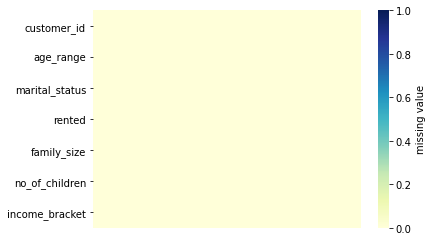

In [37]:
sns.heatmap(cust_demog.isna().transpose(),
            vmin=0,
            vmax=1,
            cbar=True,
            xticklabels=False,
            cmap="YlGnBu",
            cbar_kws={'label': 'missing value'})

In [38]:
train=pd.merge(df_train,cust_demog,on='customer_id',how='left')

In [39]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,13,27,1053,0,46-55,Single,0.0,1,0,5.0
1,2,13,116,48,0,36-45,Married,0.0,2,0,3.0
2,6,9,635,205,0,46-55,Married,0.0,2,0,7.0
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN
4,9,8,1017,1489,0,46-55,Married,0.0,2,0,3.0


<AxesSubplot:>

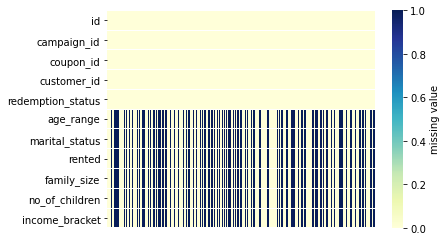

In [40]:
sns.heatmap(train.isna().transpose(),
            vmin=0,
            vmax=1,
            cbar=True,
            xticklabels=False,
            cmap="YlGnBu",
            cbar_kws={'label': 'missing value'})

In [41]:
train.dtypes

id                     int64
campaign_id            int64
coupon_id              int64
customer_id            int64
redemption_status      int64
age_range             object
marital_status        object
rented               float64
family_size           object
no_of_children        object
income_bracket       float64
dtype: object

### merge with campaign_info

In [42]:
campaign_data.head()

,campaign_id,camp_type,camp_start_date,camp_end_date,camp_duration,holiday_covered
0,24,Y,2013-10-21,2013-12-20,60,Yes
1,25,Y,2013-10-21,2013-11-22,32,Yes
2,20,Y,2013-09-07,2013-11-16,70,Yes
3,23,Y,2013-10-08,2013-11-15,38,Yes
4,21,Y,2013-09-16,2013-10-18,32,Yes


In [43]:
train=pd.merge(train,campaign_data,on='campaign_id',how='left')

In [44]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,camp_type,camp_start_date,camp_end_date,camp_duration,holiday_covered
0,1,13,27,1053,0,46-55,Single,0.0,1,0,5.0,X,2013-05-19,2013-07-05,47,Yes
1,2,13,116,48,0,36-45,Married,0.0,2,0,3.0,X,2013-05-19,2013-07-05,47,Yes
2,6,9,635,205,0,46-55,Married,0.0,2,0,7.0,Y,2013-03-11,2013-04-12,32,No
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN,X,2013-05-19,2013-07-05,47,Yes
4,9,8,1017,1489,0,46-55,Married,0.0,2,0,3.0,X,2013-02-16,2013-04-05,48,Yes


<AxesSubplot:>

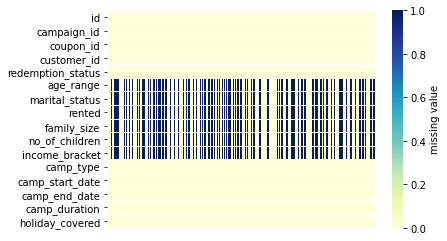

In [45]:
sns.heatmap(train.isna().transpose(),
            vmin=0,
            vmax=1,
            cbar=True,
            xticklabels=False,
            cmap="YlGnBu",
            cbar_kws={'label': 'missing value'})

### merge with item_category

In [46]:
coupon_items_cat.head()

,coupon_id,item_NO.,brand_NO.,brand_type,category
0,1,39,3,Established,"Natural Products,Grocery"
1,2,2,1,Established,Grocery
2,3,17,2,Established,Grocery
3,4,24,1,Established,Grocery
4,5,7,1,Established,Pharmaceutical


In [47]:
train=pd.merge(train,coupon_items_cat,on='coupon_id',how='left')

In [48]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,camp_type,camp_start_date,camp_end_date,camp_duration,holiday_covered,item_NO.,brand_NO.,brand_type,category
0,1,13,27,1053,0,46-55,Single,0.0,1,0,5.0,X,2013-05-19,2013-07-05,47,Yes,125,2,Established,Grocery
1,2,13,116,48,0,36-45,Married,0.0,2,0,3.0,X,2013-05-19,2013-07-05,47,Yes,3,1,Local,Grocery
2,6,9,635,205,0,46-55,Married,0.0,2,0,7.0,Y,2013-03-11,2013-04-12,32,No,67,1,Established,Pharmaceutical
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN,X,2013-05-19,2013-07-05,47,Yes,4,1,Established,Grocery
4,9,8,1017,1489,0,46-55,Married,0.0,2,0,3.0,X,2013-02-16,2013-04-05,48,Yes,32,1,Established,Grocery


### merge with customer_purchase history

In [49]:
cust_trans.head()

,customer_id,quantity,selling_price,other_discount,other_usage,coupon_discount,coupon_usage
0,1,1227,98513.93,-17030.40,497,-2116.83,78
1,2,474,43100.03,-7051.95,179,-249.34,4
2,3,8163,73050.27,-16013.53,393,-2179.54,53
3,4,280,33973.22,-2927.19,85,-89.05,1
4,5,93353,103615.10,-10817.07,290,-90.83,2


In [50]:
cust_trans.rename(columns={'quantity':'cust_quantity',
                           'selling_price':'cust_purchase',
                           'other_discount':'cust_other_discount',
                           'other_usage':'cust_other_usage',
                           'coupon_discount':'cust_coupon_discount',
                           'coupon_usage':'cust_coupon_usage'},inplace=True)

In [51]:
train=pd.merge(train,cust_trans,on='customer_id',how='left')

In [52]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,...,item_NO.,brand_NO.,brand_type,category,cust_quantity,cust_purchase,cust_other_discount,cust_other_usage,cust_coupon_discount,cust_coupon_usage
0,1,13,27,1053,0,46-55,Single,0.0,1,0,...,125,2,Established,Grocery,105551,57120.75,-10282.37,167,-89.05,1
1,2,13,116,48,0,36-45,Married,0.0,2,0,...,3,1,Local,Grocery,12143,90185.10,-10664.18,209,-1237.79,12
2,6,9,635,205,0,46-55,Married,0.0,2,0,...,67,1,Established,Pharmaceutical,1351,117461.66,-17261.79,457,-2145.72,85
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,...,4,1,Established,Grocery,306,23291.42,-3947.37,120,-178.10,2
4,9,8,1017,1489,0,46-55,Married,0.0,2,0,...,32,1,Established,Grocery,139063,67797.49,-11534.90,281,-265.01,10


<AxesSubplot:>

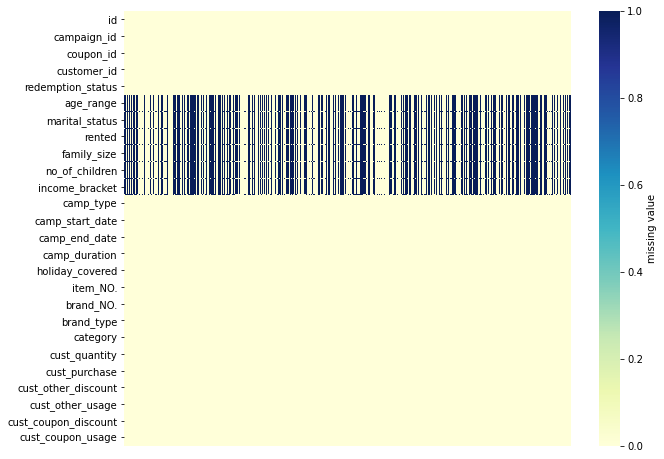

In [53]:
plt.subplots(figsize=(10,8))
sns.heatmap(train.isna().transpose(),
            vmin=0,
            vmax=1,
            cbar=True,
            xticklabels=False,
            cmap="YlGnBu",
            cbar_kws={'label': 'missing value'})

### merge with item_purchase history

In [54]:
coupon_items_trans.head()

,coupon_id,item_NO.,quantity,selling_price,other_discount,other_usage,coupon_discount,coupon_usage
0,1,39,1034.0,88272.89,-24468.37,575.0,-1526.31,35.0
1,2,2,103.0,9883.21,-1478.75,55.0,0.00,0.0
2,3,17,248.0,27498.59,-4952.62,149.0,-578.81,15.0
3,4,24,702.0,121581.84,-26804.05,628.0,-881.59,44.0
4,5,7,44.0,15407.69,-1228.88,16.0,0.00,0.0


In [55]:
coupon_items_trans.drop(columns='item_NO.',inplace=True)

In [56]:
coupon_items_trans.head()

,coupon_id,quantity,selling_price,other_discount,other_usage,coupon_discount,coupon_usage
0,1,1034.0,88272.89,-24468.37,575.0,-1526.31,35.0
1,2,103.0,9883.21,-1478.75,55.0,0.00,0.0
2,3,248.0,27498.59,-4952.62,149.0,-578.81,15.0
3,4,702.0,121581.84,-26804.05,628.0,-881.59,44.0
4,5,44.0,15407.69,-1228.88,16.0,0.00,0.0


In [57]:
coupon_items_trans.rename(columns={'quantity':'items_quantity',
                           'selling_price':'items_revenue',
                           'other_discount':'items_other_discount',
                           'other_usage':'items_other_usage',
                           'coupon_discount':'items_coupon_discount',
                           'coupon_usage':'items_coupon_usage'},inplace=True)

In [58]:
coupon_items_trans.head()

,coupon_id,items_quantity,items_revenue,items_other_discount,items_other_usage,items_coupon_discount,items_coupon_usage
0,1,1034.0,88272.89,-24468.37,575.0,-1526.31,35.0
1,2,103.0,9883.21,-1478.75,55.0,0.00,0.0
2,3,248.0,27498.59,-4952.62,149.0,-578.81,15.0
3,4,702.0,121581.84,-26804.05,628.0,-881.59,44.0
4,5,44.0,15407.69,-1228.88,16.0,0.00,0.0


In [59]:
train=pd.merge(train,coupon_items_trans,on='coupon_id',how='left')

<AxesSubplot:>

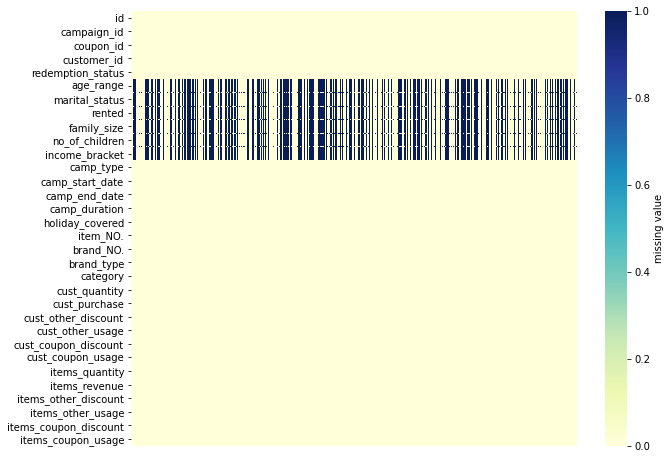

In [60]:
plt.subplots(figsize=(10,8))
sns.heatmap(train.isna().transpose(),
            vmin=0,
            vmax=1,
            cbar=True,
            xticklabels=False,
            cmap="YlGnBu",
            cbar_kws={'label': 'missing value'})

## data type check

### drop and reindex columns

In [61]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,...,cust_other_discount,cust_other_usage,cust_coupon_discount,cust_coupon_usage,items_quantity,items_revenue,items_other_discount,items_other_usage,items_coupon_discount,items_coupon_usage
0,1,13,27,1053,0,46-55,Single,0.0,1,0,...,-10282.37,167,-89.05,1,4661.0,318372.92,-225584.38,3529.0,-5349.93,191.0
1,2,13,116,48,0,36-45,Married,0.0,2,0,...,-10664.18,209,-1237.79,12,86.0,5418.96,-684.27,56.0,0.00,0.0
2,6,9,635,205,0,46-55,Married,0.0,2,0,...,-17261.79,457,-2145.72,85,202.0,47673.77,-23566.35,69.0,-605.54,15.0
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,...,-3947.37,120,-178.10,2,47.0,4154.42,-309.91,10.0,-17.81,1.0
4,9,8,1017,1489,0,46-55,Married,0.0,2,0,...,-11534.90,281,-265.01,10,1610.0,272558.55,-54950.74,987.0,-569.92,23.0


In [62]:
train_set=train.drop(columns='id',inplace=False)
train_set.head()

,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,...,cust_other_discount,cust_other_usage,cust_coupon_discount,cust_coupon_usage,items_quantity,items_revenue,items_other_discount,items_other_usage,items_coupon_discount,items_coupon_usage
0,13,27,1053,0,46-55,Single,0.0,1,0,5.0,...,-10282.37,167,-89.05,1,4661.0,318372.92,-225584.38,3529.0,-5349.93,191.0
1,13,116,48,0,36-45,Married,0.0,2,0,3.0,...,-10664.18,209,-1237.79,12,86.0,5418.96,-684.27,56.0,0.00,0.0
2,9,635,205,0,46-55,Married,0.0,2,0,7.0,...,-17261.79,457,-2145.72,85,202.0,47673.77,-23566.35,69.0,-605.54,15.0
3,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN,...,-3947.37,120,-178.10,2,47.0,4154.42,-309.91,10.0,-17.81,1.0
4,8,1017,1489,0,46-55,Married,0.0,2,0,3.0,...,-11534.90,281,-265.01,10,1610.0,272558.55,-54950.74,987.0,-569.92,23.0


### Deal with missing value

In [63]:
rented = train_set.rented.map(lambda x: str(int(x))
                              if pd.notnull(x) else x).fillna('unknown')
income_bracket = train_set.income_bracket.map(
    lambda x: str(int(x)) if pd.notnull(x) else x).fillna('unknown')
items_quantity = train_set.items_quantity.map(
    lambda x: int(x) if pd.notnull(x) else x).fillna('unknown')
items_coupon_usage = train_set.items_coupon_usage.map(
    lambda x: int(x) if pd.notnull(x) else x).fillna('unknown')
items_other_usage=train_set.items_other_usage.map(
    lambda x: int(x) if pd.notnull(x) else x).fillna('unknown')
age_range = train_set.age_range.fillna('unknown')
marital_status = train_set.marital_status.fillna('unknown')
family_size = train_set.family_size.fillna('unknown')
no_of_children = train_set.no_of_children.fillna('unknown')
train_set['rented'] = rented
train_set['income_bracket'] = income_bracket
train_set['items_quantity']=items_quantity
train_set['items_coupon_usage']=items_coupon_usage
train_set['items_other_usage']=items_other_usage
train_set['age_range'] = age_range
train_set['marital_status'] = marital_status
train_set['family_size'] = family_size
train_set['no_of_children'] = no_of_children

In [64]:
train_set.head()

,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,...,cust_other_discount,cust_other_usage,cust_coupon_discount,cust_coupon_usage,items_quantity,items_revenue,items_other_discount,items_other_usage,items_coupon_discount,items_coupon_usage
0,13,27,1053,0,46-55,Single,0,1,0,5,...,-10282.37,167,-89.05,1,4661,318372.92,-225584.38,3529,-5349.93,191
1,13,116,48,0,36-45,Married,0,2,0,3,...,-10664.18,209,-1237.79,12,86,5418.96,-684.27,56,0.00,0
2,9,635,205,0,46-55,Married,0,2,0,7,...,-17261.79,457,-2145.72,85,202,47673.77,-23566.35,69,-605.54,15
3,13,644,1050,0,unknown,unknown,unknown,unknown,unknown,unknown,...,-3947.37,120,-178.10,2,47,4154.42,-309.91,10,-17.81,1
4,8,1017,1489,0,46-55,Married,0,2,0,3,...,-11534.90,281,-265.01,10,1610,272558.55,-54950.74,987,-569.92,23


In [65]:
train_set.dtypes

campaign_id                int64
coupon_id                  int64
customer_id                int64
redemption_status          int64
age_range                 object
marital_status            object
rented                    object
family_size               object
no_of_children            object
income_bracket            object
camp_type                 object
camp_start_date           object
camp_end_date             object
camp_duration              int64
holiday_covered           object
item_NO.                   int64
brand_NO.                  int64
brand_type                object
category                  object
cust_quantity              int64
cust_purchase            float64
cust_other_discount      float64
cust_other_usage           int64
cust_coupon_discount     float64
cust_coupon_usage          int64
items_quantity             int64
items_revenue            float64
items_other_discount     float64
items_other_usage          int64
items_coupon_discount    float64
items_coup

### Deal with Datatime features

In [66]:
train_set['camp_start_month']=pd.to_datetime(train_set.camp_start_date).dt.month
train_set['camp_end_month']=pd.to_datetime(train_set.camp_end_date).dt.month

In [67]:
new_columns=['customer_id','age_range','marital_status','rented','family_size','no_of_children','income_bracket',
             'coupon_id','campaign_id','camp_type','camp_start_month','camp_end_month','camp_duration','holiday_covered',
             'item_NO.','brand_NO.','brand_type','category',
             'cust_quantity','cust_purchase','cust_other_discount','cust_other_usage','cust_coupon_discount','cust_coupon_usage',
             'items_quantity','items_revenue','items_other_discount','items_other_usage','items_coupon_discount','items_coupon_usage',
             'redemption_status']
train_processed=train_set.reindex(columns=new_columns,copy=True)

In [68]:
train_processed.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket,coupon_id,campaign_id,camp_type,...,cust_other_usage,cust_coupon_discount,cust_coupon_usage,items_quantity,items_revenue,items_other_discount,items_other_usage,items_coupon_discount,items_coupon_usage,redemption_status
0,1053,46-55,Single,0,1,0,5,27,13,X,...,167,-89.05,1,4661,318372.92,-225584.38,3529,-5349.93,191,0
1,48,36-45,Married,0,2,0,3,116,13,X,...,209,-1237.79,12,86,5418.96,-684.27,56,0.00,0,0
2,205,46-55,Married,0,2,0,7,635,9,Y,...,457,-2145.72,85,202,47673.77,-23566.35,69,-605.54,15,0
3,1050,unknown,unknown,unknown,unknown,unknown,unknown,644,13,X,...,120,-178.10,2,47,4154.42,-309.91,10,-17.81,1,0
4,1489,46-55,Married,0,2,0,3,1017,8,X,...,281,-265.01,10,1610,272558.55,-54950.74,987,-569.92,23,0


In [69]:
train_processed.columns

Index(['customer_id', 'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket', 'coupon_id', 'campaign_id',
       'camp_type', 'camp_start_month', 'camp_end_month', 'camp_duration',
       'holiday_covered', 'item_NO.', 'brand_NO.', 'brand_type', 'category',
       'cust_quantity', 'cust_purchase', 'cust_other_discount',
       'cust_other_usage', 'cust_coupon_discount', 'cust_coupon_usage',
       'items_quantity', 'items_revenue', 'items_other_discount',
       'items_other_usage', 'items_coupon_discount', 'items_coupon_usage',
       'redemption_status'],
      dtype='object')

In [70]:
train_processed.to_csv(
    './Coupon_Raw_Data/New Table/train_processed.csv', index=False)

## multicollinearity analysis

### Pearson Correlation

In [71]:
numerical_feature = ['camp_duration', 'cust_quantity',
    'cust_purchase', 'cust_other_discount', 'cust_other_usage','cust_coupon_discount',
    'cust_coupon_usage', 'item_NO.','brand_NO.','items_quantity', 'items_revenue',
    'items_other_discount','items_other_usage', 'items_coupon_discount', 'items_coupon_usage']
train_numeric=train_processed[numerical_feature]
train_numeric.head()

,camp_duration,cust_quantity,cust_purchase,cust_other_discount,cust_other_usage,cust_coupon_discount,cust_coupon_usage,item_NO.,brand_NO.,items_quantity,items_revenue,items_other_discount,items_other_usage,items_coupon_discount,items_coupon_usage
0,47,105551,57120.75,-10282.37,167,-89.05,1,125,2,4661,318372.92,-225584.38,3529,-5349.93,191
1,47,12143,90185.10,-10664.18,209,-1237.79,12,3,1,86,5418.96,-684.27,56,0.00,0
2,32,1351,117461.66,-17261.79,457,-2145.72,85,67,1,202,47673.77,-23566.35,69,-605.54,15
3,47,306,23291.42,-3947.37,120,-178.10,2,4,1,47,4154.42,-309.91,10,-17.81,1
4,48,139063,67797.49,-11534.90,281,-265.01,10,32,1,1610,272558.55,-54950.74,987,-569.92,23


In [72]:
pearson_corr=train_numeric.corr(method='pearson')

<AxesSubplot:>

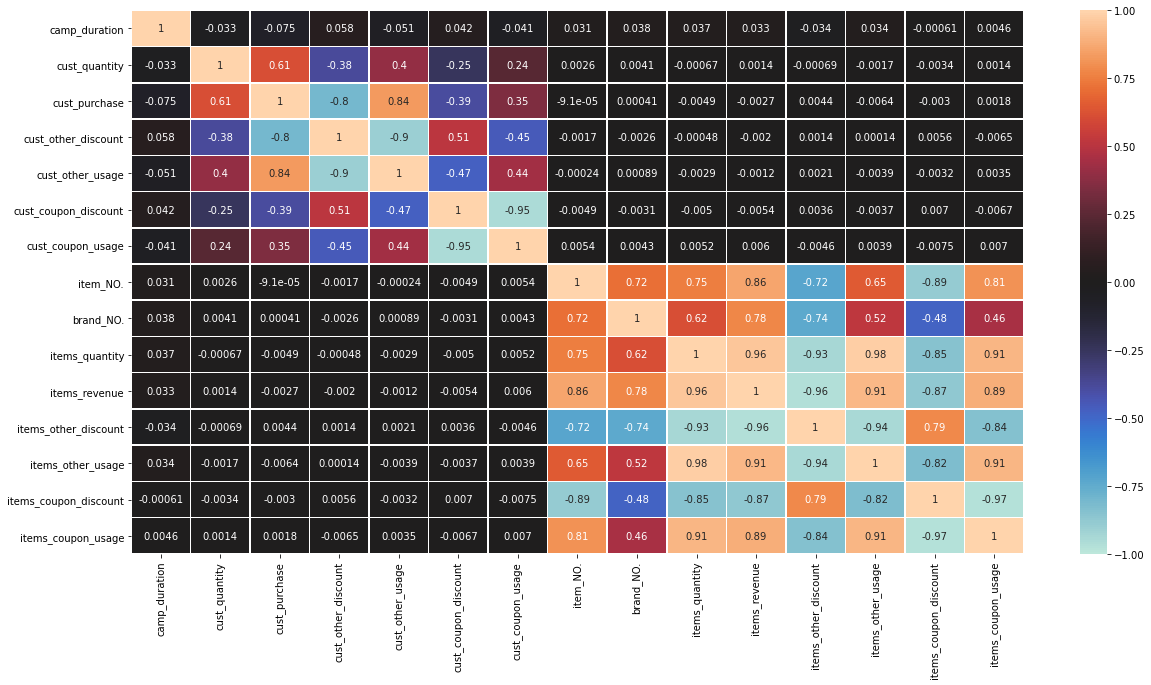

In [73]:
plt.subplots(figsize=(20,10))
sns.heatmap(pearson_corr,
            vmin=-1,
            vmax=1,
            annot=True, linewidths=.5, center=0)

## VIF Analysis--customers

In [74]:
cust_numerical_feature = ['cust_quantity',
    'cust_purchase', 'cust_other_discount','cust_other_usage', 'cust_coupon_discount',
    'cust_coupon_usage']

<Figure size 3600x3600 with 0 Axes>

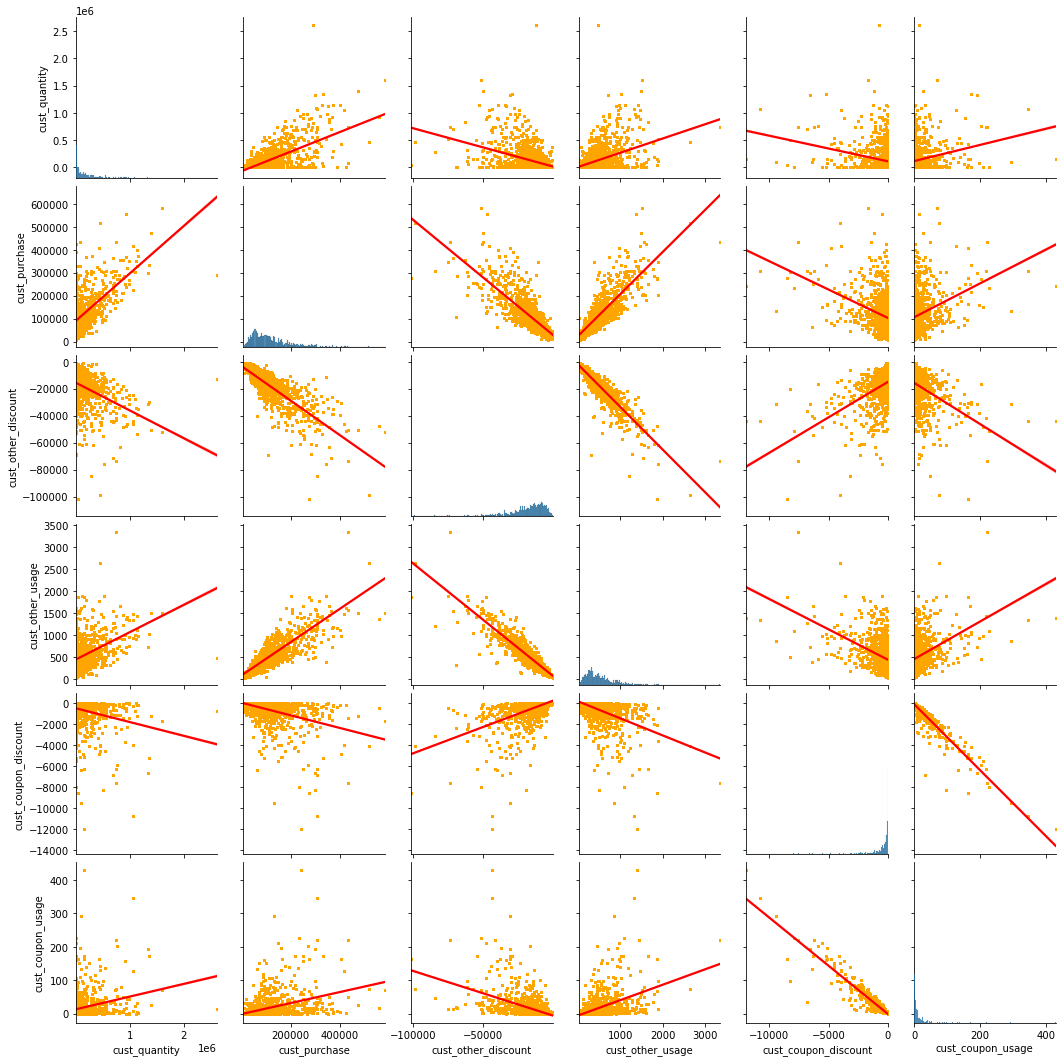

In [75]:
plt.figure(figsize=(50,50))
ax=sns.pairplot(train_processed[cust_numerical_feature], diag_kind='hist', kind='reg', dropna=True,
                  plot_kws={'color': 'red',
                            'scatter_kws': {'color': 'orange', 's': 3, 'alpha': 0.6}})

In [76]:
# VIF calculation
def vif_cal(X):
    vif_data = pd.DataFrame()
    vif_data['features'] = X.columns
     # calculating VIF for each feature
    vif_data["VIF"] = [vif(X.values, i) for i in range(len(X.columns))]
    print(vif_data)

### VIF based on numbers

In [77]:
cust_numerical_feature = ['cust_quantity',
    'cust_purchase', 'cust_other_discount','cust_other_usage', 'cust_coupon_discount',
    'cust_coupon_usage']

In [78]:
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

               features        VIF
0         cust_quantity   2.281048
1         cust_purchase  14.535867
2   cust_other_discount  18.978527
3      cust_other_usage  21.420386
4  cust_coupon_discount  14.454780
5     cust_coupon_usage  13.023489


In [79]:
cust_numerical_feature.remove('cust_coupon_discount')
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

              features        VIF
0        cust_quantity   2.280603
1        cust_purchase  14.529358
2  cust_other_discount  17.449200
3     cust_other_usage  20.874369
4    cust_coupon_usage   1.580130


In [80]:
cust_numerical_feature.remove('cust_other_discount')
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

            features        VIF
0      cust_quantity   2.247007
1      cust_purchase  13.444049
2   cust_other_usage  11.497568
3  cust_coupon_usage   1.545505


In [81]:
cust_numerical_feature.remove('cust_purchase')
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

            features       VIF
0      cust_quantity  1.613021
1   cust_other_usage  2.046432
2  cust_coupon_usage  1.520083


### VIF based on VIF value

In [82]:
Init_cust_feature=['cust_quantity',
    'cust_purchase', 'cust_other_discount','cust_coupon_discount']

In [83]:
cust_df=train_processed[Init_cust_feature]
vif_cal(cust_df)

               features        VIF
0         cust_quantity   2.239269
1         cust_purchase  11.491336
2   cust_other_discount  10.067823
3  cust_coupon_discount   1.746442


In [84]:
cust_numerical_feature = ['cust_quantity',
    'cust_purchase', 'cust_other_discount','cust_other_usage', 'cust_coupon_discount',
    'cust_coupon_usage']

In [85]:
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

               features        VIF
0         cust_quantity   2.281048
1         cust_purchase  14.535867
2   cust_other_discount  18.978527
3      cust_other_usage  21.420386
4  cust_coupon_discount  14.454780
5     cust_coupon_usage  13.023489


In [86]:
cust_numerical_feature.remove('cust_other_usage')
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

               features        VIF
0         cust_quantity   2.239510
1         cust_purchase  11.531269
2   cust_other_discount  10.209767
3  cust_coupon_discount  14.086320
4     cust_coupon_usage  12.533762


In [87]:
cust_numerical_feature.remove('cust_coupon_usage')
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

               features        VIF
0         cust_quantity   2.239269
1         cust_purchase  11.491336
2   cust_other_discount  10.067823
3  cust_coupon_discount   1.746442


In [88]:
cust_numerical_feature.remove('cust_purchase')
cust_df=train_processed[cust_numerical_feature]
vif_cal(cust_df)

               features       VIF
0         cust_quantity  1.575431
1   cust_other_discount  2.198979
2  cust_coupon_discount  1.708888


## VIF Analysis--items

### VIF analysis on numbers

In [89]:
items_numerical_feature = ['item_NO.','brand_NO.','items_quantity', 'items_revenue',
    'items_other_discount','items_other_usage', 'items_coupon_discount', 'items_coupon_usage']

In [90]:
item_df=train_processed[items_numerical_feature]
vif_cal(item_df)

                features         VIF
0               item_NO.   53.524149
1              brand_NO.   29.865911
2         items_quantity  374.849861
3          items_revenue  596.798328
4   items_other_discount  244.066158
5      items_other_usage  447.955464
6  items_coupon_discount  102.848186
7     items_coupon_usage  100.724818


In [91]:
items_numerical_feature.remove('items_revenue')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

                features         VIF
0               item_NO.   29.584717
1              brand_NO.   26.752688
2         items_quantity  220.924226
3   items_other_discount  104.189728
4      items_other_usage  406.128124
5  items_coupon_discount  102.784540
6     items_coupon_usage   98.931039


In [92]:
items_numerical_feature.remove('items_other_discount')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

                features         VIF
0               item_NO.   28.984842
1              brand_NO.    4.606761
2         items_quantity   82.711282
3      items_other_usage   75.302398
4  items_coupon_discount  101.443836
5     items_coupon_usage   97.706874


In [93]:
items_numerical_feature.remove('items_coupon_discount')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

             features        VIF
0            item_NO.  13.197113
1           brand_NO.   4.303483
2      items_quantity  69.085051
3   items_other_usage  72.426121
4  items_coupon_usage  22.178459


In [94]:
items_numerical_feature.remove('items_quantity')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

             features        VIF
0            item_NO.   9.827365
1           brand_NO.   4.238813
2   items_other_usage  11.867204
3  items_coupon_usage  21.023926


In [95]:
items_numerical_feature.remove('items_other_usage')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

             features       VIF
0            item_NO.  5.182431
1           brand_NO.  2.287776
2  items_coupon_usage  3.161901


### VIF analysis on VIF values

In [96]:
Init_item_feature = ['items_quantity', 'items_revenue',
    'items_other_discount', 'items_coupon_discount']

In [97]:
item_df=train_processed[Init_item_feature]
vif_cal(item_df)

                features        VIF
0         items_quantity  12.738233
1          items_revenue  31.110653
2   items_other_discount  18.165657
3  items_coupon_discount   5.301135


In [98]:
items_numerical_feature = ['item_NO.','brand_NO.','items_quantity', 'items_revenue',
    'items_other_discount','items_other_usage', 'items_coupon_discount', 'items_coupon_usage']

In [99]:
item_df=train_processed[items_numerical_feature]
vif_cal(item_df)

                features         VIF
0               item_NO.   53.524149
1              brand_NO.   29.865911
2         items_quantity  374.849861
3          items_revenue  596.798328
4   items_other_discount  244.066158
5      items_other_usage  447.955464
6  items_coupon_discount  102.848186
7     items_coupon_usage  100.724818


In [100]:
items_numerical_feature.remove('items_revenue')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

                features         VIF
0               item_NO.   29.584717
1              brand_NO.   26.752688
2         items_quantity  220.924226
3   items_other_discount  104.189728
4      items_other_usage  406.128124
5  items_coupon_discount  102.784540
6     items_coupon_usage   98.931039


In [101]:
items_numerical_feature.remove('items_other_usage')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

                features         VIF
0               item_NO.   25.129744
1              brand_NO.   10.265784
2         items_quantity   21.241840
3   items_other_discount   19.318377
4  items_coupon_discount  102.745560
5     items_coupon_usage   96.958179


In [102]:
items_numerical_feature.remove('items_coupon_discount')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

               features        VIF
0              item_NO.   9.913780
1             brand_NO.   9.254381
2        items_quantity  14.480781
3  items_other_discount  18.345082
4    items_coupon_usage  20.666519


In [103]:
items_numerical_feature.remove('items_coupon_usage')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

               features        VIF
0              item_NO.   3.358469
1             brand_NO.   3.492454
2        items_quantity  11.917177
3  items_other_discount  13.248147


In [104]:
items_numerical_feature.remove('items_other_discount')
cust_df=train_processed[items_numerical_feature]
vif_cal(cust_df)

         features       VIF
0        item_NO.  3.082987
1       brand_NO.  2.150141
2  items_quantity  2.398185


<Figure size 3600x3600 with 0 Axes>

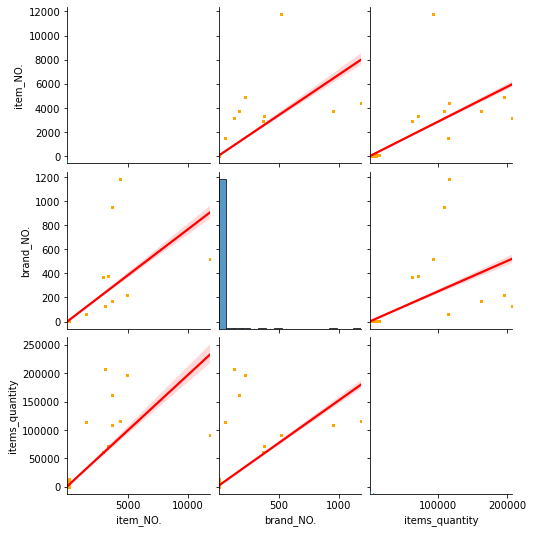

In [105]:
plt.figure(figsize=(50,50))
ax=sns.pairplot(train_processed[items_numerical_feature], diag_kind='hist', kind='reg', dropna=True,
                  plot_kws={'color': 'red',
                            'scatter_kws': {'color': 'orange', 's': 3, 'alpha': 0.6}})

For **customer purchase history**, I decided to keep  **cust_quantity**,**cust_other_usage** and **cust_coupon_usage**.

For **items purchase history**,  I decided to keep **items_NO**,**brand_NO** and **items_quantity**.

In [106]:
features=['age_range','marital_status','rented','family_size','no_of_children','income_bracket',
          'cust_quantity','cust_other_usage','cust_coupon_usage',
          'camp_type','camp_start_month','camp_end_month','camp_duration','holiday_covered',
          'item_NO.','brand_NO.','brand_type','category','items_quantity','redemption_status']
train_final=train_processed[features]

In [107]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age_range          78369 non-null  object
 1   marital_status     78369 non-null  object
 2   rented             78369 non-null  object
 3   family_size        78369 non-null  object
 4   no_of_children     78369 non-null  object
 5   income_bracket     78369 non-null  object
 6   cust_quantity      78369 non-null  int64 
 7   cust_other_usage   78369 non-null  int64 
 8   cust_coupon_usage  78369 non-null  int64 
 9   camp_type          78369 non-null  object
 10  camp_start_month   78369 non-null  int64 
 11  camp_end_month     78369 non-null  int64 
 12  camp_duration      78369 non-null  int64 
 13  holiday_covered    78369 non-null  object
 14  item_NO.           78369 non-null  int64 
 15  brand_NO.          78369 non-null  int64 
 16  brand_type         78369 non-null  objec

In [108]:
train_final.redemption_status.value_counts(normalize=True)

0    0.990698
1    0.009302
Name: redemption_status, dtype: float64

In [109]:
train_final.to_csv('./Coupon_Raw_Data/New Table/train_final.csv', index=False)

## Logistic Regression

In [115]:
#pip install imblearn smote

In [116]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from matplotlib.collections import LineCollection

In [117]:
data=pd.read_csv('./Coupon_Raw_Data/New Table/train_final.csv')
data.head()

,age_range,marital_status,rented,family_size,no_of_children,income_bracket,cust_quantity,cust_other_usage,cust_coupon_usage,camp_type,camp_start_month,camp_end_month,camp_duration,holiday_covered,item_NO.,brand_NO.,brand_type,category,items_quantity,redemption_status
0,46-55,Single,0,1,0,5,105551,167,1,X,5,7,47,Yes,125,2,Established,Grocery,4661,0
1,36-45,Married,0,2,0,3,12143,209,12,X,5,7,47,Yes,3,1,Local,Grocery,86,0
2,46-55,Married,0,2,0,7,1351,457,85,Y,3,4,32,No,67,1,Established,Pharmaceutical,202,0
3,unknown,unknown,unknown,unknown,unknown,unknown,306,120,2,X,5,7,47,Yes,4,1,Established,Grocery,47,0
4,46-55,Married,0,2,0,3,139063,281,10,X,2,4,48,Yes,32,1,Established,Grocery,1610,0


###  Train/Test Split

In [118]:
features=list(data.columns)
features.remove('redemption_status')
X=data[features]
y=data['redemption_status']

In [119]:
X.head()

,age_range,marital_status,rented,family_size,no_of_children,income_bracket,cust_quantity,cust_other_usage,cust_coupon_usage,camp_type,camp_start_month,camp_end_month,camp_duration,holiday_covered,item_NO.,brand_NO.,brand_type,category,items_quantity
0,46-55,Single,0,1,0,5,105551,167,1,X,5,7,47,Yes,125,2,Established,Grocery,4661
1,36-45,Married,0,2,0,3,12143,209,12,X,5,7,47,Yes,3,1,Local,Grocery,86
2,46-55,Married,0,2,0,7,1351,457,85,Y,3,4,32,No,67,1,Established,Pharmaceutical,202
3,unknown,unknown,unknown,unknown,unknown,unknown,306,120,2,X,5,7,47,Yes,4,1,Established,Grocery,47
4,46-55,Married,0,2,0,3,139063,281,10,X,2,4,48,Yes,32,1,Established,Grocery,1610


In [120]:
y.value_counts(normalize=True)

0    0.990698
1    0.009302
Name: redemption_status, dtype: float64

<AxesSubplot:>

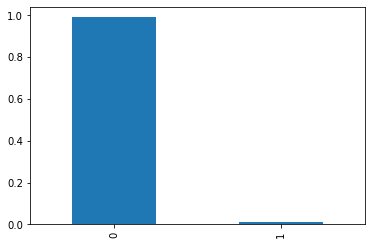

In [121]:
y.value_counts(normalize=True).plot(kind='bar')

In [122]:
# stratified train/test split with an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42, stratify=y)
train_0, train_1 = len(y_train[y_train == 0]), len(y_train[y_train == 1])
test_0, test_1 = len(y_test[y_test == 0]), len(y_test[y_test == 1])
print('>Train: 0=%d, 1=%d, 2=%.4f%%, Test: 3=%d, 4=%d, 5=%.4f%%' % (train_0, train_1, (train_1/train_0)*100, test_0, test_1, (test_1/test_0)*100))

>Train: 0=62112, 1=583, 2=0.9386%, Test: 3=15528, 4=146, 5=0.9402%


In [123]:
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [124]:
X_train.head()

,age_range,marital_status,rented,family_size,no_of_children,income_bracket,cust_quantity,cust_other_usage,cust_coupon_usage,camp_type,camp_start_month,camp_end_month,camp_duration,holiday_covered,item_NO.,brand_NO.,brand_type,category,items_quantity
0,56-70,Married,0,2,0,7,165381,466,0,X,2,4,48,Yes,1,1,Local,Grocery,9
1,unknown,unknown,unknown,unknown,unknown,unknown,1306,612,10,Y,9,11,61,Yes,101,1,Established,Grocery,5544
2,36-45,unknown,0,2,unknown,6,389836,423,2,Y,2,3,34,Yes,3,1,Established,Pharmaceutical,135
3,unknown,unknown,unknown,unknown,unknown,unknown,742213,1034,73,X,2,4,48,Yes,2,1,Established,Grocery,17
4,unknown,unknown,unknown,unknown,unknown,unknown,15697,190,0,X,2,4,48,Yes,6,1,Established,Grocery,211


In [125]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: redemption_status, dtype: int64

### Features

In [126]:
features = [
    'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children',
    'income_bracket', 'cust_quantity', 'cust_other_usage', 'cust_coupon_usage',
    'camp_type', 'camp_start_month', 'camp_end_month', 'camp_duration',
    'holiday_covered', 'item_NO.', 'brand_NO.', 'brand_type', 'category',
    'items_quantity'
]

num_features = ['cust_quantity', 'cust_other_usage', 'cust_coupon_usage',
                'camp_duration','item_NO.', 'brand_NO.', 'items_quantity']
cat_features=list(set(features)-set(num_features))
cat_features

['camp_start_month',
 'category',
 'age_range',
 'no_of_children',
 'marital_status',
 'holiday_covered',
 'income_bracket',
 'family_size',
 'camp_type',
 'rented',
 'brand_type',
 'camp_end_month']

### Default Setting

In [127]:
numeric_transformer=MinMaxScaler()
cat_transformer=OneHotEncoder(handle_unknown='ignore')
transformers=[('num',numeric_transformer,num_features),
              ('cat',cat_transformer,cat_features)]

In [128]:
preprocessor=ColumnTransformer(transformers,n_jobs=-1,remainder='passthrough')
estimator=LogisticRegression(class_weight=None,max_iter=10000,n_jobs=-1)
steps=[('preprocessor',preprocessor),
        ('estimator',estimator)]
pipeline=Pipeline(steps)

In [129]:
pipeline.fit(X_train,y_train)

C:\Users\gobey\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  repr_ = repr_[:left_lim] + "..." + repr_[-right_lim:]


AttributeError: 'OneHotEncoder' object has no attribute 'max_categories'